# New tabular Model

In [1]:
import numpy as np
import polars as pl
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve
import optuna

# -----------------------------
# 1. Feature Engineering
# -----------------------------

def create_features(df: pl.DataFrame, source_name: str) -> pl.DataFrame:
    epsilon = 1e-9
    df = df.with_columns(pl.lit(source_name).alias("source_dataset"))

    # --- Core ratios & contrasts (your existing set) ---
    df = df.with_columns([
        # Profit ratios
        (pl.col("abnormal_fprofit") / (pl.col("t_fprofit") + epsilon)).alias("ratio_abnormal_fprofit"),
        (pl.col("normal_fprofit") / (pl.col("t_fprofit") + epsilon)).alias("ratio_normal_fprofit"),
        (pl.col("abnormal_bprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_abnormal_bprofit"),
        (pl.col("normal_bprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_normal_bprofit"),

        # Size ratios
        (pl.col("abnormal_fsize") / (pl.col("t_fsize") + epsilon)).alias("ratio_abnormal_fsize"),
        (pl.col("normal_fsize") / (pl.col("t_fsize") + epsilon)).alias("ratio_normal_fsize"),
        (pl.col("abnormal_bsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_abnormal_bsize"),
        (pl.col("normal_bsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_normal_bsize"),

        # Directional contrasts
        (pl.col("t_fprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_fprofit_to_bprofit"),
        (pl.col("t_fsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_fsize_to_bsize"),
        (pl.col("t_fprofit") - pl.col("t_bprofit")).alias("diff_fprofit_bprofit"),
        (pl.col("t_fsize") - pl.col("t_bsize")).alias("diff_fsize_bsize"),

        # Abnormal vs normal comparisons
        (pl.col("abnormal_fprofit") / (pl.col("normal_fprofit") + epsilon)).alias("ratio_abn_norm_fprofit"),
        (pl.col("abnormal_bprofit") / (pl.col("normal_bprofit") + epsilon)).alias("ratio_abn_norm_bprofit"),

        # Efficiency metrics
        (pl.col("t_fprofit") / (pl.col("t_fsize") + epsilon)).alias("eff_f_profit_per_size"),
        (pl.col("t_bprofit") / (pl.col("t_bsize") + epsilon)).alias("eff_b_profit_per_size"),
        ((pl.col("t_fprofit") / (pl.col("t_fsize") + epsilon)) -
         (pl.col("t_bprofit") / (pl.col("t_bsize") + epsilon))).alias("diff_eff_profit_per_size"),
    ])

    # --- Population-relative features (focused on top-ranked signals) ---
    top_features = [
        "ratio_normal_fsize", "ratio_abnormal_fsize", "ratio_abnormal_bsize",
        "B_fvalue_to_gas_ratio_min", "B_fvalue_to_gas_ratio_mean",
        "B_bnet_value_min", "B_bnet_value_max", "B_bnet_value_mean", "B_bnet_value_std",
        "B_fnet_value_min", "B_fgas_cost_min", "B_fgas_cost_std", "B_fgas_cost_max",
        "B_bgas_cost_min", "B_bgas_cost_std", "B_bgas_cost_max"
    ]

    for col in top_features:
        if col in df.columns:
            mean_val, std_val, median_val = df[col].mean(), df[col].std(), df[col].median()
            df = df.with_columns([
                ((pl.col(col) - mean_val) / (std_val + epsilon)).alias(f"z_{col}"),
                (pl.col(col).rank() / df.height).alias(f"rank_{col}"),
                (pl.col(col) / (median_val + epsilon)).alias(f"ratio_to_median_{col}")
            ])

    # --- Cross-feature contrasts ---
    if all(c in df.columns for c in ["ratio_normal_fsize", "ratio_abnormal_fsize"]):
        df = df.with_columns(
            (pl.col("ratio_normal_fsize") / (pl.col("ratio_abnormal_fsize") + epsilon)).alias("ratio_norm_abn_fsize_ratio")
        )
    if all(c in df.columns for c in ["B_bnet_value_min", "B_fnet_value_min"]):
        df = df.with_columns(
            (pl.col("B_bnet_value_min") / (pl.col("B_fnet_value_min") + epsilon)).alias("ratio_bf_net_value_min")
        )
    if all(c in df.columns for c in ["B_fgas_cost_min", "B_bgas_cost_min"]):
        df = df.with_columns(
            (pl.col("B_fgas_cost_min") - pl.col("B_bgas_cost_min")).alias("diff_f_b_gas_cost_min")
        )

    # --- Abnormality index ---
    abnormal_zs = [c for c in df.columns if c.startswith("z_ratio_abnormal") or c.startswith("z_abnormal")]
    if abnormal_zs:
        df = df.with_columns(
            sum([pl.col(c) for c in abnormal_zs]).alias("abnormality_index")
        )

    return df

## Loader and Feature Generation

In [2]:
import numpy as np
import polars as pl
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix
import optuna

# -----------------------------
# 1. Helper Functions
# -----------------------------
def entropy_from_cols(df: pl.DataFrame, cols: list, name: str, eps: float = 1e-9) -> pl.Series:
    M = df.select(cols).to_numpy()
    denom = M.sum(axis=1, keepdims=True) + eps
    P = M / denom
    H = -(P * np.log(P + eps)).sum(axis=1)
    return pl.Series(name, H)

def topk_share_from_cols(df: pl.DataFrame, cols: list, name: str, k: int = 3, eps: float = 1e-9) -> pl.Series:
    M = df.select(cols).to_numpy()
    denom = M.sum(axis=1, keepdims=True) + eps
    topk = np.sort(M, axis=1)[:, ::-1][:, :k].sum(axis=1)
    share = topk / denom.ravel()
    return pl.Series(name, share)

def peak_share_from_cols(df: pl.DataFrame, cols: list, name: str, eps: float = 1e-9) -> pl.Series:
    M = df.select(cols).to_numpy()
    denom = M.sum(axis=1) + eps
    peak = M.max(axis=1)
    return pl.Series(name, peak / denom)

def coeff_var(mean_col: str, std_col: str, name: str, eps: float = 1e-9) -> pl.Expr:
    return (pl.col(std_col) / (pl.col(mean_col) + eps)).alias(name)

def norm_range(min_col: str, max_col: str, mean_col: str, name: str, eps: float = 1e-9) -> pl.Expr:
    return ((pl.col(max_col) - pl.col(min_col)) / (pl.col(mean_col) + eps)).alias(name)

def bounded_ratio(num: str, den: str, name: str, eps: float = 1e-9) -> pl.Expr:
    return (pl.col(num) / (pl.col(num) + pl.col(den) + eps)).alias(name)

# -----------------------------
# 2. Feature Engineering
# -----------------------------
def create_features(df: pl.DataFrame, source_name: str) -> pl.DataFrame:
    epsilon = 1e-9
    df = df.with_columns(pl.lit(source_name).alias("source_dataset"))

    # --- Core ratios & contrasts (your existing set) ---
    df = df.with_columns([
        (pl.col("abnormal_fprofit") / (pl.col("t_fprofit") + epsilon)).alias("ratio_abnormal_fprofit"),
        (pl.col("normal_fprofit") / (pl.col("t_fprofit") + epsilon)).alias("ratio_normal_fprofit"),
        (pl.col("abnormal_bprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_abnormal_bprofit"),
        (pl.col("normal_bprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_normal_bprofit"),

        (pl.col("abnormal_fsize") / (pl.col("t_fsize") + epsilon)).alias("ratio_abnormal_fsize"),
        (pl.col("normal_fsize") / (pl.col("t_fsize") + epsilon)).alias("ratio_normal_fsize"),
        (pl.col("abnormal_bsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_abnormal_bsize"),
        (pl.col("normal_bsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_normal_bsize"),

        (pl.col("t_fprofit") / (pl.col("t_bprofit") + epsilon)).alias("ratio_fprofit_to_bprofit"),
        (pl.col("t_fsize") / (pl.col("t_bsize") + epsilon)).alias("ratio_fsize_to_bsize"),
        (pl.col("t_fprofit") - pl.col("t_bprofit")).alias("diff_fprofit_bprofit"),
        (pl.col("t_fsize") - pl.col("t_bsize")).alias("diff_fsize_bsize"),

        (pl.col("abnormal_fprofit") / (pl.col("normal_fprofit") + epsilon)).alias("ratio_abn_norm_fprofit"),
        (pl.col("abnormal_bprofit") / (pl.col("normal_bprofit") + epsilon)).alias("ratio_abn_norm_bprofit"),

        (pl.col("t_fprofit") / (pl.col("t_fsize") + epsilon)).alias("eff_f_profit_per_size"),
        (pl.col("t_bprofit") / (pl.col("t_bsize") + epsilon)).alias("eff_b_profit_per_size"),
        ((pl.col("t_fprofit") / (pl.col("t_fsize") + epsilon)) -
         (pl.col("t_bprofit") / (pl.col("t_bsize") + epsilon))).alias("diff_eff_profit_per_size"),
    ])

    # --- Entropy & Concentration ---
    # Example: forward hours
    # --- Entropy & Concentration (symmetric coverage) ---
    # Define groups of hour-based columns by prefix
    # --- Entropy & Concentration (symmetric coverage across time granularities) ---
    # Define groups of time-based columns by prefix
    time_groups = {
        # Hourly distributions
        "A_fhour": [c for c in df.columns if c.startswith("A_fhour_")],
        "B_fhour": [c for c in df.columns if c.startswith("B_fhour_")],
        "normal_fhour": [c for c in df.columns if c.startswith("normal_fhour_")],
        "abnormal_fhour": [c for c in df.columns if c.startswith("abnormal_fhour_")],
        "t_fhour": [c for c in df.columns if c.startswith("t_fhour_")],

        # Daily distributions
        "A_fday": [c for c in df.columns if c.startswith("A_fday_")],
        "B_fday": [c for c in df.columns if c.startswith("B_fday_")],
        "normal_fday": [c for c in df.columns if c.startswith("normal_fday_")],
        "abnormal_fday": [c for c in df.columns if c.startswith("abnormal_fday_")],
        "t_fday": [c for c in df.columns if c.startswith("t_fday_")],

        # Weekday distributions
        "A_fweekday": [c for c in df.columns if c.startswith("A_fweekday_")],
        "B_fweekday": [c for c in df.columns if c.startswith("B_fweekday_")],
        "normal_fweekday": [c for c in df.columns if c.startswith("normal_fweekday_")],
        "abnormal_fweekday": [c for c in df.columns if c.startswith("abnormal_fweekday_")],
        "t_fweekday": [c for c in df.columns if c.startswith("t_fweekday_")],

        # Monthly distributions
        "A_fmonth": [c for c in df.columns if c.startswith("A_fmonth_")],
        "B_fmonth": [c for c in df.columns if c.startswith("B_fmonth_")],
        "normal_fmonth": [c for c in df.columns if c.startswith("normal_fmonth_")],
        "abnormal_fmonth": [c for c in df.columns if c.startswith("abnormal_fmonth_")],
        "t_fmonth": [c for c in df.columns if c.startswith("t_fmonth_")]
    }

    # Loop through each group and add entropy/peakshare/top3share
    for prefix, cols in time_groups.items():
        if cols:
            df = df.with_columns([
                entropy_from_cols(df, cols, f"entropy_{prefix}_freq"),
                peak_share_from_cols(df, cols, f"peakshare_{prefix}_freq"),
                topk_share_from_cols(df, cols, f"top3share_{prefix}_freq")
            ])

    # --- Seasonal contrasts (quarterly / seasonal patterns) ---
    # If you have monthly distributions (e.g. A_fmonth_1 ... A_fmonth_12)
    month_cols = [c for c in df.columns if c.startswith("t_fmonth_")]
    if month_cols and len(month_cols) >= 12:
        # Define quarters
        q1 = [f"t_fmonth_{m}" for m in [1,2,3] if f"t_fmonth_{m}" in df.columns]
        q2 = [f"t_fmonth_{m}" for m in [4,5,6] if f"t_fmonth_{m}" in df.columns]
        q3 = [f"t_fmonth_{m}" for m in [7,8,9] if f"t_fmonth_{m}" in df.columns]
        q4 = [f"t_fmonth_{m}" for m in [10,11,12] if f"t_fmonth_{m}" in df.columns]

        # Aggregate seasonal totals
        df = df.with_columns([
            pl.sum_horizontal([pl.col(c) for c in q1]).alias("season_Q1_total"),
            pl.sum_horizontal([pl.col(c) for c in q2]).alias("season_Q2_total"),
            pl.sum_horizontal([pl.col(c) for c in q3]).alias("season_Q3_total"),
            pl.sum_horizontal([pl.col(c) for c in q4]).alias("season_Q4_total"),
        ])

        # Ratios between seasons (contrasts)
        df = df.with_columns([
            (pl.col("season_Q1_total") / (pl.col("season_Q2_total")+epsilon)).alias("ratio_Q1_Q2_freq"),
            (pl.col("season_Q2_total") / (pl.col("season_Q3_total")+epsilon)).alias("ratio_Q2_Q3_freq"),
            (pl.col("season_Q3_total") / (pl.col("season_Q4_total")+epsilon)).alias("ratio_Q3_Q4_freq"),
            (pl.col("season_Q4_total") / (pl.col("season_Q1_total")+epsilon)).alias("ratio_Q4_Q1_freq"),
        ])

        # Stability across seasons (CV and range)
        df = df.with_columns([
            (pl.concat_list([
                pl.col("season_Q1_total"),
                pl.col("season_Q2_total"),
                pl.col("season_Q3_total"),
                pl.col("season_Q4_total")
            ]).list.std() / (pl.concat_list([
                pl.col("season_Q1_total"),
                pl.col("season_Q2_total"),
                pl.col("season_Q3_total"),
                pl.col("season_Q4_total")
            ]).list.mean() + epsilon)).alias("cv_season_total"),

            ((pl.max_horizontal([
                pl.col("season_Q1_total"),
                pl.col("season_Q2_total"),
                pl.col("season_Q3_total"),
                pl.col("season_Q4_total")
            ]) - pl.min_horizontal([
                pl.col("season_Q1_total"),
                pl.col("season_Q2_total"),
                pl.col("season_Q3_total"),
                pl.col("season_Q4_total")
            ])) / (pl.mean_horizontal([
                pl.col("season_Q1_total"),
                pl.col("season_Q2_total"),
                pl.col("season_Q3_total"),
                pl.col("season_Q4_total")
            ]) + epsilon)).alias("range_norm_season_total")
        ])

    # --- Seasonal contrasts mirrored for A/B, normal/abnormal ---
    seasonal_groups = {
        "A_fmonth": [c for c in df.columns if c.startswith("A_fmonth_")],
        "B_fmonth": [c for c in df.columns if c.startswith("B_fmonth_")],
        "normal_fmonth": [c for c in df.columns if c.startswith("normal_fmonth_")],
        "abnormal_fmonth": [c for c in df.columns if c.startswith("abnormal_fmonth_")]
    }

    for prefix, cols in seasonal_groups.items():
        if cols and len(cols) >= 12:
            # Define quarters
            q1 = [f"{prefix}_{m}" for m in [1,2,3] if f"{prefix}_{m}" in df.columns]
            q2 = [f"{prefix}_{m}" for m in [4,5,6] if f"{prefix}_{m}" in df.columns]
            q3 = [f"{prefix}_{m}" for m in [7,8,9] if f"{prefix}_{m}" in df.columns]
            q4 = [f"{prefix}_{m}" for m in [10,11,12] if f"{prefix}_{m}" in df.columns]

            # Seasonal totals
            df = df.with_columns([
                pl.sum_horizontal([pl.col(c) for c in q1]).alias(f"season_Q1_{prefix}_total"),
                pl.sum_horizontal([pl.col(c) for c in q2]).alias(f"season_Q2_{prefix}_total"),
                pl.sum_horizontal([pl.col(c) for c in q3]).alias(f"season_Q3_{prefix}_total"),
                pl.sum_horizontal([pl.col(c) for c in q4]).alias(f"season_Q4_{prefix}_total"),
            ])

            # Ratios between seasons
            df = df.with_columns([
                (pl.col(f"season_Q1_{prefix}_total") / (pl.col(f"season_Q2_{prefix}_total")+epsilon)).alias(f"ratio_Q1_Q2_{prefix}_freq"),
                (pl.col(f"season_Q2_{prefix}_total") / (pl.col(f"season_Q3_{prefix}_total")+epsilon)).alias(f"ratio_Q2_Q3_{prefix}_freq"),
                (pl.col(f"season_Q3_{prefix}_total") / (pl.col(f"season_Q4_{prefix}_total")+epsilon)).alias(f"ratio_Q3_Q4_{prefix}_freq"),
                (pl.col(f"season_Q4_{prefix}_total") / (pl.col(f"season_Q1_{prefix}_total")+epsilon)).alias(f"ratio_Q4_Q1_{prefix}_freq"),
            ])

            # Stability across seasons (CV and range)
            df = df.with_columns([
                (pl.concat_list([
                    pl.col(f"season_Q1_{prefix}_total"),
                    pl.col(f"season_Q2_{prefix}_total"),
                    pl.col(f"season_Q3_{prefix}_total"),
                    pl.col(f"season_Q4_{prefix}_total")
                ]).list.std() / (pl.concat_list([
                    pl.col(f"season_Q1_{prefix}_total"),
                    pl.col(f"season_Q2_{prefix}_total"),
                    pl.col(f"season_Q3_{prefix}_total"),
                    pl.col(f"season_Q4_{prefix}_total")
                ]).list.mean() + epsilon)).alias(f"cv_season_{prefix}_total"),

                ((pl.max_horizontal([
                    pl.col(f"season_Q1_{prefix}_total"),
                    pl.col(f"season_Q2_{prefix}_total"),
                    pl.col(f"season_Q3_{prefix}_total"),
                    pl.col(f"season_Q4_{prefix}_total")
                ]) - pl.min_horizontal([
                    pl.col(f"season_Q1_{prefix}_total"),
                    pl.col(f"season_Q2_{prefix}_total"),
                    pl.col(f"season_Q3_{prefix}_total"),
                    pl.col(f"season_Q4_{prefix}_total")
                ])) / (pl.mean_horizontal([
                    pl.col(f"season_Q1_{prefix}_total"),
                    pl.col(f"season_Q2_{prefix}_total"),
                    pl.col(f"season_Q3_{prefix}_total"),
                    pl.col(f"season_Q4_{prefix}_total")
                ]) + epsilon)).alias(f"range_norm_season_{prefix}_total")
            ])

    # --- Stability features ---
    if all(c in df.columns for c in ["A_fgas_cost_mean", "A_fgas_cost_std", "A_fgas_cost_min", "A_fgas_cost_max"]):
        df = df.with_columns([
            coeff_var("A_fgas_cost_mean", "A_fgas_cost_std", "cv_A_fgas_cost"),
            norm_range("A_fgas_cost_min", "A_fgas_cost_max", "A_fgas_cost_mean", "range_norm_A_fgas_cost")
        ])

    # --- Proportion features ---
    if all(c in df.columns for c in ["normal_fis_weekend", "abnormal_fis_weekend", "t_fsize"]):
        df = df.with_columns(
            ((pl.col("normal_fis_weekend") + pl.col("abnormal_fis_weekend")) /
             (pl.col("t_fsize") + epsilon)).alias("weekend_share_f")
        )

    # --- Peer-relative z-scores ---
    for col in ["ratio_normal_fsize", "ratio_abnormal_fsize", "ratio_abnormal_bsize"]:
        if col in df.columns:
            mean_val, std_val = df[col].mean(), df[col].std()
            df = df.with_columns(((pl.col(col) - mean_val) / (std_val + epsilon)).alias(f"peer_z_{col}"))

    # --- Direction contrast bounded ---
    if all(c in df.columns for c in ["t_fprofit", "t_bprofit"]):
        df = df.with_columns(
            ((pl.col("t_fprofit") - pl.col("t_bprofit")) /
             (pl.col("t_fprofit").abs() + pl.col("t_bprofit").abs() + epsilon)).alias("bounded_diff_profit")
        )
    
    # Count of non-zero bins and proportion of empty bins
    bin_cols = [c for c in df.columns if c.endswith("_fhour") or c.endswith("_bhour")]
    if bin_cols:
        df = df.with_columns([
            (pl.sum_horizontal([ (pl.col(c) > 0).cast(pl.Int32) for c in bin_cols ])).alias("nonzero_bin_count"),
            (pl.sum_horizontal([ (pl.col(c) == 0).cast(pl.Int32) for c in bin_cols ]) / len(bin_cols)).alias("empty_bin_ratio")
        ])

    # Weekend vs weekday, night vs day, abnormal weekend vs weekday
    if all(c in df.columns for c in ["weekend_count", "weekday_count"]):
        df = df.with_columns((pl.col("weekend_count") / (pl.col("weekday_count")+epsilon)).alias("weekend_weekday_ratio"))

    if all(c in df.columns for c in ["night_count", "day_count"]):
        df = df.with_columns((pl.col("night_count") / (pl.col("day_count")+epsilon)).alias("night_day_ratio"))

    if all(c in df.columns for c in ["abnormal_weekend", "abnormal_weekday"]):
        df = df.with_columns((pl.col("abnormal_weekend") / (pl.col("abnormal_weekday")+epsilon)).alias("abn_weekend_weekday_ratio"))

    # Coefficient of variation and normalized range
    if all(c in df.columns for c in ["t_value_mean","t_value_std","t_value_min","t_value_max"]):
        df = df.with_columns([
            (pl.col("t_value_std") / (pl.col("t_value_mean")+epsilon)).alias("cv_t_value"),
            ((pl.col("t_value_max") - pl.col("t_value_min")) / (pl.col("t_value_mean")+epsilon)).alias("range_norm_t_value")
        ])

    # Total transactions, log-scaled, low-activity flag
    if "t_fsize" in df.columns and "t_bsize" in df.columns:
        total_tx = (pl.col("t_fsize") + pl.col("t_bsize"))
        df = df.with_columns([
            total_tx.alias("total_tx"),
            (total_tx.log1p()).alias("log_total_tx"),
            ((total_tx < 5).cast(pl.Int32)).alias("low_activity_flag")
        ])

    return df

# -----------------------------
# 3. Optuna Hyperparameter Tuning with Class Weights
# -----------------------------
def tune_catboost(X, y, use_gpu=True, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 500, 2000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "border_count": trial.suggest_categorical("border_count", [32, 64, 128]),
            "random_seed": 42,
            "loss_function": "Logloss",
            "eval_metric": "AUC",  # we’ll compute F1 ourselves
            "verbose": 0,
            "task_type": "GPU" if use_gpu else "CPU",
            # search for optimal weight for the minority (bad) class
            "class_weights": [1.0, trial.suggest_float("pos_weight", 1.0, 8.0)]
        }

        model = CatBoostClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1s = []

        for tr_idx, val_idx in cv.split(X, y):
            model.fit(
                X[tr_idx], y[tr_idx],
                eval_set=(X[val_idx], y[val_idx]),
                early_stopping_rounds=50,
                verbose=0
            )
            # Get probabilities for the positive class (bad accounts)
            y_proba = model.predict_proba(X[val_idx])[:, 1]

            # Compute precision-recall curve and F1 at all thresholds
            prec, rec, thr = precision_recall_curve(y[val_idx], y_proba)
            f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)

            # Take the best F1 for this fold
            f1s.append(f1.max())

        # Return mean F1 across folds
        return float(np.mean(f1s))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params
                                                      

# -----------------------------                                                  
# 4. Retrain Best Model + Threshold Tuning
# -----------------------------
def train_final_model(X, y, best_params, use_gpu=True):
    best_params.update({
        "random_seed": 42,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": 0,
        "task_type": "GPU" if use_gpu else "CPU",
    })
    model = CatBoostClassifier(**best_params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_probs = np.zeros_like(y, dtype=float)

    for tr_idx, val_idx in cv.split(X, y):
        model.fit(X[tr_idx], y[tr_idx],
                  eval_set=(X[val_idx], y[val_idx]),
                  early_stopping_rounds=50,
                  verbose=0)
        oof_probs[val_idx] = model.predict_proba(X[val_idx])[:, 1]

    # Precision-Recall curve for threshold tuning
    prec, rec, thr = precision_recall_curve(y, oof_probs)
    f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
    best_idx = int(np.argmax(f1s))
    tau_star = float(thr[best_idx]) if len(thr) > 0 else 0.5
    # 👉 To lower threshold slightly for higher recall:
    tau_star = max(0.0, tau_star - 0.05)   # subtract ~0.05, tune as needed

    # Report CV metrics at chosen threshold
    y_hat = (oof_probs >= tau_star).astype(int)
    print(f"🎯 Best threshold: {tau_star:.4f}")
    print(f"CV Precision: {precision_score(y, y_hat):.4f} | "
          f"CV Recall: {recall_score(y, y_hat):.4f} | "
          f"CV F1: {f1_score(y, y_hat):.4f}")

    # Retrain on full data
    model.fit(X, y)
    return model, tau_star

# -----------------------------
# 5. Feature Importance Ranking
# -----------------------------
def rank_features(model, feature_names):
    import pandas as pd
    fi = model.get_feature_importance()
    ranking = pd.DataFrame({
        "feature": feature_names,
        "importance": fi
    }).sort_values("importance", ascending=False)
    print("\nTop 20 Features by Importance:")
    print(ranking.head(20))
    return ranking



In [3]:
# -----------------------------
# 6. Main Execution
# -----------------------------
import polars as pl

# Example: load your CSVs
data1_df = pl.read_csv("data/data1_df.csv")
data2_df = pl.read_csv("data/data2_df.csv")
data3_df = pl.read_csv("data/data3_df.csv")
data4_df = pl.read_csv("data/data4_df.csv")

# Feature engineering
data1_featured = create_features(data1_df, "data1")
data2_featured = create_features(data2_df, "data2")
data3_featured = create_features(data3_df, "data3")
data4_featured = create_features(data4_df, "data4")

feature_combined_df = pl.concat([data1_featured, data2_featured, data3_featured, data4_featured])
print(f"Combined data shape: {feature_combined_df.shape}")

Combined data shape: (25198, 1130)


## Account Level Raw

In [4]:
import polars as pl
import numpy as np

def create_features_raw(transactions_path: str, combined_df: pl.DataFrame) -> pl.DataFrame:
    # 1. Load transactions as strings for safety
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Utf8,
            "gas": pl.Utf8,
            "gas_price": pl.Utf8,
        },
        ignore_errors=True
    )

    # 2. Manual parsing of datetime + casting numeric columns
    tx = tx.with_columns([
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts"),
        pl.col("value").cast(pl.Int64, strict=False),
        pl.col("gas").cast(pl.Int64, strict=False),
        pl.col("gas_price").cast(pl.Int64, strict=False),
    ])

    # Drop rows with null timestamps (avoid null windows later)
    tx = tx.filter(pl.col("ts").is_not_null())

    # 3. Keep only accounts starting with 'a'
    tx = tx.filter(
        tx["from_account"].str.starts_with("a") | tx["to_account"].str.starts_with("a")
    )

    # 4. Define helper: direction + account + 2h window
    tx = tx.with_columns([
        pl.when(tx["from_account"].str.starts_with("a"))
          .then(tx["from_account"])
          .otherwise(tx["to_account"])
          .alias("account"),
        pl.when(tx["from_account"].str.starts_with("a"))
          .then(pl.lit("A"))
          .otherwise(pl.lit("B"))
          .alias("direction"),
        pl.col("ts").dt.truncate("2h").alias("window")
    ])

    # Add missing flag before filling
    tx = tx.with_columns(
        pl.col("window").is_null().cast(pl.Int8).alias("window_missing_flag")
    )

    # Forward fill within each account, then backward fill if still null
    # Ensure sorted by account + timestamp
    tx = tx.sort(["account", "ts"])

    # Add missing flag first
    tx = tx.with_columns(
        pl.col("window").is_null().cast(pl.Int8).alias("window_missing_flag")
    )

    # Forward fill within each account
    tx = tx.group_by("account", maintain_order=True).map_groups(
        lambda df: df.with_columns(pl.col("window").fill_null(strategy="forward"))
    )

    # Backward fill if still null
    tx = tx.group_by("account", maintain_order=True).map_groups(
        lambda df: df.with_columns(pl.col("window").fill_null(strategy="backward"))
    )

    # 5. Compute per‑transaction features
    features = (
        tx.group_by(["account", "direction", "window"])
          .agg([
              pl.col("ts").diff().dt.total_seconds().mean().alias("iat_mean"),
              pl.col("ts").diff().dt.total_seconds().std().alias("iat_std"),
              pl.col("value").mean().alias("val_mean"),
              pl.col("value").max().alias("val_max"),
              (pl.col("value").max() / (pl.col("value").median() + 1)).alias("val_max_med_ratio"),
              pl.col("gas").std().alias("gas_std"),
              pl.col("gas_price").std().alias("gasprice_std"),
              (pl.col("value") == 0).mean().alias("zero_val_ratio"),
              pl.col("to_account").n_unique().alias("unique_to"),
              pl.col("from_account").n_unique().alias("unique_from"),
              pl.len().alias("tx_count"),
          ])
    )

    features_wide = features.pivot(
        values=[c for c in features.columns if c not in ("account","direction","window")],
        index=["account","window"],
        on="direction"
    )

    # === New: Window-based features ===
    window_counts = (
        tx.group_by(["account", "window"])
          .agg(pl.len().alias("tx_count"))
    )

    # Compute entropy per account (original version)
    '''def entropy(counts: np.ndarray) -> float:
        if counts is None or len(counts) == 0 or counts.sum() == 0:
            return 0.0
        probs = counts / counts.sum()
        return float(-(probs * np.log(probs + 1e-9)).sum())

    window_entropy = (
        window_counts.group_by("account")
          .agg(pl.col("tx_count").map_batches(entropy).alias("window_entropy"))
          .with_columns(pl.col("window_entropy"))
    )'''
    def entropy(counts):
        if counts is None or len(counts) == 0 or sum(counts) == 0:
            return 0.0
        arr = np.array(counts, dtype=float)
        probs = arr / arr.sum()
        return float(-(probs * np.log(probs + 1e-9)).sum())

    # --- compute window_counts as before ---
    window_counts = (
        tx.group_by(["account", "window"])
        .agg(pl.len().alias("tx_count"))
    )

    # --- convert to pandas for aggregation ---
    wc_pd = window_counts.to_pandas()

    # group by account and compute entropy of tx_count distribution
    window_entropy_pd = (
        wc_pd.groupby("account")["tx_count"]
            .apply(lambda x: entropy(x.values))
            .reset_index()
            .rename(columns={"tx_count": "window_entropy"})
    )

    # convert back to polars
    window_entropy = pl.from_pandas(window_entropy_pd)

    # Peak vs off-peak ratio
    window_counts = window_counts.with_columns([
        (pl.col("window").dt.hour().is_between(8, 20)).alias("is_peak")
    ])

    peak_ratio = (
        window_counts.group_by("account")
          .agg([
              (pl.col("tx_count").filter(pl.col("is_peak")).sum() /
               (pl.col("tx_count").filter(~pl.col("is_peak")).sum() + 1))
              .alias("window_peak_ratio"),
              pl.col("tx_count").sum().alias("window_tx_count")
          ])
          .with_columns([
              pl.col("window_peak_ratio"),
              pl.col("window_tx_count")
          ])
    )

    # Merge window features
    window_features = (
        window_entropy.join(peak_ratio, on="account", how="full")
    )

    # Add safe hour-of-day encodings
    window_hour = (
        tx.group_by("account")
          .agg(pl.col("ts").dt.hour().mean().alias("window_hour"))
          .with_columns([
              (pl.col("window_hour") * (2*np.pi/24)).sin().alias("window_hour_sin"),
              (pl.col("window_hour") * (2*np.pi/24)).cos().alias("window_hour_cos"),
          ])
          .drop("window_hour")
    )

    # === Join into combined_df ===
    def safe_join(left: pl.DataFrame, right: pl.DataFrame, on: list[str] | str, how: str = "left") -> pl.DataFrame:
        """
        Join two Polars DataFrames, automatically dropping overlapping columns
        (except the join keys) from the right-hand side.
        """
        if isinstance(on, str):
            on = [on]

        # Find overlapping columns (excluding join keys)
        overlap = [c for c in right.columns if c in left.columns and c not in on]

        # Drop them from the right-hand frame
        right_clean = right.drop(overlap)

        # Perform the join
        return left.join(right_clean, on=on, how=how)

    # Instead of:
    # combined_df = combined_df.join(features_wide, on=["account","window"], how="left")

    if "window" not in combined_df.columns:
        # aggregate features_wide to account-level
        features_wide_account = features_wide.group_by("account").mean()
        combined_df = safe_join(combined_df, features_wide_account, on="account").fill_null(0)
    else:
        combined_df = safe_join(combined_df, features_wide, on=["account", "window"]).fill_null(0)
    
    combined_df = safe_join(combined_df, window_features, on="account")
    combined_df = safe_join(combined_df, window_hour, on="account")

    # Fill missing values at the endA
    combined_df = combined_df.fill_null(0).fill_nan(0)
    
    # Add a flag for accounts with only one transaction
    combined_df = combined_df.with_columns(
        (pl.col("window_tx_count") <= 1).cast(pl.Int8).alias("only_one_window_flag")
    )

    # explicit flattening
    #combined_df = combined_df.with_columns(
    #    pl.col("window_entropy").list.eval(pl.element().fill_null(0))
    #)

    # drop duplicates
    combined_df = combined_df.drop([c for c in combined_df.columns if c.endswith("_right")])
    #combined_df = combined_df.with_columns(
    #    pl.col("window").fill_null(pl.lit("1970-01-01 00:00:00")).alias("window")
    #)
    #combined_df = combined_df.drop(["window"])
    combined_df = combined_df.with_columns(
        pl.col("window").is_null().cast(pl.Int8).alias("window_missing_flag")
    ).drop("window")
    

    return combined_df

In [5]:
raw_combined_df = create_features_raw("data/transactions.csv", feature_combined_df)

In [6]:
raw_combined_df.shape

(25198, 1159)

In [ ]:
print(raw_combined_df.dtypes)

[String, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Flo

In [18]:
raw_combined_df.filter(pl.any_horizontal(pl.all().is_null()))

shape: (0, 1_159)
┌─────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ account ┆ flag ┆ normal_fpr ┆ normal_fpp ┆ … ┆ window_hou ┆ window_hou ┆ only_one_w ┆ window_mis │
│ ---     ┆ ---  ┆ ofit       ┆ rofit      ┆   ┆ r_sin      ┆ r_cos      ┆ indow_flag ┆ sing_flag  │
│ str     ┆ i64  ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆      ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆ i8         ┆ i8         │
╞═════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
└─────────┴──────┴────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [ ]:
# Show only columns with non‑zero null counts
nulls = raw_combined_df.null_count()
non_zero_nulls = nulls.select([
    pl.col(c) for c in nulls.columns if nulls[0, c] > 0
])
print(non_zero_nulls)

shape: (0, 0)
┌┐
╞╡
└┘


## Burst Detection

In [6]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_feature_columns(stats_path: str, out_path: str = None, show_check: bool = True):
    """
    Load account stats and prepare engineered feature columns.
    Optionally run sanity checks (describe + correlation heatmap).
    """
    df = pl.read_csv(stats_path)

    # --- Ratios ---
    df = df.with_columns([
        (pl.col("oversell_freq") / (pl.col("tx_count") + 1)).alias("oversell_propensity"),
        (pl.col("connectivity_score") / (pl.col("tx_count") + 1)).alias("connectivity_efficiency"),
        (pl.col("unique_partners") / (pl.col("oversell_freq") + 1)).alias("partner_efficiency"),
    ])

    # --- Interactions ---
    df = df.with_columns([
        (pl.col("connectivity_score") * pl.col("profitability_ratio")).alias("conn_profit_interaction"),
        (pl.col("connectivity_score") * pl.col("roc_oversell")).alias("conn_roc_oversell_interaction"),
        (pl.col("roc_net_balance") * pl.col("roc_tx_count")).alias("roc_balance_tx_interaction"),
    ])

    # --- Volatility (absolute ROC values) ---
    df = df.with_columns([
        pl.col("roc_net_balance").abs().alias("abs_roc_net_balance"),
        pl.col("roc_oversell").abs().alias("abs_roc_oversell"),
        pl.col("roc_tx_count").abs().alias("abs_roc_tx_count"),
    ])

    # --- Select final candidate set ---
    feature_cols = [
        "account",
        # Static Core
        "net_balance_norm", "oversell_freq_norm", "profitability_ratio",
        "tx_count", "connectivity_score", "variety_score",
        # Dynamics
        "roc_net_balance", "roc_net_balance_log",
        "roc_oversell", "roc_oversell_log",
        "roc_tx_count", "roc_tx_count_log",
        # Ratios
        "oversell_propensity", "connectivity_efficiency", "partner_efficiency",
        # Interactions
        "conn_profit_interaction", "conn_roc_oversell_interaction", "roc_balance_tx_interaction",
        # Volatility
        "abs_roc_net_balance", "abs_roc_oversell", "abs_roc_tx_count"
    ]

    df = df.select([c for c in feature_cols if c in df.columns])

    # --- Save if requested ---
    if out_path:
        df.write_csv(out_path)

    # --- Sanity check ---
    if show_check:
        pdf = df.to_pandas()

        print("\n=== Feature Summary ===")
        print(pdf.describe(include="all").transpose())

        # Correlation heatmap
        feat_only = pdf.drop(columns=["account"])
        corr = feat_only.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=False, cmap="coolwarm", square=True,
                    cbar_kws={"shrink": 0.8})
        plt.title("Correlation Heatmap (Engineered Features)")
        plt.tight_layout()
        plt.show()

    return df


=== Feature Summary ===
                                  count  unique     top freq  \
account                          966524  966524  a00001    1   
net_balance_norm               966524.0     NaN     NaN  NaN   
oversell_freq_norm             966524.0     NaN     NaN  NaN   
profitability_ratio            966524.0     NaN     NaN  NaN   
tx_count                       966524.0     NaN     NaN  NaN   
connectivity_score             966524.0     NaN     NaN  NaN   
variety_score                  966524.0     NaN     NaN  NaN   
roc_net_balance                966524.0     NaN     NaN  NaN   
roc_net_balance_log            966524.0     NaN     NaN  NaN   
roc_oversell                   966524.0     NaN     NaN  NaN   
roc_oversell_log               966524.0     NaN     NaN  NaN   
roc_tx_count                   966524.0     NaN     NaN  NaN   
roc_tx_count_log               966524.0     NaN     NaN  NaN   
oversell_propensity            966524.0     NaN     NaN  NaN   
connectivity_ef

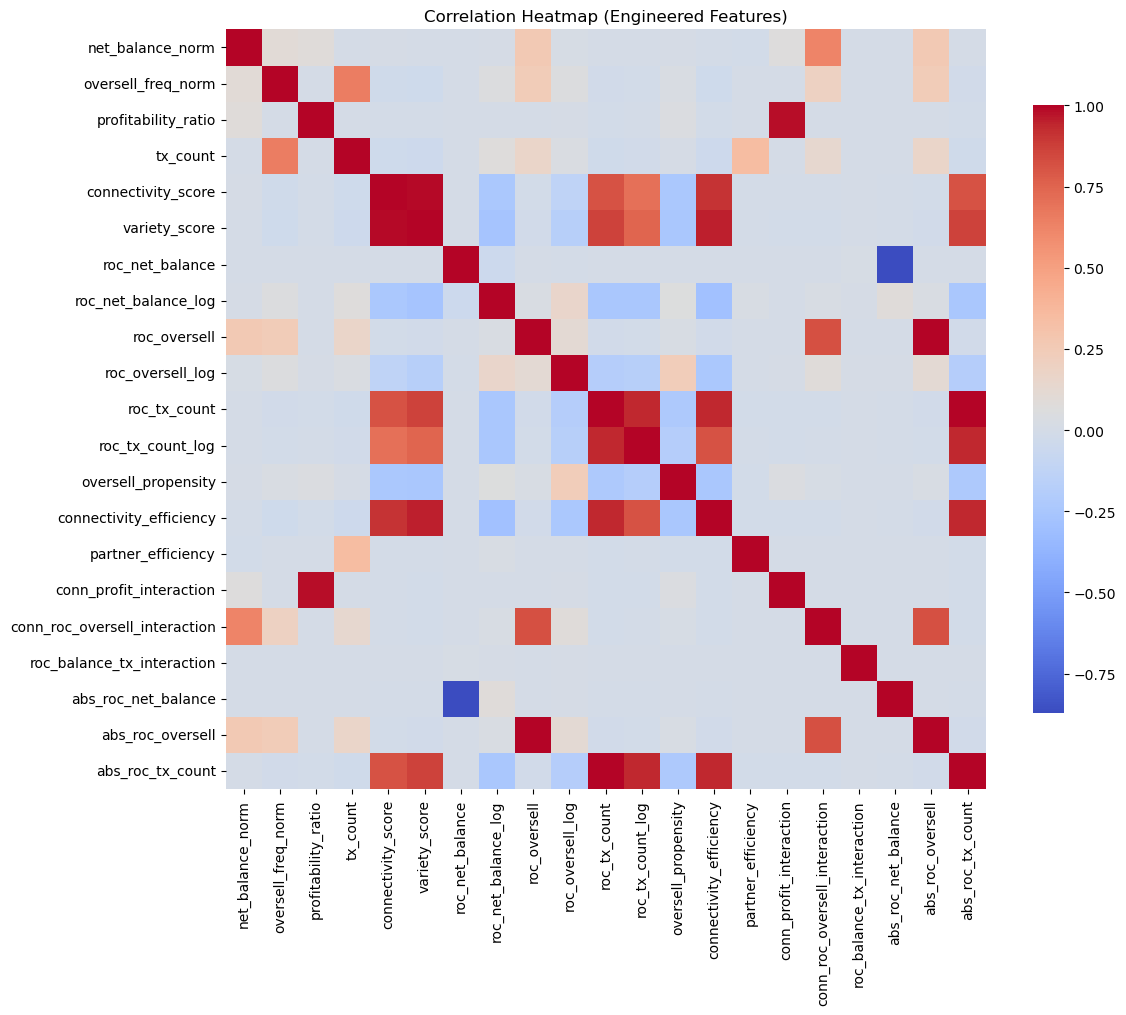

In [7]:
# Prepare engineered features
engineered = prepare_feature_columns("data/account_dynamics_burst_v1.csv")

# Join with your existing combined_df
burst_combined_df = raw_combined_df.join(engineered, on="account", how="inner").fill_null(0)

In [13]:
#combined_df.write_csv("data/combined_df_model_v5_with_null.csv")

## Psychological Features

In [8]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def compute_psych_indices(transactions_path: str, out_path: str) -> pl.DataFrame:
    """
    Compute psychological indices for accounts from a transactions CSV.
    Applies normalization/clipping to unstable features.
    Saves results to out_path as CSV and shows summary + heatmap.
    """

    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Int64,
            "gas_price": pl.Float64,
        },
        ignore_errors=True
    )

    # Parse datetime
    tx = tx.with_columns(
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ).filter(pl.col("ts").is_not_null())

    # Define account + direction
    tx = tx.with_columns([
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.col("from_account"))
          .otherwise(pl.col("to_account"))
          .alias("account"),
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.lit("A"))
          .otherwise(pl.lit("B"))
          .alias("direction")
    ]).sort(["account","ts"])

    # --- 1. Shock Score ---
    tx = tx.with_columns(
        pl.col("gas_price").diff().over("account").alias("gas_price_change")
    )
    shock = (
        tx.group_by("account")
          .agg([
              (
                  pl.when((pl.col("direction")=="A") & (pl.col("gas_price_change") < -0.05*pl.col("gas_price")))
                   .then(1.0)
                   .when((pl.col("direction")=="B") & (pl.col("gas_price_change") > 0.05*pl.col("gas_price")))
                   .then(1.0)
                   .otherwise(0.0)
              ).mean().alias("shock_score")
          ])
    )

    # --- 2. Momentum Score ---
    momentum = (
        tx.group_by("account")
          .agg([
              (
                  pl.when((pl.col("direction")=="B") & (pl.col("gas_price_change") > 0))
                   .then(pl.col("gas_price_change"))
                   .otherwise(0.0)
              ).mean().alias("momentum_score")
          ])
    )

    # --- 3. Pair Score (weighted proximity within 24 min) ---
    tx = tx.with_columns(
        pl.col("ts").diff().over("account").dt.total_seconds().alias("iat_secs")
    )
    pair_score = (
        tx.group_by("account")
          .agg([
              (
                  pl.when(pl.col("iat_secs").is_between(0, 600))     # 0–10 min
                   .then(1.0)
                   .when(pl.col("iat_secs").is_between(600, 1080))   # 10–18 min
                   .then(0.6)
                   .when(pl.col("iat_secs").is_between(1080, 1440))  # 18–24 min
                   .then(0.3)
                   .otherwise(0.0)
              ).mean().alias("pair_score"),
              (pl.col("iat_secs").is_between(0,600).any().cast(pl.Int8)).alias("has_10min_pair")
          ])
    )

    # --- 4. Inefficiency Score ---
    ineff = (
        tx.group_by("account")
          .agg([
              (
                  pl.when((pl.col("direction")=="B") & (pl.col("value")>0))
                   .then(-1.0)
                   .when((pl.col("direction")=="A") & (pl.col("value")>0))
                   .then(1.0)
                   .otherwise(0.0)
              ).sum().alias("inefficiency_score")
          ])
    )

    # --- 5. Habit Score ---
    tx = tx.with_columns(pl.col("ts").dt.hour().alias("hour"))
    time_bucket_expr = (
        pl.when(pl.col("hour").is_between(7, 9)).then(pl.lit("morning"))
        .when(pl.col("hour").is_between(12, 14)).then(pl.lit("afternoon"))
        .when(pl.col("hour").is_between(16, 18)).then(pl.lit("evening"))
        .when(pl.col("hour").is_between(20, 22)).then(pl.lit("night"))
        .otherwise(pl.lit("other"))
    )
    tx = tx.with_columns(time_bucket_expr.alias("time_bucket"))
    bucket_counts = (
        tx.group_by(["account","time_bucket"])
          .agg(pl.len().alias("count"))
    )
    habit = (
        bucket_counts.group_by("account")
          .agg([
              pl.col("time_bucket").n_unique().alias("bucket_coverage"),
              (pl.col("count")/pl.col("count").sum()).pow(2).sum().alias("concentration")
          ])
          .with_columns(
              (pl.col("bucket_coverage")/4 * (1 - pl.col("concentration"))).alias("habit_score")
          )
          .select(["account","habit_score"])
    )

    # --- 6. Roundness Score ---
    tx = tx.with_columns((pl.col("gas") % 1000).alias("gas_mod1000"))
    roundness = (
        tx.group_by("account")
          .agg([
              (
                  pl.when(pl.col("gas_mod1000")<=5).then(1.0)
                   .when(pl.col("gas_mod1000")<=50).then(0.8)
                   .otherwise(0.2)
              ).mean().alias("roundness_score")
          ])
    )

    # --- 7. Reinvestment Score ---
    tx = tx.with_columns([
        pl.col("direction").shift(-1).over("account").alias("next_dir"),
        pl.col("ts").shift(-1).over("account").alias("next_ts")
    ])
    tx = tx.with_columns((pl.col("next_ts") - pl.col("ts")).dt.total_seconds().alias("delta_next"))
    reinvest = (
        tx.group_by("account")
          .agg([
              (
                  pl.when((pl.col("direction")=="A") & (pl.col("next_dir")=="B") & (pl.col("delta_next") <= 600))
                   .then(1.0)
                   .when((pl.col("direction")=="A") & (pl.col("next_dir")=="B") & (pl.col("delta_next") > 600) & (pl.col("delta_next") <= 1080))
                   .then(0.6)
                   .when((pl.col("direction")=="A") & (pl.col("next_dir")=="B") & (pl.col("delta_next") > 1080) & (pl.col("delta_next") <= 1440))
                   .then(0.3)
                   .otherwise(0.0)
              ).mean().alias("reinvestment_score")
          ])
    )

    # --- 8. Dormancy Gap Ratio ---
    lifetime = (
        tx.group_by("account")
          .agg([
              (pl.col("ts").max() - pl.col("ts").min()).dt.total_days().alias("lifespan_days"),
              pl.len().alias("tx_count")
          ])
          .with_columns(
              (pl.col("lifespan_days") / (1 + pl.col("tx_count"))).alias("dormancy_gap_ratio")
          )
          .select(["account","dormancy_gap_ratio"])
    )

    # --- 9. Day Sell Value Dispersion ---
    day_disp = (
        tx.filter(pl.col("direction")=="A")  # sells
          .with_columns(pl.col("ts").dt.date().alias("day"))
          .group_by(["account","day"])
          .agg([
              (pl.col("value").quantile(0.75) - pl.col("value").quantile(0.25)).alias("iqr"),
              pl.col("value").median().alias("median_val")
          ])
          .with_columns((pl.col("iqr")/(pl.col("median_val")+1e-9)).alias("dispersion"))
          .group_by("account")
          .agg(pl.col("dispersion").median().alias("day_sell_value_dispersion"))
    )

    # --- 10. Opportunistic Pair Diff Ratio ---
    opp_pair = (
        tx.with_columns(pl.col("ts").dt.date().alias("day"))
          .group_by(["account","day"])
          .agg([
              ((pl.col("value").max() - pl.col("value").min())/(pl.col("value").mean()+1e-9))
              .alias("pair_diff_ratio")
          ])
          .group_by("account")
          .agg(pl.col("pair_diff_ratio").mean().alias("opportunistic_pair_diff_ratio"))
    )

    # --- 11. Burst Uniformity Ratio ---
    burst = (
        tx.with_columns([
            pl.col("iat_secs").alias("interval"),
            pl.col("ts").dt.date().alias("day")
        ])
          .group_by(["account","day"])
          .agg([
              (pl.col("interval")<=60).sum().alias("burst_count"),
              pl.col("value").std().alias("value_std")
          ])
          .with_columns(
              ((pl.col("burst_count")>=5) & (pl.col("value_std")<1e-6)).cast(pl.Int8).alias("burst_flag")
          )
          .group_by("account")
          .agg(pl.col("burst_flag").mean().alias("burst_uniformity_ratio"))
    )

    # --- 12. Short Lifespan Activity Ratio ---
    lifespan = (
        tx.group_by("account")
          .agg([
              (pl.col("ts").max() - pl.col("ts").min()).dt.total_days().alias("lifespan_days"),
              pl.col("ts").dt.date().n_unique().alias("active_days")
          ])
          .with_columns((pl.col("active_days")/(1+pl.col("lifespan_days"))).alias("short_lifespan_activity_ratio"))
          .select(["account","short_lifespan_activity_ratio"])
    )

    # --- 13. Near Round Gas Pair Rate ---
    near_round = (
        tx.group_by("account")
          .agg(((pl.col("gas").is_in([21000,21001])).mean()).alias("near_round_gas_pair_rate"))
    )

    # --- 14. Buy Propensity Ratio ---
    # --- 14. Buy Propensity Split ---
    buy_prop = (
        tx.group_by("account")
          .agg([
              (pl.col("direction")=="B").sum().alias("buys"),
              (pl.col("direction")=="A").sum().alias("sells")
          ])
          .with_columns([
              (pl.col("buys")/(pl.col("buys")+pl.col("sells")+1e-9)).alias("buy_ratio_continuous"),
              ((pl.col("sells")==0) & (pl.col("buys")>0)).cast(pl.Int8).alias("buy_only_flag"),
              ((pl.col("buys")==0) & (pl.col("sells")>0)).cast(pl.Int8).alias("sell_only_flag")
          ])
          .select(["account","buy_ratio_continuous","buy_only_flag","sell_only_flag"])
    )

    # --- Merge all features using pandas to avoid duplicate key issues ---
    feature_frames = [
        shock, momentum, pair_score, ineff, habit, roundness, reinvest,
        lifetime, day_disp, opp_pair, burst, lifespan, near_round, buy_prop
    ]
    feature_frames_pd = [f.to_pandas() for f in feature_frames]

    features_pd = feature_frames_pd[0]
    for f in feature_frames_pd[1:]:
        features_pd = features_pd.merge(f, on="account", how="outer")

    # Fill NaNs before normalization
    features_pd = features_pd.fillna(0)

    # --- Normalization / Clipping ---
    features_pd["momentum_score_log"] = np.log1p(np.clip(features_pd["momentum_score"], 0, None))
    features_pd["inefficiency_score_clipped"] = np.clip(features_pd["inefficiency_score"], -100, 100)
    features_pd["dormancy_gap_ratio_norm"] = np.log1p(np.clip(features_pd["dormancy_gap_ratio"], 0, None))
    features_pd["day_sell_value_dispersion_norm"] = np.log1p(np.clip(features_pd["day_sell_value_dispersion"], 0, 1e6))
    features_pd["opportunistic_pair_diff_ratio_norm"] = np.log1p(np.clip(features_pd["opportunistic_pair_diff_ratio"], 0, 1e6))

    # --- Composite Indices (updated with split buy features and normalisation) ---
    # Goodness composite
    features_pd["good_psy_index"] = (
        2.0*features_pd["has_10min_pair"] +
        2.5*features_pd["pair_score"] +
        0.6*features_pd["reinvestment_score"] +
        0.8*features_pd["habit_score"] +
        # reward buy-only accounts slightly (long-term investors)
        0.4*features_pd["buy_only_flag"] +
        # reward balanced buy/sell ratio (close to 0.5)
        0.4*(1 - np.abs(features_pd["buy_ratio_continuous"] - 0.5)) -
        # penalize instability in habits
        0.5*(1 - features_pd["habit_score"])
    )

    # Badness composite
    features_pd["bad_psy_index"] = (
        0.9*features_pd["burst_uniformity_ratio"] +
        0.8*features_pd["near_round_gas_pair_rate"] +
        0.5*features_pd["day_sell_value_dispersion_norm"] +  # noisy but useful
        0.7*features_pd["dormancy_gap_ratio_norm"] +
        0.35*features_pd["opportunistic_pair_diff_ratio_norm"] +  # noisy but useful
        0.5*features_pd["short_lifespan_activity_ratio"] +
        # penalize sell-only accounts more strongly
        0.4*features_pd["sell_only_flag"] +
        # penalize extreme buy/sell imbalance (close to 0 or 1)
        0.2*(np.abs(features_pd["buy_ratio_continuous"] - 0.5))
    )

    # Net index
    features_pd["psychological_index_net"] = (
        features_pd["good_psy_index"] - features_pd["bad_psy_index"]
    )

    # Convert back to Polars
    features = pl.from_pandas(features_pd).fill_null(0)

    # Save outward
    features.write_csv(out_path)

    # --- Summary ---
    pdf = features.to_pandas()
    print("\n=== Psychological Indices Summary ===")
    print(pdf.describe().transpose())

    # --- Heatmap ---
    corr = pdf.drop(columns=["account"]).corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)
    plt.title("Correlation Heatmap (Psychological Indices)")
    plt.tight_layout()
    plt.show()

    return features

In [30]:
#features_psy.head(5)


=== Psychological Indices Summary ===
                                      count          mean           std  \
shock_score                         31491.0  2.730070e-01  2.123985e-01   
momentum_score                      31491.0  3.461527e+09  8.014304e+09   
pair_score                          31491.0  2.844060e-01  2.428101e-01   
has_10min_pair                      31491.0  7.559303e-01  4.295411e-01   
inefficiency_score                  31491.0 -1.792258e+00  5.570759e+02   
habit_score                         31491.0  4.740024e-01  3.235153e-01   
roundness_score                     31491.0  8.546492e-01  2.196093e-01   
reinvestment_score                  31491.0  8.766034e-03  2.878392e-02   
dormancy_gap_ratio                  31491.0  1.003143e+01  2.015668e+01   
day_sell_value_dispersion           31491.0  3.141171e+25  2.607123e+27   
opportunistic_pair_diff_ratio       31491.0  1.039699e+00  3.663865e+00   
burst_uniformity_ratio              31491.0  3.773492e-03  3.

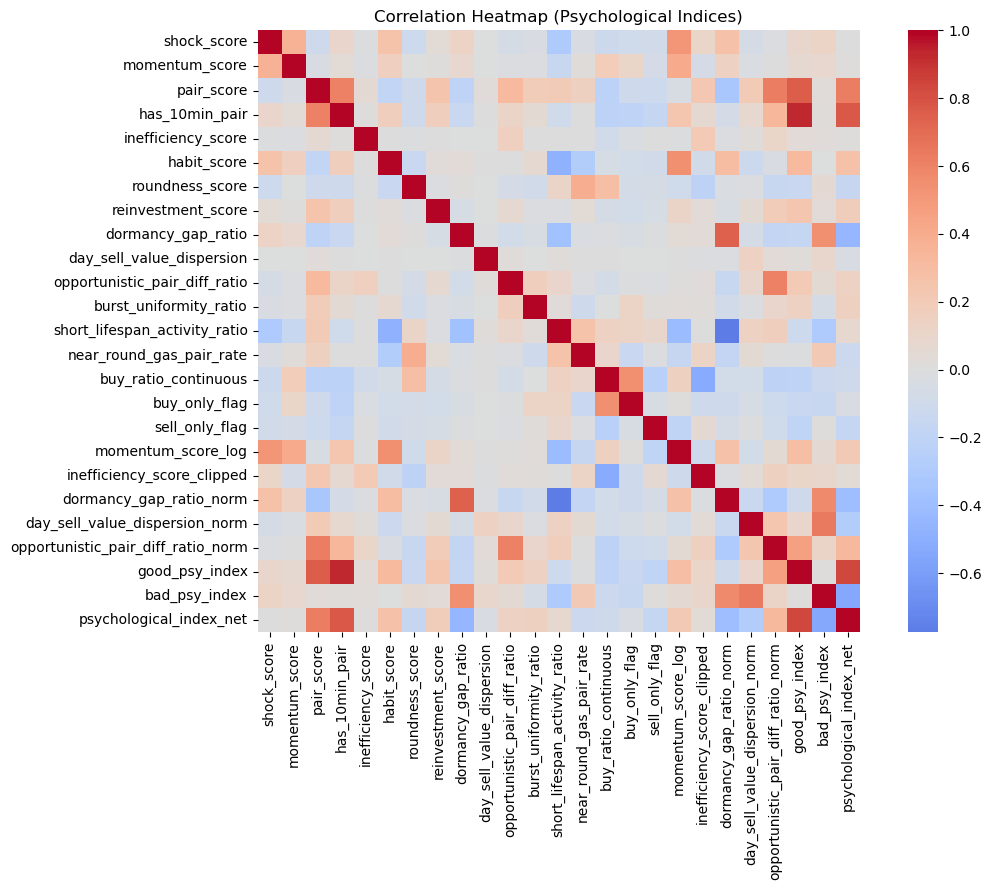

In [9]:
# Prepare pschology features
features_psy = compute_psych_indices(
    transactions_path="data/transactions.csv",
    out_path="data/psych_idx_v2.1.csv"
)

# Join with your existing combined_df
#psych_combined_df = burst_combined_df.join(features_psy, on="account", how="inner").fill_null(0)
combined_df = burst_combined_df.join(features_psy, on="account", how="inner").fill_null(0)

              precision    recall  f1-score   support

        good       0.97      0.81      0.89     15912
         bad       0.31      0.79      0.45      1724

    accuracy                           0.81     17636
   macro avg       0.64      0.80      0.67     17636
weighted avg       0.91      0.81      0.84     17636



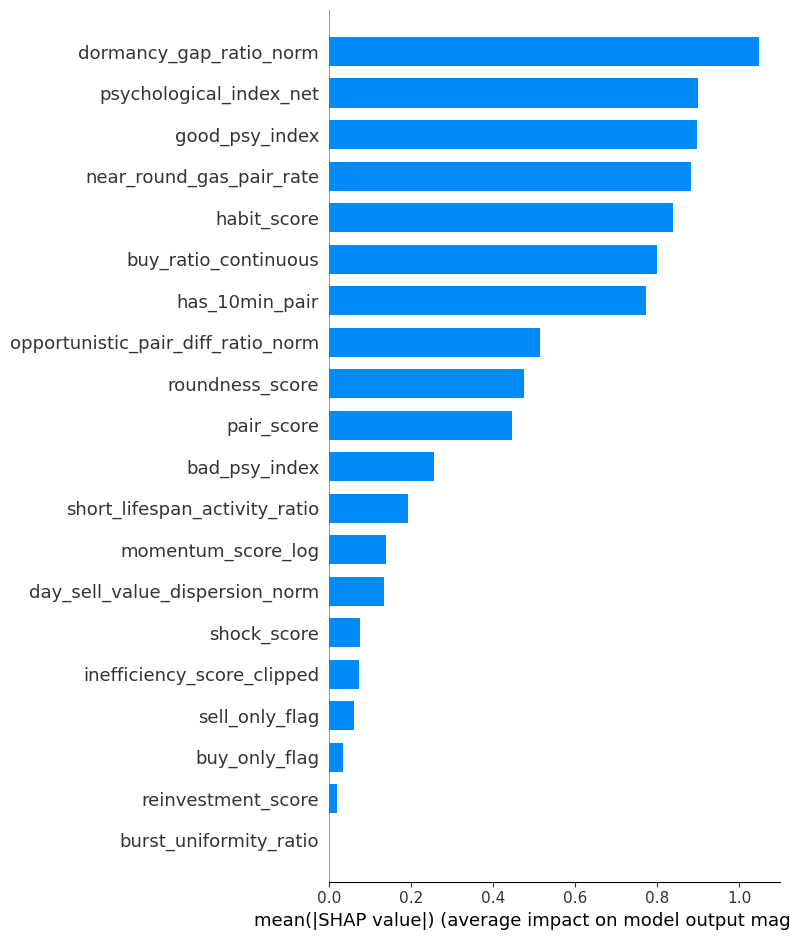

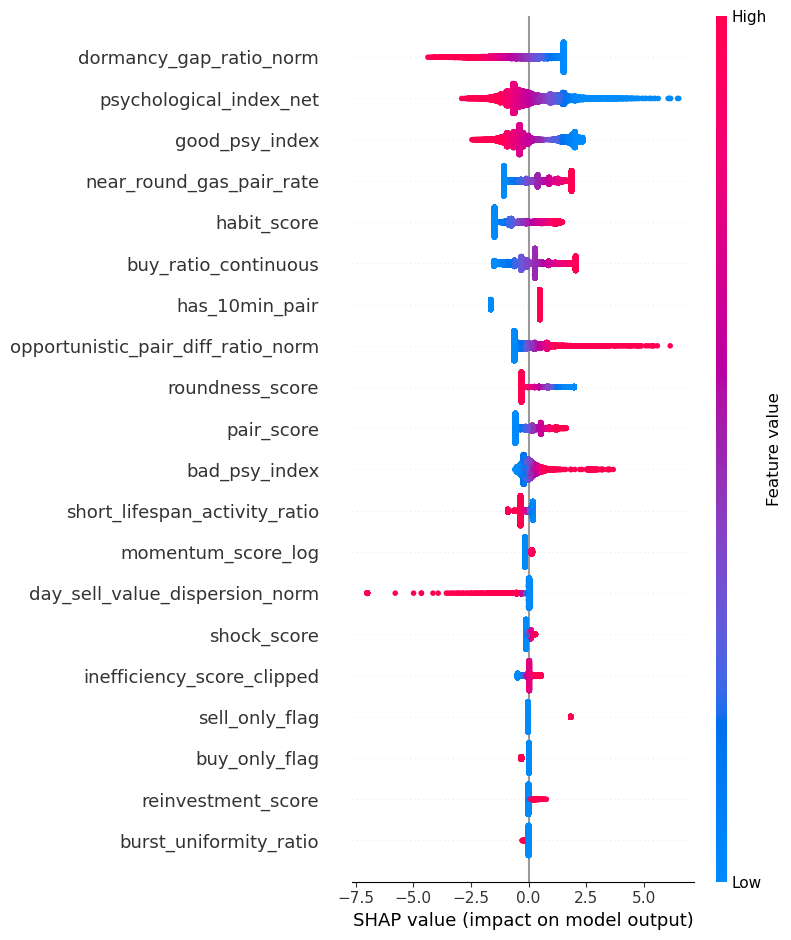

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt

# --- Load engineered features ---
features = pd.read_csv("data/psych_idx_v2.1.csv")   # output from compute_psych_indices
labels = pd.read_csv("data/train_acc.csv")    # [account, flag]

# Merge on account
df = features.merge(labels, on="account", how="inner")

# Select feature columns (exclude account + raw unstable ones)
psy_cols = [
    "shock_score", "momentum_score_log", "pair_score", "has_10min_pair",
    "inefficiency_score_clipped", "habit_score", "roundness_score",
    "reinvestment_score", "dormancy_gap_ratio_norm",
    "day_sell_value_dispersion_norm", "opportunistic_pair_diff_ratio_norm",
    "burst_uniformity_ratio", "short_lifespan_activity_ratio",
    "near_round_gas_pair_rate",
    # --- new split buy features ---
    "buy_ratio_continuous", "buy_only_flag", "sell_only_flag",
    # --- composites ---
    "good_psy_index", "bad_psy_index", "psychological_index_net"
]

X = df[psy_cols].values
y = df["flag"].values

# --- Logistic regression with scaling ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
pipe.fit(X, y)

# --- Evaluate quickly ---
from sklearn.metrics import classification_report
print(classification_report(y, pipe.predict(X), target_names=["good","bad"]))

# --- SHAP analysis ---
explainer = shap.LinearExplainer(pipe.named_steps["clf"], pipe.named_steps["scaler"].transform(X))
shap_values = explainer.shap_values(pipe.named_steps["scaler"].transform(X))

# Summary plot (bar chart of mean absolute SHAP values)
shap.summary_plot(shap_values, df[psy_cols], plot_type="bar")

# Optional: detailed beeswarm plot
shap.summary_plot(shap_values, df[psy_cols])

In [49]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def freedman_diaconis_bin_width(x):
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    n = len(x)
    return 2 * iqr * (n ** (-1/3)) if n > 0 else 1.0

def compute_contextual_features(transactions_path: str, out_path: str) -> pl.DataFrame:
    """
    Compute contextual features for accounts from a transactions CSV.
    Includes partner ratios, temporal entropy/burstiness, 
    value/gas dynamics vs global, counterparty diversity, and flow balance.
    """

    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Int64,
            "gas_price": pl.Float64,
        },
        ignore_errors=True
    )

    # Parse datetime
    tx = tx.with_columns(
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ).filter(pl.col("ts").is_not_null())

    # Define account + direction
    tx = tx.with_columns([
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.col("from_account"))
          .otherwise(pl.col("to_account"))
          .alias("account"),
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.lit("A"))
          .otherwise(pl.lit("B"))
          .alias("direction")
    ]).sort(["account","ts"])

    # ============================================================
    # 1. Partner Type Ratios
    # ============================================================
    partner_counts = (
        tx.group_by("account")
          .agg([
              (pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("a")).cast(pl.Int8).sum().alias("a2a"),
              (pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("b")).cast(pl.Int8).sum().alias("a2b"),
              (pl.col("from_account").str.starts_with("b") & pl.col("to_account").str.starts_with("a")).cast(pl.Int8).sum().alias("b2a"),
              pl.len().alias("total_tx")
          ])
          .with_columns([
              (pl.col("a2a")/pl.col("total_tx")).alias("partner_ratio_a2a"),
              (pl.col("a2b")/pl.col("total_tx")).alias("partner_ratio_a2b"),
              (pl.col("b2a")/pl.col("total_tx")).alias("partner_ratio_b2a")
          ])
          .select(["account","partner_ratio_a2a","partner_ratio_a2b","partner_ratio_b2a"])
    )

    # ============================================================
    # 2. Temporal Features
    # ============================================================
    tx = tx.with_columns(pl.col("ts").diff().over("account").dt.total_seconds().alias("iat_secs"))

    temporal_rows = []
    for acc, g in tx.group_by("account"):
        arr = g["iat_secs"].drop_nulls().to_numpy()
        if len(arr) > 1:
            bw = freedman_diaconis_bin_width(arr)
            bins = np.arange(arr.min(), arr.max()+bw, bw) if bw > 0 else np.array([arr.min(), arr.max()])
            hist, _ = np.histogram(arr, bins=bins)
            p = hist / hist.sum() if hist.sum() > 0 else np.array([1.0])
            entropy = -np.sum(p * np.log(p + 1e-9))
            mu, sigma = arr.mean(), arr.std()
            burst = (sigma - mu) / (sigma + mu + 1e-9)
            steadiness = 1 - sigma/(mu+1e-9)
        else:
            entropy, burst, steadiness = 0.0, 0.0, 0.0
        temporal_rows.append({"account": acc, "iat_entropy": entropy,
                              "burstiness_index": burst, "steadiness_index": steadiness})
    temporal_feats = pd.DataFrame(temporal_rows)

    # ============================================================
    # 3. Value & Gas Dynamics
    # ============================================================
    tx = tx.with_columns(((pl.col("value")/(pl.col("gas")*pl.col("gas_price")+1e-9))).alias("vtgr"))

    value_gas_rows = []
    for acc, g in tx.group_by("account"):
        vals = g["value"].to_numpy()
        vtgr = g["vtgr"].to_numpy()
        gas_prices = g["gas_price"].to_numpy()

        if len(vals) > 0:
            mad = np.median(np.abs(vals - np.median(vals)))
            round_rate = np.mean([1 if (v % 1_000 == 0 or v % 100 == 0) else 0 for v in vals])
        else:
            mad, round_rate = 0.0, 0.0

        # Global deviation placeholder: here we just compute zscore vs global mean/std
        global_mean, global_std = tx["vtgr"].mean(), tx["vtgr"].std()
        if global_std > 0:
            vtgr_dev = np.mean(np.abs(vtgr - global_mean) / global_std)
        else:
            vtgr_dev = 0.0

        # Gas price stats
        if len(gas_prices) > 1:
            gp_cv = np.std(gas_prices) / (np.mean(gas_prices)+1e-9)
            bw = freedman_diaconis_bin_width(gas_prices)
            bins = np.arange(gas_prices.min(), gas_prices.max()+bw, bw) if bw > 0 else np.array([gas_prices.min(), gas_prices.max()])
            hist, _ = np.histogram(gas_prices, bins=bins)
            p = hist / hist.sum() if hist.sum() > 0 else np.array([1.0])
            gp_entropy = -np.sum(p * np.log(p + 1e-9))
        else:
            gp_cv, gp_entropy = 0.0, 0.0

        value_gas_rows.append({
            "account": acc,
            "value_mad": mad,
            "round_value_rate": round_rate,
            "vtgr_dev_global": vtgr_dev,
            "gas_price_cv": gp_cv,
            "gas_price_entropy": gp_entropy
        })
    value_gas_feats = pd.DataFrame(value_gas_rows)

    # ============================================================
    # 4. Counterparty Diversity
    # ============================================================
    counterparty_rows = []
    for acc, g in tx.group_by("account"):
        tos = g["to_account"].to_numpy()
        total = len(tos)
        if total > 0:
            unique_ratio = len(set(tos)) / total
            _, counts = np.unique(tos, return_counts=True)
            p = counts / counts.sum()
            entropy = -np.sum(p * np.log(p+1e-9))
        else:
            unique_ratio, entropy = 0.0, 0.0
        counterparty_rows.append({
            "account": acc,
            "unique_counterparty_ratio": unique_ratio,
            "counterparty_entropy": entropy
        })
    counterparty_feats = pd.DataFrame(counterparty_rows)

    # ============================================================
    # 5. Directional Asymmetry
    # ============================================================
    flow_rows = []
    for acc, g in tx.group_by("account"):
        vals = g["value"].to_numpy()
        dirs = g["direction"].to_numpy()
        value_in = vals[dirs=="B"].sum() if np.any(dirs=="B") else 0.0
        value_out = vals[dirs=="A"].sum() if np.any(dirs=="A") else 0.0
        n_in = np.sum(dirs=="B")
        n_out = np.sum(dirs=="A")
        net_flow = (value_in - value_out) / (value_in + value_out + 1e-9)
        in_out_ratio = (n_in+1e-9)/(n_out+1e-9)
        flow_sym = 1 - abs(net_flow)
        flow_rows.append({
            "account": acc,
            "net_flow_balance": net_flow,
            "in_out_ratio": in_out_ratio,
            "flow_symmetry_score": flow_sym
        })
    flow_feats = pd.DataFrame(flow_rows)

    # ============================================================
    # Merge all features
    # ============================================================
    feature_frames_pd = [
        partner_counts.to_pandas(),
        temporal_feats,
        value_gas_feats,
        counterparty_feats,
        flow_feats
    ]

    features_pd = feature_frames_pd[0]
    for f in feature_frames_pd[1:]:
        features_pd = features_pd.merge(f, on="account", how="outer")

    # Fill NaNs
    features_pd = features_pd.fillna(0)

    # ============================================================
    # Normalization / Clipping (if needed)
    # ============================================================
    # Example: log-transform entropy to stabilize scale
    features_pd["iat_entropy_norm"] = np.log1p(features_pd["iat_entropy"])
    features_pd["value_mad_log"] = np.log1p(features_pd["value_mad"])
    features_pd["vtgr_dev_global_log"] = np.log1p(features_pd["vtgr_dev_global"])

    # ============================================================
    # Convert back to Polars
    # ============================================================
    features = pl.from_pandas(features_pd).fill_null(0)

    # Save outward
    features.write_csv(out_path)

    # --- Summary ---
    pdf = features.to_pandas()
    print("\n=== Contextual Features Summary ===")
    print(pdf.describe().transpose())

    # --- Heatmap ---
    corr = pdf.drop(columns=["account"]).corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)
    plt.title("Correlation Heatmap (Contextual Features)")
    plt.tight_layout()
    plt.show()

    return features

In [13]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def freedman_diaconis_bins(x: np.ndarray):
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.array([0.0, 1.0])
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    n = len(x)
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        # fallback to Sturges or fixed bin count
        k = int(np.ceil(np.log2(n) + 1))
        return np.linspace(x.min(), x.max(), k + 1)
    k = int(np.ceil((x.max() - x.min()) / h))
    k = max(k, 1)
    return np.linspace(x.min(), x.max(), k + 1)

def compute_contextual_features(transactions_path: str, out_path: str) -> pl.DataFrame:
    """
    Compute contextual features with global precomputations and Polars aggregations:
    - Partner ratios
    - Temporal entropy/burstiness (global FD bins)
    - Value/gas dynamics vs global
    - Counterparty diversity (entropy)
    - Directional asymmetry
    """

    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Int64,
            "gas_price": pl.Float64,
        },
        ignore_errors=True
    )

    # Parse datetime
    tx = tx.with_columns(
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ).filter(pl.col("ts").is_not_null())

    # Define account + direction
    tx = tx.with_columns([
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.col("from_account"))
          .otherwise(pl.col("to_account"))
          .alias("account"),
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.lit("A"))
          .otherwise(pl.lit("B"))
          .alias("direction")
    ]).sort(["account","ts"])

    # ============================================================
    # Global precomputations (once)
    # ============================================================

    # Inter-arrival times (seconds)
    tx = tx.with_columns(
        pl.col("ts").diff().over("account").dt.total_seconds().alias("iat_secs")
    )

    # Value-to-gas ratio per transaction
    tx = tx.with_columns(
        (pl.col("value") / (pl.col("gas") * pl.col("gas_price") + 1e-9)).alias("vtgr")
    )

    # Collect globals to NumPy for binning
    iat_all = tx.select(pl.col("iat_secs")).drop_nulls().to_series().to_numpy()
    gp_all = tx.select(pl.col("gas_price")).drop_nulls().to_series().to_numpy()
    vtgr_all = tx.select(pl.col("vtgr")).drop_nulls().to_series().to_numpy()

    # Freedman–Diaconis global bins
    iat_bins = freedman_diaconis_bins(iat_all)
    gp_bins = freedman_diaconis_bins(gp_all)

    # Global VTGR mean/std
    vtgr_mean = float(np.mean(vtgr_all)) if vtgr_all.size > 0 else 0.0
    vtgr_std = float(np.std(vtgr_all)) if vtgr_all.size > 0 else 0.0

    # Broadcast bin edges into Polars as literals (for cut)
    iat_breaks = list(iat_bins)
    gp_breaks = list(gp_bins)

    # ============================================================
    # 1. Partner Type Ratios (vectorized)
    # ============================================================
    partner_counts = (
        tx.group_by("account")
        .agg([
            ((pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("a"))
                .cast(pl.Int8)
                .sum()
                .alias("a2a")),
            ((pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("b"))
                .cast(pl.Int8)
                .sum()
                .alias("a2b")),
            ((pl.col("from_account").str.starts_with("b") & pl.col("to_account").str.starts_with("a"))
                .cast(pl.Int8)
                .sum()
                .alias("b2a")),
            pl.len().alias("total_tx")
        ])
        .with_columns([
            (pl.col("a2a")/pl.col("total_tx")).alias("partner_ratio_a2a"),
            (pl.col("a2b")/pl.col("total_tx")).alias("partner_ratio_a2b"),
            (pl.col("b2a")/pl.col("total_tx")).alias("partner_ratio_b2a")
        ])
        .select(["account","partner_ratio_a2a","partner_ratio_a2b","partner_ratio_b2a","total_tx"])
    )

    # ============================================================
    # 2. Temporal Features (global bins, vectorized)
    # ============================================================
    # Bin iat into global bins (Polars cut)
    with pl.StringCache():
        tx_iat_binned = tx.with_columns(
            pl.when(pl.col("iat_secs").is_null())
            .then(pl.lit("NA"))
            .otherwise(pl.col("iat_secs").cut(breaks=iat_breaks, left_closed=True))
            .alias("iat_bin")
        )

    # Per-account, per-bin counts
    iat_counts = (
        tx_iat_binned.filter(pl.col("iat_bin").is_not_null())
          .group_by(["account","iat_bin"])
          .agg(pl.len().alias("bin_count"))
    )

    # Total iat count per account
    iat_totals = (
        tx_iat_binned.filter(pl.col("iat_secs").is_not_null())
          .group_by("account")
          .agg(pl.len().alias("iat_total"))
    )

    # Entropy = -sum(p * log p), with p = bin_count / iat_total
    iat_entropy = (
        iat_counts.join(iat_totals, on="account", how="inner")
          .with_columns((pl.col("bin_count") / (pl.col("iat_total") + 1e-9)).alias("p"))
          .with_columns((-pl.col("p") * (pl.col("p") + 1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("iat_entropy"))
    )

    # Burstiness and steadiness: need mean/std of iat per account
    iat_stats = (
        tx.filter(pl.col("iat_secs").is_not_null())
          .group_by("account")
          .agg([
              pl.mean("iat_secs").alias("iat_mean"),
              pl.std("iat_secs").alias("iat_std")
          ])
          .with_columns([
              ((pl.col("iat_std") - pl.col("iat_mean")) / (pl.col("iat_std") + pl.col("iat_mean") + 1e-9)).alias("burstiness_index"),
              (1 - (pl.col("iat_std") / (pl.col("iat_mean") + 1e-9))).alias("steadiness_index"),
          ])
          .select(["account","iat_mean","iat_std","burstiness_index","steadiness_index"])
    )

    temporal_feats = (
        iat_stats.join(iat_entropy, on="account", how="full")
                 .fill_null(0)
    )

    # ============================================================
    # 3. Value & Gas Dynamics (vectorized + global)
    # ============================================================

    # Value MAD and round value rate per account
    # MAD = median(|x - median(x)|)
    val_medians = tx.group_by("account").agg(pl.median("value").alias("value_median"))
    tx_with_med = tx.join(val_medians, on="account", how="left").with_columns(
        (pl.col("value") - pl.col("value_median")).abs().alias("abs_dev")
    )
    value_mad = (
        tx_with_med.group_by("account")
          .agg(pl.col("abs_dev").quantile(0.5, interpolation="nearest").alias("value_mad"))
    )

    # Round value rate (vectorized)
    is_round = (
        ((pl.col("value") % 1000) == 0) | ((pl.col("value") % 100) == 0)
    ).cast(pl.Int8)
    round_rate = (
        tx.with_columns(is_round.alias("is_round"))
          .group_by("account")
          .agg((pl.mean("is_round")).alias("round_value_rate"))
    )

    # VTGR deviation vs global (mean absolute z-score per account)
    vtgr_dev = (
        tx.with_columns(
            ((pl.col("vtgr") - vtgr_mean) / (vtgr_std + 1e-9)).abs().alias("vtgr_z")
        )
        .group_by("account")
        .agg(pl.mean("vtgr_z").alias("vtgr_dev_global"))
    )

    # Gas price CV and entropy per account using global FD bins
    with pl.StringCache():
        tx_gp_binned = tx.with_columns(
            pl.when(pl.col("gas_price").is_null())
            .then(pl.lit("NA"))
            .otherwise(pl.col("gas_price").cut(breaks=gp_breaks, left_closed=True))
            .alias("gp_bin")
        )
    gp_counts = (
        tx_gp_binned.filter(pl.col("gp_bin").is_not_null())
          .group_by(["account","gp_bin"])
          .agg(pl.len().alias("gp_bin_count"))
    )
    gp_totals = (
        tx_gp_binned.filter(pl.col("gas_price").is_not_null())
          .group_by("account")
          .agg(pl.len().alias("gp_total"))
    )
    gp_entropy = (
        gp_counts.join(gp_totals, on="account", how="inner")
          .with_columns((pl.col("gp_bin_count") / (pl.col("gp_total") + 1e-9)).alias("p"))
          .with_columns((-pl.col("p") * (pl.col("p") + 1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("gas_price_entropy"))
    )
    gp_cv = (
        tx.filter(pl.col("gas_price").is_not_null())
          .group_by("account")
          .agg((pl.std("gas_price") / (pl.mean("gas_price") + 1e-9)).alias("gas_price_cv"))
    )

    # Convert each to pandas
    value_mad_pd = value_mad.to_pandas()
    round_rate_pd = round_rate.to_pandas()
    vtgr_dev_pd = vtgr_dev.to_pandas()
    gp_cv_pd = gp_cv.to_pandas()
    gp_entropy_pd = gp_entropy.to_pandas()

    # Merge in pandas
    value_gas_feats_pd = value_mad_pd.merge(round_rate_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(vtgr_dev_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(gp_cv_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(gp_entropy_pd, on="account", how="outer")

    # Fill NaNs
    value_gas_feats_pd = value_gas_feats_pd.fillna(0)

    # Convert back to Polars
    value_gas_feats = pl.from_pandas(value_gas_feats_pd)
    
    #value_gas_feats = (
    #    value_mad.join(round_rate, on="account", how="outer")
    #             .join(vtgr_dev, on="account", how="outer")
    #             .join(gp_cv, on="account", how="outer")
    #             .join(gp_entropy, on="account", how="outer")
    #             .fill_null(0)
    #)

    # ============================================================
    # 4. Counterparty Diversity (vectorized entropy)
    # ============================================================
    # Count per (account, to_account)
    acc_to_counts = (
        tx.group_by(["account","to_account"])
          .agg(pl.len().alias("cnt"))
    )
    # Total per account
    acc_totals = (
        tx.group_by("account")
          .agg(pl.len().alias("total_tx"))
    )
    # Entropy = -sum (cnt/total) * log(cnt/total)
    counterparty_entropy = (
        acc_to_counts.join(acc_totals, on="account", how="inner")
          .with_columns((pl.col("cnt") / (pl.col("total_tx") + 1e-9)).alias("p"))
          .with_columns((-pl.col("p") * (pl.col("p") + 1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("counterparty_entropy"))
    )
    # Unique counterparty ratio
    unique_counterparty_ratio = (
        acc_to_counts.group_by("account")
          .agg([
              pl.len().alias("unique_to"),
              # we need total_tx to compute ratio; join later
          ])
    )
    unique_counterparty_ratio = unique_counterparty_ratio.join(acc_totals, on="account", how="left").with_columns(
        (pl.col("unique_to") / (pl.col("total_tx") + 1e-9)).alias("unique_counterparty_ratio")
    ).select(["account","unique_counterparty_ratio"])

    counterparty_feats = (
        unique_counterparty_ratio.join(counterparty_entropy, on="account", how="full")
                                 .fill_null(0)
    )

    # ============================================================
    # 5. Directional Asymmetry (vectorized)
    # ============================================================
    flow_feats = (
        tx.group_by("account")
        .agg([
            (pl.when(pl.col("direction")=="B")
                .then(pl.col("value"))
                .otherwise(0.0)
                .sum()
                .alias("value_in")),
            (pl.when(pl.col("direction")=="A")
                .then(pl.col("value"))
                .otherwise(0.0)
                .sum()
                .alias("value_out")),
            ((pl.col("direction")=="B").cast(pl.Int8).sum().alias("n_in")),
            ((pl.col("direction")=="A").cast(pl.Int8).sum().alias("n_out")),
        ])
        .with_columns([
            ((pl.col("value_in") - pl.col("value_out")) /
            (pl.col("value_in") + pl.col("value_out") + 1e-9)).alias("net_flow_balance"),
            ((pl.col("n_in") + 1e-9) / (pl.col("n_out") + 1e-9)).alias("in_out_ratio"),
        ])
        .with_columns([
            (1 - pl.col("net_flow_balance").abs()).alias("flow_symmetry_score")
        ])
        .select(["account","net_flow_balance","in_out_ratio","flow_symmetry_score"])
    )

    # ============================================================
    # Merge all features (use pandas, then convert back to Polars)
    # ============================================================

    # Convert each Polars frame to pandas and clean up any suffixes
    feature_frames_pd = []
    for f in [partner_counts, temporal_feats, value_gas_feats, counterparty_feats, flow_feats]:
        f_pd = f.to_pandas()
        # Drop any accidental suffix columns
        f_pd = f_pd.loc[:, ~f_pd.columns.str.contains("account_right|_x|_y|_right")]
        feature_frames_pd.append(f_pd)

    # Merge sequentially in pandas
    features_pd = feature_frames_pd[0]
    for f in feature_frames_pd[1:]:
        features_pd = features_pd.merge(f, on="account", how="outer")

    # Fill NaNs and enforce types
    features_pd = features_pd.fillna(0)
    features_pd["account"] = features_pd["account"].astype(str)
    for col in features_pd.columns:
        if col != "account":
            features_pd[col] = pd.to_numeric(features_pd[col], errors="coerce")
    features_pd = features_pd.fillna(0)

    # Normalization / Clipping
    features_pd["iat_entropy_norm"] = np.log1p(features_pd["iat_entropy"])
    features_pd["value_mad_log"] = np.log1p(features_pd["value_mad"])
    features_pd["vtgr_dev_global_log"] = np.log1p(features_pd["vtgr_dev_global"])

    # Convert back to Polars
    features = pl.from_pandas(features_pd)

    # Save outward
    features.write_csv(out_path)

    # --- Summary ---
    pdf = features.to_pandas()
    print("\n=== Contextual Features Summary ===")
    print(pdf.describe().transpose())

    # --- Heatmap ---
    corr = pdf.drop(columns=["account"]).corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)
    plt.title("Correlation Heatmap (Contextual Features)")
    plt.tight_layout()
    plt.show()

    return features

## Contextual Features (Discarded)

In [9]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def freedman_diaconis_bins(x: np.ndarray):
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.array([0.0, 1.0])
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    n = len(x)
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        k = int(np.ceil(np.log2(n) + 1))
        return np.linspace(x.min(), x.max(), k + 1)
    k = int(np.ceil((x.max() - x.min()) / h))
    k = max(k, 1)
    return np.linspace(x.min(), x.max(), k + 1)

def compute_contextual_features(transactions_path: str, out_path: str) -> pl.DataFrame:
    """Compute contextual features with global precomputations and Polars aggregations."""

    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Int64,
            "gas_price": pl.Float64,
        },
        ignore_errors=True
    )

    # Parse datetime
    tx = tx.with_columns(
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ).filter(pl.col("ts").is_not_null())

    # Define account + direction
    tx = tx.with_columns([
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.col("from_account"))
          .otherwise(pl.col("to_account"))
          .alias("account"),
        pl.when(pl.col("from_account").str.starts_with("a"))
          .then(pl.lit("A"))
          .otherwise(pl.lit("B"))
          .alias("direction")
    ]).sort(["account","ts"])

    # ============================================================
    # Global precomputations
    # ============================================================
    tx = tx.with_columns([
        pl.col("ts").diff().over("account").dt.total_seconds().alias("iat_secs"),
        (pl.col("value") / (pl.col("gas")*pl.col("gas_price")+1e-9)).alias("vtgr")
    ])

    iat_all = tx["iat_secs"].drop_nulls().to_numpy()
    gp_all = tx["gas_price"].drop_nulls().to_numpy()
    vtgr_all = tx["vtgr"].drop_nulls().to_numpy()

    iat_bins = freedman_diaconis_bins(iat_all)
    gp_bins = freedman_diaconis_bins(gp_all)
    vtgr_mean, vtgr_std = float(np.mean(vtgr_all)), float(np.std(vtgr_all))

    # ============================================================
    # 1. Partner Type Ratios
    # ============================================================
    partner_counts = (
        tx.group_by("account")
          .agg([
              ((pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("a"))
                 .cast(pl.Int8).sum().alias("a2a")),
              ((pl.col("from_account").str.starts_with("a") & pl.col("to_account").str.starts_with("b"))
                 .cast(pl.Int8).sum().alias("a2b")),
              ((pl.col("from_account").str.starts_with("b") & pl.col("to_account").str.starts_with("a"))
                 .cast(pl.Int8).sum().alias("b2a")),
              pl.len().alias("total_tx")
          ])
          .with_columns([
              (pl.col("a2a")/pl.col("total_tx")).alias("partner_ratio_a2a"),
              (pl.col("a2b")/pl.col("total_tx")).alias("partner_ratio_a2b"),
              (pl.col("b2a")/pl.col("total_tx")).alias("partner_ratio_b2a")
          ])
    )

    # ============================================================
    # 2. Temporal Features
    # ============================================================
    with pl.StringCache():
        tx_iat_binned = tx.with_columns(
            pl.col("iat_secs").cut(breaks=list(iat_bins), left_closed=True).cast(pl.Utf8).alias("iat_bin")
        )

    iat_counts = (
        tx_iat_binned.filter(pl.col("iat_bin").is_not_null())
          .group_by(["account","iat_bin"])
          .agg(pl.len().alias("bin_count"))
    )
    iat_totals = (
        tx.filter(pl.col("iat_secs").is_not_null())
          .group_by("account")
          .agg(pl.len().alias("iat_total"))
    )
    iat_entropy = (
        iat_counts.join(iat_totals, on="account", how="inner")
          .with_columns((pl.col("bin_count")/(pl.col("iat_total")+1e-9)).alias("p"))
          .with_columns((-pl.col("p")*(pl.col("p")+1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("iat_entropy"))
          .with_columns(pl.col("iat_entropy").clip(0, None))
    )
    iat_stats = (
        tx.filter(pl.col("iat_secs").is_not_null())
          .group_by("account")
          .agg([
              pl.mean("iat_secs").alias("iat_mean"),
              pl.std("iat_secs").alias("iat_std")
          ])
          .with_columns([
              ((pl.col("iat_std")-pl.col("iat_mean"))/(pl.col("iat_std")+pl.col("iat_mean")+1e-9))
                .clip(-5,5).alias("burstiness_index"),
              (1-(pl.col("iat_std")/(pl.col("iat_mean")+1e-3)))
                .clip(-5,5).alias("steadiness_index")
          ])
    )
    temporal_feats = iat_stats.join(iat_entropy, on="account", how="full").fill_null(0)

    # ============================================================
    # 3. Value & Gas Dynamics
    # ============================================================
    val_medians = tx.group_by("account").agg(pl.median("value").alias("value_median"))
    tx_with_med = tx.join(val_medians, on="account", how="left").with_columns(
        (pl.col("value") - pl.col("value_median")).abs().alias("abs_dev")
    )
    value_mad = tx_with_med.group_by("account").agg(
        pl.col("abs_dev").quantile(0.5, interpolation="nearest").alias("value_mad")
    )

    round_rate = tx.with_columns(
        (((pl.col("value") % 1000 == 0) | (pl.col("value") % 100 == 0)).cast(pl.Int8)).alias("is_round")
    ).group_by("account").agg(pl.mean("is_round").alias("round_value_rate"))

    vtgr_dev = tx.with_columns(
        ((pl.col("vtgr") - vtgr_mean) / (vtgr_std + 1e-9)).abs().alias("vtgr_z")
    ).group_by("account").agg(pl.mean("vtgr_z").alias("vtgr_dev_global"))

    gp_cv = tx.group_by("account").agg(
        (pl.std("gas_price") / (pl.mean("gas_price") + 1e-9)).alias("gas_price_cv")
    )

    with pl.StringCache():
        tx_gp_binned = tx.with_columns(
            pl.col("gas_price").cut(breaks=list(gp_bins), left_closed=True).cast(pl.Utf8).alias("gp_bin")
        )

    gp_counts = (
        tx_gp_binned.filter(pl.col("gp_bin").is_not_null())
          .group_by(["account", "gp_bin"])
          .agg(pl.len().alias("gp_bin_count"))
    )
    gp_totals = (
        tx.filter(pl.col("gas_price").is_not_null())
          .group_by("account")
          .agg(pl.len().alias("gp_total"))
    )
    gp_entropy = (
        gp_counts.join(gp_totals, on="account", how="inner")
          .with_columns((pl.col("gp_bin_count") / (pl.col("gp_total") + 1e-9)).alias("p"))
          .with_columns((-pl.col("p") * (pl.col("p") + 1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("gas_price_entropy"))
          .with_columns(pl.col("gas_price_entropy").clip(0, None))
    )

    # Convert each to pandas and merge
    value_mad_pd = value_mad.to_pandas()
    round_rate_pd = round_rate.to_pandas()
    vtgr_dev_pd = vtgr_dev.to_pandas()
    gp_cv_pd = gp_cv.to_pandas()
    gp_entropy_pd = gp_entropy.to_pandas()

    value_gas_feats_pd = value_mad_pd.merge(round_rate_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(vtgr_dev_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(gp_cv_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.merge(gp_entropy_pd, on="account", how="outer")
    value_gas_feats_pd = value_gas_feats_pd.fillna(0)

    value_gas_feats = pl.from_pandas(value_gas_feats_pd)

    # ============================================================
    # 4. Counterparty Diversity
    # ============================================================
    acc_to_counts = tx.group_by(["account", "to_account"]).agg(pl.len().alias("cnt"))
    acc_totals = tx.group_by("account").agg(pl.len().alias("total_tx"))

    counterparty_entropy = (
        acc_to_counts.join(acc_totals, on="account", how="inner")
          .with_columns((pl.col("cnt") / (pl.col("total_tx") + 1e-9)).alias("p"))
          .with_columns((-pl.col("p") * (pl.col("p") + 1e-9).log()).alias("p_log_p"))
          .group_by("account")
          .agg(pl.sum("p_log_p").alias("counterparty_entropy"))
          .with_columns(pl.col("counterparty_entropy").clip(0, None))
    )

    unique_counterparty_ratio = (
        acc_to_counts.group_by("account").agg(pl.len().alias("unique_to"))
          .join(acc_totals, on="account", how="left")
          .with_columns((pl.col("unique_to") / (pl.col("total_tx") + 1e-9)).alias("unique_counterparty_ratio"))
          .select(["account", "unique_counterparty_ratio"])
    )

    counterparty_feats = (
        unique_counterparty_ratio.join(counterparty_entropy, on="account", how="full").fill_null(0)
    )

    # ============================================================
    # 5. Directional Asymmetry
    # ============================================================
    flow_feats = (
        tx.group_by("account")
          .agg([
              (pl.when(pl.col("direction") == "B").then(pl.col("value")).otherwise(0.0).sum().alias("value_in")),
              (pl.when(pl.col("direction") == "A").then(pl.col("value")).otherwise(0.0).sum().alias("value_out")),
              ((pl.col("direction") == "B").cast(pl.Int8).sum().alias("n_in")),
              ((pl.col("direction") == "A").cast(pl.Int8).sum().alias("n_out")),
          ])
          .with_columns([
              ((pl.col("value_in") - pl.col("value_out")) /
               (pl.col("value_in") + pl.col("value_out") + 1e-9)).alias("net_flow_balance"),
              ((pl.col("n_in") + 1e-9) / (pl.col("n_out") + 1e-9)).alias("in_out_ratio"),
          ])
          .with_columns([
              (1 - pl.col("net_flow_balance").abs()).alias("flow_symmetry_score")
          ])
          .select(["account", "net_flow_balance", "in_out_ratio", "flow_symmetry_score"])
    )

    # ============================================================
    # Merge all features (pandas merge to avoid suffix issues)
    # ============================================================
    feature_frames_pd = []
    for f in [partner_counts, temporal_feats, value_gas_feats, counterparty_feats, flow_feats]:
        f_pd = f.to_pandas()
        f_pd = f_pd.loc[:, ~f_pd.columns.str.contains("account_right|_x|_y|_right")]
        feature_frames_pd.append(f_pd)

    features_pd = feature_frames_pd[0]
    for f in feature_frames_pd[1:]:
        features_pd = features_pd.merge(f, on="account", how="outer")

    features_pd = features_pd.fillna(0)
    features_pd["account"] = features_pd["account"].astype(str)
    for col in features_pd.columns:
        if col != "account":
            features_pd[col] = pd.to_numeric(features_pd[col], errors="coerce")
    features_pd = features_pd.fillna(0)

    # Normalization / Clipping
    features_pd["iat_entropy_norm"] = np.log1p(features_pd["iat_entropy"])
    features_pd["value_mad_log"] = np.log1p(features_pd["value_mad"])
    features_pd["vtgr_dev_global_log"] = np.log1p(features_pd["vtgr_dev_global"])

    # Convert back to Polars
    features = pl.from_pandas(features_pd)

    # Save outward
    features.write_csv(out_path)

    # --- Summary ---
    pdf = features.to_pandas()
    print("\n=== Contextual Features Summary ===")
    print(pdf.describe().transpose())

    # --- Heatmap ---
    corr = pdf.drop(columns=["account"]).corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)
    plt.title("Correlation Heatmap (Contextual Features)")
    plt.tight_layout()
    plt.show()

    return features


=== Contextual Features Summary ===
                             count          mean           std           min  \
a2a                        31491.0  1.117113e+00  5.095810e+01  0.000000e+00   
a2b                        31491.0  8.478295e+01  9.368403e+02  0.000000e+00   
b2a                        31491.0  9.912435e+01  1.960258e+03  0.000000e+00   
total_tx                   31491.0  1.850244e+02  2.186023e+03  1.000000e+00   
partner_ratio_a2a          31491.0  5.112761e-03  3.698420e-02  0.000000e+00   
partner_ratio_a2b          31491.0  5.523978e-01  2.804825e-01  0.000000e+00   
partner_ratio_b2a          31491.0  4.424895e-01  2.814822e-01  0.000000e+00   
iat_mean                   31491.0  1.201435e+06  3.297883e+06  0.000000e+00   
iat_std                    31491.0  2.222870e+06  4.386735e+06  0.000000e+00   
burstiness_index           31491.0  2.856824e-01  2.724176e-01 -1.000000e+00   
steadiness_index           31491.0 -1.241070e+00  1.383522e+00 -5.000000e+00   
iat

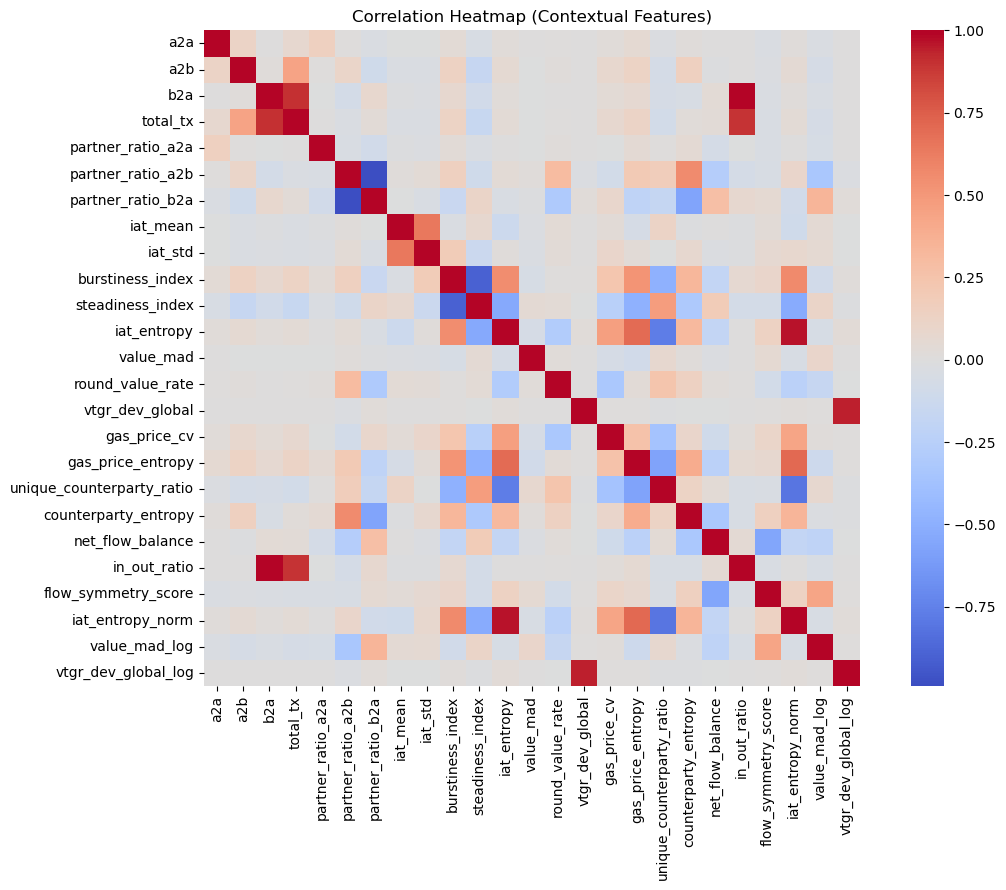

In [10]:
# Prepare context features
features_context = compute_contextual_features(
    transactions_path="data/transactions.csv",
    out_path="data/contextual_idx_v1.csv"
)

# Join with your existing combined_df
combined_df = psych_combined_df.join(features_context, on="account", how="inner").fill_null(0)


=== Contextual Feature Classification Report ===
              precision    recall  f1-score   support

        good       0.96      0.72      0.82     15912
         bad       0.23      0.76      0.35      1724

    accuracy                           0.72     17636
   macro avg       0.59      0.74      0.59     17636
weighted avg       0.89      0.72      0.78     17636



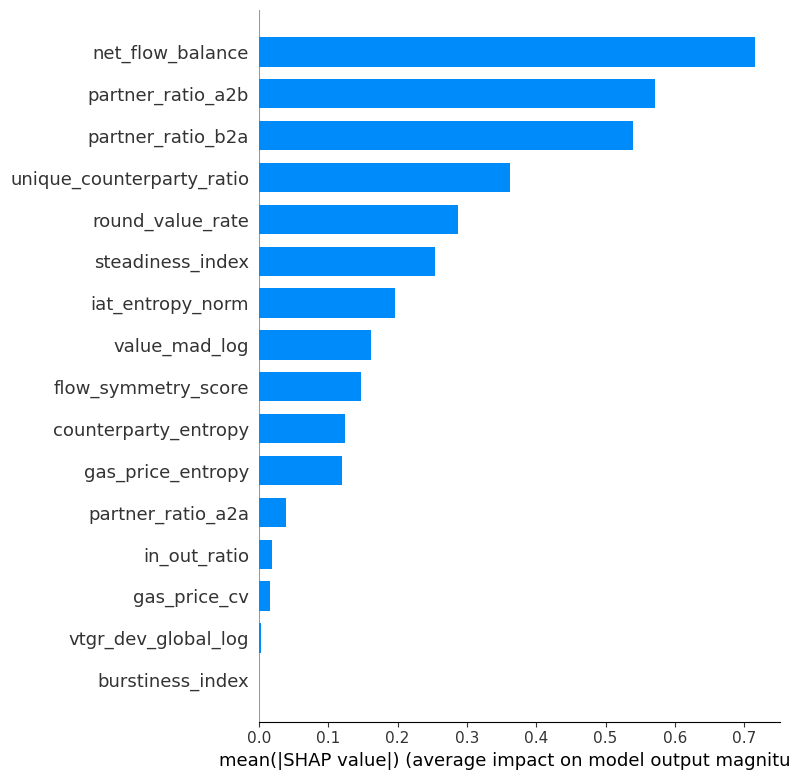

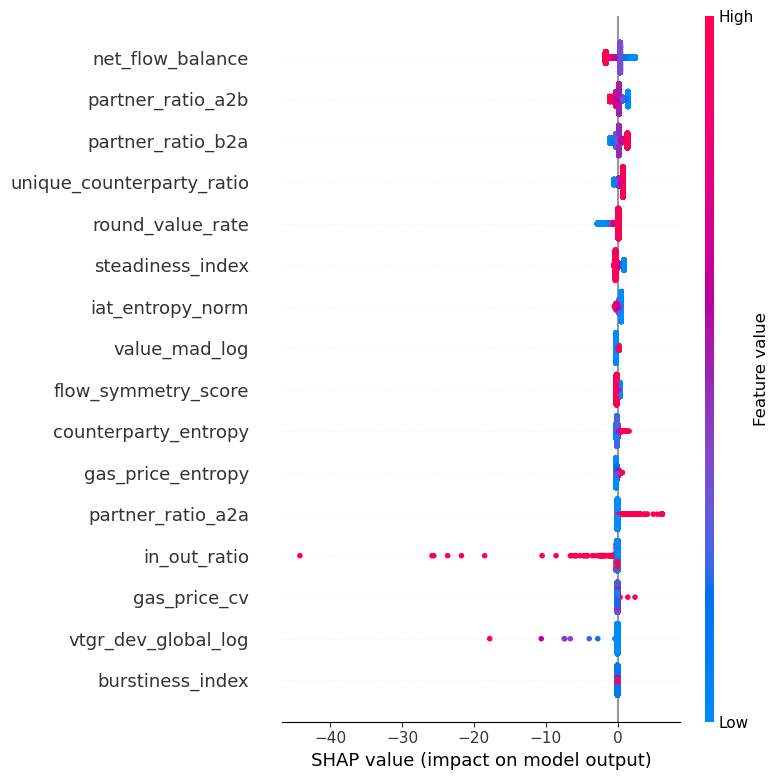

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt

# --- Load contextual features ---
features_ctx = pd.read_csv("data/contextual_idx_v1.csv")   # output from compute_contextual_features
labels = pd.read_csv("data/train_acc.csv")                 # [account, flag]

# Merge on account
df_ctx = features_ctx.merge(labels, on="account", how="inner")

# --- Select contextual feature columns ---
ctx_cols = [
    "partner_ratio_a2a", "partner_ratio_a2b", "partner_ratio_b2a",
    "iat_entropy_norm", "burstiness_index", "steadiness_index",
    "value_mad_log", "round_value_rate", "vtgr_dev_global_log",
    "gas_price_cv", "gas_price_entropy",
    "unique_counterparty_ratio", "counterparty_entropy",
    "net_flow_balance", "in_out_ratio", "flow_symmetry_score"
]

X_ctx = df_ctx[ctx_cols].values
y_ctx = df_ctx["flag"].values

# --- Logistic regression with scaling ---
pipe_ctx = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
pipe_ctx.fit(X_ctx, y_ctx)

# --- Evaluate quickly ---
from sklearn.metrics import classification_report
print("\n=== Contextual Feature Classification Report ===")
print(classification_report(y_ctx, pipe_ctx.predict(X_ctx), target_names=["good","bad"]))

# --- SHAP analysis ---
explainer_ctx = shap.LinearExplainer(pipe_ctx.named_steps["clf"], pipe_ctx.named_steps["scaler"].transform(X_ctx))
shap_values_ctx = explainer_ctx.shap_values(pipe_ctx.named_steps["scaler"].transform(X_ctx))

# Summary plot (bar chart of mean absolute SHAP values)
shap.summary_plot(shap_values_ctx, df_ctx[ctx_cols], plot_type="bar")

# Optional: detailed beeswarm plot
shap.summary_plot(shap_values_ctx, df_ctx[ctx_cols])

In [21]:
# Get predicted probabilities for the "bad" class
y_proba = pipe.predict_proba(X)[:, 1]

# Apply custom threshold
threshold = 0.6
y_pred_custom = (y_proba >= threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(f"=== Evaluation at threshold {threshold} ===")
print(classification_report(y, y_pred_custom, target_names=["good","bad"]))
print("Confusion matrix:\n", confusion_matrix(y, y_pred_custom))

NameError: name 'pipe' is not defined

In [19]:
combined_df.filter(pl.any_horizontal(pl.all().is_null()))

shape: (0, 1_189)
┌─────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ account ┆ flag ┆ normal_fpr ┆ normal_fpp ┆ … ┆ roundness_ ┆ reinvestme ┆ momentum_s ┆ inefficien │
│ ---     ┆ ---  ┆ ofit       ┆ rofit      ┆   ┆ score      ┆ nt_score   ┆ core_log   ┆ cy_score_c │
│ str     ┆ i64  ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ lipped     │
│         ┆      ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ ---        │
│         ┆      ┆            ┆            ┆   ┆            ┆            ┆            ┆ f64        │
╞═════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
└─────────┴──────┴────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [21]:
# Count nulls per column
null_counts = combined_df.select([
    pl.col(col).is_null().sum().alias(col) for col in combined_df.columns
])

print(null_counts)

shape: (1, 1_180)
┌─────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ account ┆ flag ┆ normal_fpr ┆ normal_fpp ┆ … ┆ roc_balanc ┆ abs_roc_ne ┆ abs_roc_ov ┆ abs_roc_tx │
│ ---     ┆ ---  ┆ ofit       ┆ rofit      ┆   ┆ e_tx_inter ┆ t_balance  ┆ ersell     ┆ _count     │
│ u32     ┆ u32  ┆ ---        ┆ ---        ┆   ┆ action     ┆ ---        ┆ ---        ┆ ---        │
│         ┆      ┆ u32        ┆ u32        ┆   ┆ ---        ┆ u32        ┆ u32        ┆ u32        │
│         ┆      ┆            ┆            ┆   ┆ u32        ┆            ┆            ┆            │
╞═════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0    ┆ 0          ┆ 0          ┆ … ┆ 0          ┆ 0          ┆ 0          ┆ 0          │
└─────────┴──────┴────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘


In [9]:
print(f"Combined data shape: {combined_df.shape}")

Combined data shape: (25198, 1161)


## X, y, feature_cols

In [12]:
# Prepare labeled data
labeled = combined_df.filter(pl.col("flag") != 0).to_dummies(columns=["source_dataset"])
drop_cols = {"account", "flag", "source_dataset_data1", "source_dataset_data2"
             "source_dataset_data3", "source_dataset_data4", "num_blong_shared"}
feature_cols = [c for c in labeled.columns if c not in drop_cols]

X = labeled.select(feature_cols).to_numpy()
y = (labeled["flag"].to_numpy() == 1).astype(int)

In [14]:
#combined_df.shape

## Optuna CatBoost Tuning

In [ ]:
# value = 0.847758909433141 (tau_star = 0.3154) v5
best_params = {'iterations': 1272, 
    'depth': 8, 
    'learning_rate': 0.03032831559541994, 
    'l2_leaf_reg': 4.371260916128613, 
    'border_count': 32, 
    'class_weights': [1.0, 1.2164100624741618],
    'random_seed': 42,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',   # or 'Logloss' if you prefer
    'verbose': 0,
    'task_type': 'GPU'
}     

In [ ]:
# value 0.847 v6 (tau_star = 0.3858)
best_params = {'iterations': 1695, 
    'depth': 5, 
    'learning_rate': 0.10471954664895215, 
    'l2_leaf_reg': 5.507869044442295, 
    'border_count': 128, 
    'class_weights': [1.0, 1.6180941744290904],
    'random_seed': 42,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',   # or 'Logloss' if you prefer
    'verbose': 0,
    'task_type': 'GPU'
}     

In [ ]:
# value 0.8565 v7 (tau_star = 0.5422) f1 0.77 **current best**
best_params = {'iterations': 1178, 
    'depth': 4, 'learning_rate': 0.10137353680647615, 
    'l2_leaf_reg': 8.964105292712736, 
    'border_count': 64, 
    'class_weights': [1.0, 2.745700833649743],
    'random_seed': 42,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',   # or 'Logloss' if you prefer
    'verbose': 0,
    'task_type': 'GPU'
}     

In [ ]:
# v5; tau_star = 0.3154; Trial 11 finished with value: 0.847758909433141 and parameters: {'iterations': 1272, 'depth': 8, 'learning_rate': 0.03032831559541994, 'l2_leaf_reg': 4.371260916128613, 'border_count': 32, 'pos_weight': 1.2164100624741618}. Best is trial 11 with value: 0.847758909433141.

In [ ]:
# v5; Trial 12 finished with value: 0.8461189661511378 and parameters: {'iterations': 1433, 'depth': 8, 'learning_rate': 0.03462319568383594, 'l2_leaf_reg': 4.01881186312607, 'border_count': 32, 'pos_weight': 1.017090457427281}. Best is trial 11 with value: 0.847758909433141.

In [ ]:
# v6; tau-star = ; [I 2025-10-12 23:28:41,640] Trial 5 finished with value: 0.8478273762095101 and parameters: {'iterations': 1695, 'depth': 5, 'learning_rate': 0.10471954664895215, 'l2_leaf_reg': 5.507869044442295, 'border_count': 128, 'pos_weight': 1.6180941744290904}. Best is trial 5 with value: 0.8478273762095101

In [ ]:
# v7; tau-star = ; [I 2025-10-13 14:48:59,169] Trial 6 finished with value: 0.8565692910087048 and parameters: {'iterations': 1178, 'depth': 4, 'learning_rate': 0.10137353680647615, 'l2_leaf_reg': 8.964105292712736, 'border_count': 64, 'pos_weight': 2.745700833649743}. Best is trial 6 with value: 0.8565692910087048.

In [23]:
# Step 2: Tune hyperparameters
best_params = tune_catboost(X, y, use_gpu=True, n_trials=20)
print("Best Params:", best_params)

[I 2025-10-13 18:08:39,851] A new study created in memory with name: no-name-24ee0faa-1c35-4339-8b4b-dbab89d288a8
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-13 18:27:29,422] Trial 0 finished with value: 0.8589802690485293 and parameters: {'iterations': 1330, 'depth': 9, 'learning_rate': 0.04124600635346425, 'l2_leaf_reg': 2.307493102953357, 'border_count': 64, 'pos_weight': 2.2093920000160985}. Best is trial 0 with value: 0.8589802690485293.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5

: 

In [ ]:
# Step 3: Retrain + threshold tuning
final_model, tau_star = train_final_model(X, y, best_params, use_gpu=True)

# Step 4: Feature importance
F_importance = rank_features(final_model, feature_cols)
F_importance.to_csv("data/F_importance_v7.csv", index=False)
print(F_importance)

# Save model
final_model.save_model("optuna_model_with_entropy_v7.cbm")

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


🎯 Best threshold: 0.5607
CV Precision: 0.8544 | CV Recall: 0.8376 | CV F1: 0.8459


Default metric period is 5 because AUC is/are not implemented for GPU



Top 20 Features by Importance:
                            feature  importance
996            ratio_abnormal_fsize    7.813126
1192       near_round_gas_pair_rate    4.006684
1162             connectivity_score    3.854533
1163                  variety_score    3.696227
997              ratio_normal_fsize    3.044774
998            ratio_abnormal_bsize    2.024654
993            ratio_normal_fprofit    1.685002
1172             partner_efficiency    1.648652
1164                roc_net_balance    1.621824
1223               net_flow_balance    1.481935
1151                 window_entropy    1.255918
1189  opportunistic_pair_diff_ratio    1.159528
1181                     pair_score    1.153547
441               B_fnet_value_mean    1.138920
1211                       iat_mean    1.086425
438                 B_fgas_cost_min    0.879581
0                    normal_fprofit    0.812752
1057          entropy_B_fmonth_freq    0.787066
999              ratio_normal_bsize    0.755800
448     

In [ ]:
# Correct
#F_importance.to_csv("data/F_importance_v6.csv", index=False)

In [ ]:
#final_model.save_model("optuna_model_with_entropy_v6.cbm")

In [25]:
from catboost import CatBoostClassifier

# Initialize an empty model
final_model = CatBoostClassifier()

final_model.load_model("optuna_model_with_entropy_v7.cbm") # v6 current best 0.7599 # v7 0.7599
#tau_star = 0.5422

In [16]:
print(final_model.feature_names_)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

In [30]:
len(feature_cols)

1178

### ver6

In [ ]:
# -----------------------------
# 6. Evaluation on Audit Set
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
        .rename({"ID": "account", "Predict": "flag"})
        .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()
probas = final_model.predict_proba(X_all)[:, 1]
preds = (probas >= tau_star).astype(int)

audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds,
    "prob_bad": probas
}).join(answer, on="account", how="inner")

y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

audit_df.write_csv("audit_report_with_entropy_v7.csv")
print("✅ Audit complete. See audit_report_with_entropy_v7.csv")


=== Audit Results ===
Accuracy: 0.9559348947995236
F1 (bad): 0.7599134823359769
Precision (bad): 0.7984848484848485
Recall (bad): 0.7248968363136176
Confusion matrix:
 [[6697  133]
 [ 200  527]]
✅ Audit complete. See audit_report_with_entropy_v6.csv


### ver7 current best (without contextual features)

In [24]:
# -----------------------------
# 6. Evaluation on Audit Set
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
        .rename({"ID": "account", "Predict": "flag"})
        .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()
probas = final_model.predict_proba(X_all)[:, 1]
preds = (probas >= tau_star).astype(int)

audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds,
    "prob_bad": probas
}).join(answer, on="account", how="inner")

y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

audit_df.write_csv("audit_report_with_entropy_v7.1.csv")
print("✅ Audit complete. See audit_report_with_entropy_v7.1.csv")


=== Audit Results ===
Accuracy: 0.9555379118697896
F1 (bad): 0.7623762376237624
Precision (bad): 0.784570596797671
Recall (bad): 0.7414030261348006
Confusion matrix:
 [[6682  148]
 [ 188  539]]
✅ Audit complete. See audit_report_with_entropy_v7.1.csv


✅ Best F1 on answer.csv = 0.7656 at threshold 0.62


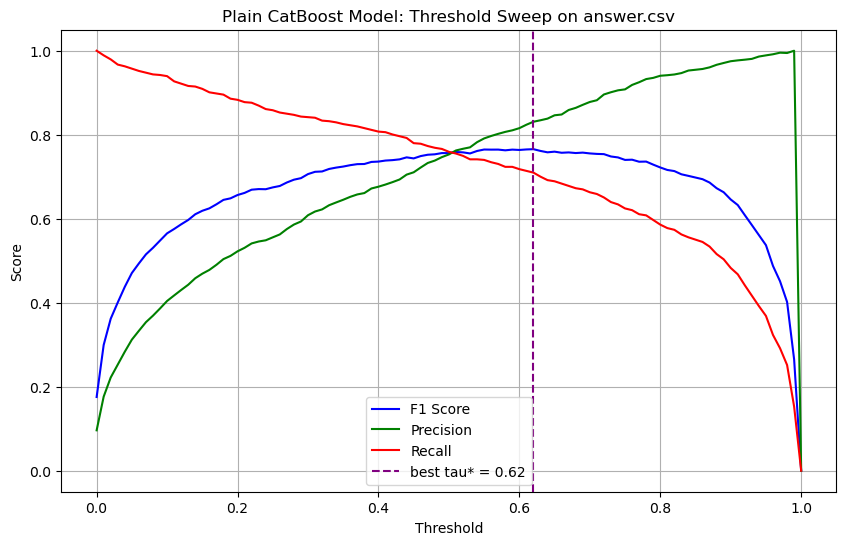

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# -----------------------------
# 1. Predict probabilities on ALL accounts
# -----------------------------
# Prepare features for all accounts (combined_df already has them)
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()
probas_all = final_model.predict_proba(X_all)[:, 1]

# -----------------------------
# 2. Join with answer.csv for evaluation
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)
audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "prob_bad": probas_all
}).join(answer, on="account", how="inner")

y_true = audit_df["flag"].to_numpy()
probas_eval = audit_df["prob_bad"].to_numpy()

# -----------------------------
# 3. Sweep thresholds
# -----------------------------
thresholds = np.linspace(0.0, 1.0, 101)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (probas_eval >= t).astype(int)
    f1s.append(f1_score(y_true, preds, zero_division=0))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))

# -----------------------------
# 4. Find best threshold by F1
# -----------------------------
best_idx = np.argmax(f1s)
tau_star_answer = thresholds[best_idx]

print(f"✅ Best F1 on answer.csv = {f1s[best_idx]:.4f} at threshold {tau_star_answer:.2f}")

# -----------------------------
# 5. Plot curves
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1 Score", color="blue")
plt.plot(thresholds, precisions, label="Precision", color="green")
plt.plot(thresholds, recalls, label="Recall", color="red")

plt.axvline(x=tau_star_answer, color="purple", linestyle="--", 
            label=f"best tau* = {tau_star_answer:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Plain CatBoost Model: Threshold Sweep on answer.csv")
plt.legend()
plt.grid(True)
plt.show()

## explainable audit

In [10]:
# -----------------------------
# 6. Evaluation on Audit Set with Explainability
# -----------------------------
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def audit_with_explainability(final_model, combined_df, feature_cols, tau_star,
                              answer_path="data/answer.csv",
                              out_csv="audit_report_explain_v7.1.csv"):
    # --- Load ground truth ---
    answer = (
        pl.read_csv(answer_path)
          .rename({"ID": "account", "Predict": "flag"})
          .select(["account", "flag"])
    )

    # --- Prepare features ---
    df_pred = combined_df.to_dummies(columns=["source_dataset"])
    missing = [c for c in feature_cols if c not in df_pred.columns]
    for c in missing:
        df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

    # Add account column for alignment
    df_pred = df_pred.with_columns(combined_df["account"])

    # --- Predict on all accounts ---
    X_all = df_pred.select(feature_cols).to_numpy()
    accounts_all = combined_df["account"].to_list()
    probas_all = final_model.predict_proba(X_all)[:, 1]
    preds_all = (probas_all >= tau_star).astype(int)

    # --- Join with ground truth ---
    audit_df = pl.DataFrame({
        "account": accounts_all,
        "predicted_flag": preds_all,
        "prob_bad": probas_all
    }).join(answer, on="account", how="inner")

    # Align features with joined accounts
    audit_accounts = audit_df["account"].to_list()
    mask = df_pred["account"].is_in(audit_df["account"].implode()).to_numpy()
    X_audit = df_pred.filter(mask).select(feature_cols).to_numpy()

    # Convert to pandas for SHAP + iteration
    audit_pd = audit_df.to_pandas()
    y_true = audit_pd["flag"].to_numpy()
    y_pred = audit_pd["predicted_flag"].to_numpy()
    probas = audit_pd["prob_bad"].to_numpy()
    accounts = audit_pd["account"].to_numpy()

    # --- Error type ---
    error_type = np.where((y_pred==y_true), "OK",
                   np.where((y_pred==1)&(y_true==0), "FP", "FN"))

    # --- SHAP values ---
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_audit)

    # --- Build enriched audit DataFrame ---
    audit_rows = []
    for i, acc in enumerate(accounts):
        abs_vals = np.abs(shap_values[i])
        top_idx = np.argsort(abs_vals)[-5:][::-1]
        top_feats = [f"{feature_cols[j]}:{shap_values[i][j]:+.3f}" for j in top_idx]

        row = {
            "account": acc,
            "predicted_flag": int(y_pred[i]),
            "true_flag": int(y_true[i]),
            "prob_bad": float(probas[i]),
            "error_type": error_type[i]
        }
        for k, feat in enumerate(top_feats, 1):
            row[f"top_feature_{k}"] = feat
        audit_rows.append(row)

    audit_out = pd.DataFrame(audit_rows)
    audit_out.to_csv(out_csv, index=False)

    # --- Print metrics ---
    print("\n=== Audit Results ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
    print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
    print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(f"✅ Audit complete. See {out_csv}")

    # --- Group-level SHAP analysis (OK, FP, FN) ---
    shap_df = pd.DataFrame(shap_values, columns=feature_cols)
    shap_df["error_type"] = error_type

    for g in ["OK","FP","FN"]:
        if g not in shap_df["error_type"].unique():
            continue
        group_mean = shap_df[shap_df["error_type"]==g][feature_cols] \
                        .abs().mean().sort_values(ascending=False).head(10)
        plt.figure(figsize=(8,5))
        sns.barplot(
            x=group_mean.values,
            y=group_mean.index,
            hue=group_mean.index,       # assign hue to the y variable
            dodge=False,
            palette="viridis",
            legend=False                # suppress redundant legend
        )
        plt.title(f"Top Features for {g}")
        plt.xlabel("Mean |SHAP value|")
        plt.tight_layout()
        plt.show()

    # --- Example force plot for one account ---
    idx = np.random.randint(0, len(X_audit))
    shap.force_plot(explainer.expected_value, shap_values[idx,:],
                    X_audit[idx,:], feature_names=feature_cols, matplotlib=True)

    return audit_out


=== Audit Results ===
Accuracy: 0.9589784305941511
F1 (bad): 0.7713864306784661
Precision (bad): 0.8314785373608903
Recall (bad): 0.71939477303989
Confusion matrix:
 [[6724  106]
 [ 204  523]]
✅ Audit complete. See audit_report_explain_v7.1.csv


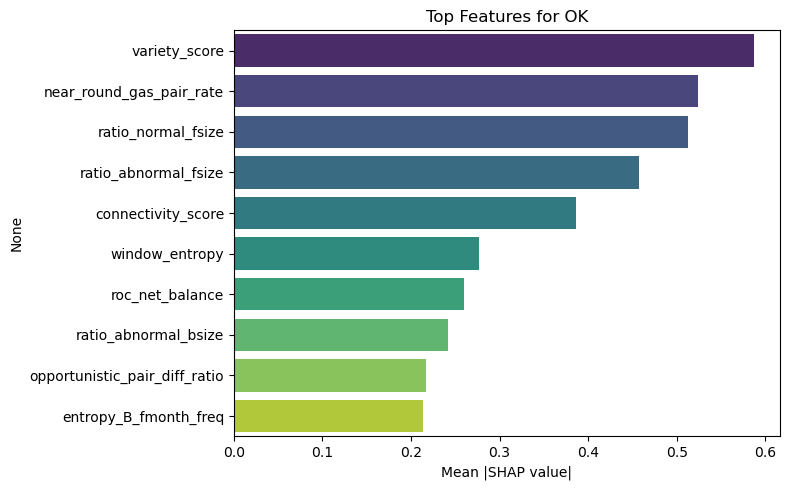

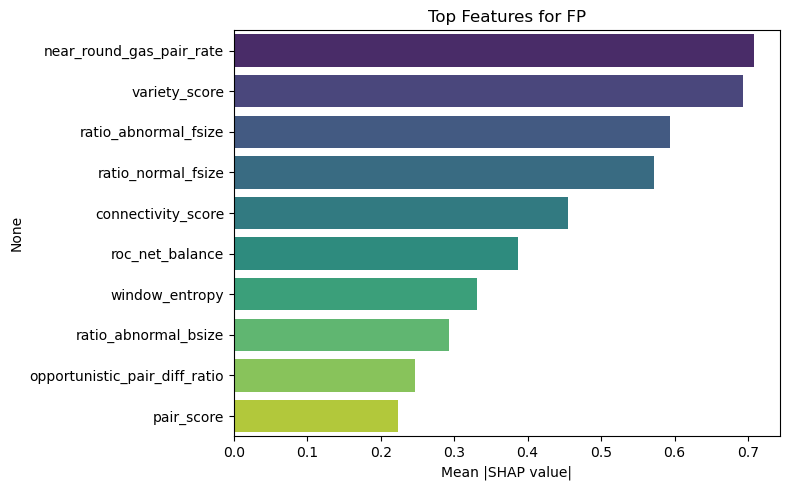

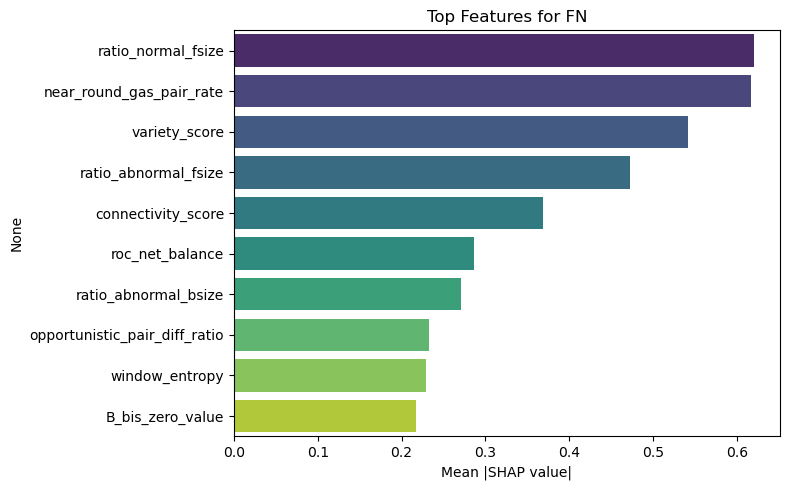

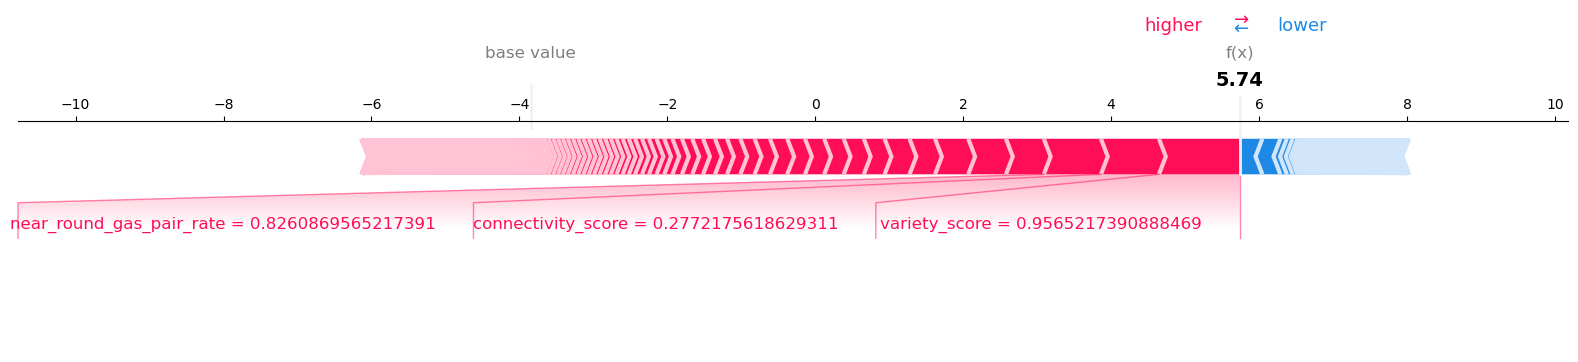

account  predicted_flag  true_flag  prob_bad error_type  \
0     a00002               0          0  0.214328         OK   
1     a00004               0          0  0.253778         OK   
2     a00005               0          0  0.000181         OK   
3     a00009               0          0  0.025458         OK   
4     a00013               0          0  0.000208         OK   
...      ...             ...        ...       ...        ...   
7552  a31487               1          1  0.905891         OK   
7553  a31488               0          0  0.004072         OK   
7554  a31490               0          0  0.014362         OK   
7555  a31494               0          0  0.003802         OK   
7556  a31498               0          0  0.000887         OK   

                        top_feature_1                    top_feature_2  \
0                variety_score:+0.806  near_round_gas_pair_rate:+0.518   
1         ratio_abnormal_bsize:+0.921  near_round_gas_pair_rate:+0.561   
2           ratio_normal_fsize:-1.277  near_round_gas_pair_rate:+0.922   
3     near_round_gas_pair_rate:-1.154        ratio_normal_fsize:+0.477   
4               window_entropy:-0.781             variety_score:-0.728   
...                               ...                              ...   
7552  near_round_gas_pair_rate:+0.910             variety_score:+0.865   
7553        ratio_normal_fsize:+0.479      ratio_abnormal_fsize:-0.430   
7554      ratio_abnormal_bsize:+1.460            window_entropy:-0.626   
7555        ratio_normal_fsize:+0.504      ratio_abnormal_fsize:-0.415   
7556             variety_score:-1.019        connectivity_score:-0.710   

                             top_feature_3  \
0                ratio_normal_fsize:+0.469   
1                ratio_normal_fsize:+0.456   
2                     variety_score:-0.674   
3                   roc_net_balance:+0.392   
4              ratio_abnormal_fsize:-0.479   
...                                    ...   
7552                roc_net_balance:+0.551   
7553  opportunistic_pair_diff_ratio:-0.349   
7554       near_round_gas_pair_rate:-0.536   
7555                  variety_score:-0.384   
7556  opportunistic_pair_diff_ratio:+0.580   

                             top_feature_4                    top_feature_5  
0                connectivity_score:+0.428      ratio_abnormal_fsize:-0.395  
1              ratio_abnormal_fsize:-0.422                pair_score:-0.404  
2                connectivity_score:-0.585      ratio_normal_fprofit:-0.575  
3     opportunistic_pair_diff_ratio:-0.370          B_fnet_value_min:+0.354  
4                connectivity_score:-0.460  near_round_gas_pair_rate:+0.445  
...                                    ...                              ...  
7552             ratio_normal_fsize:+0.522           B_fgas_cost_min:+0.503  
7553          entropy_B_fmonth_freq:-0.243               shock_score:-0.216  
7554             ratio_normal_fsize:+0.536      ratio_abnormal_fsize:-0.460  
7555             connectivity_score:-0.381  near_round_gas_pair_rate:-0.357  
7556       near_round_gas_pair_rate:-0.490        ratio_normal_fsize:+0.437  

[7557 rows x 10 columns]

In [13]:
audit_with_explainability(final_model, combined_df, feature_cols, tau_star)


=== Audit Results ===
Accuracy: 0.9589784305941511
F1 (bad): 0.7713864306784661
Precision (bad): 0.8314785373608903
Recall (bad): 0.71939477303989
Confusion matrix:
 [[6724  106]
 [ 204  523]]
✅ Audit complete. See audit_report_explain_v7.csv


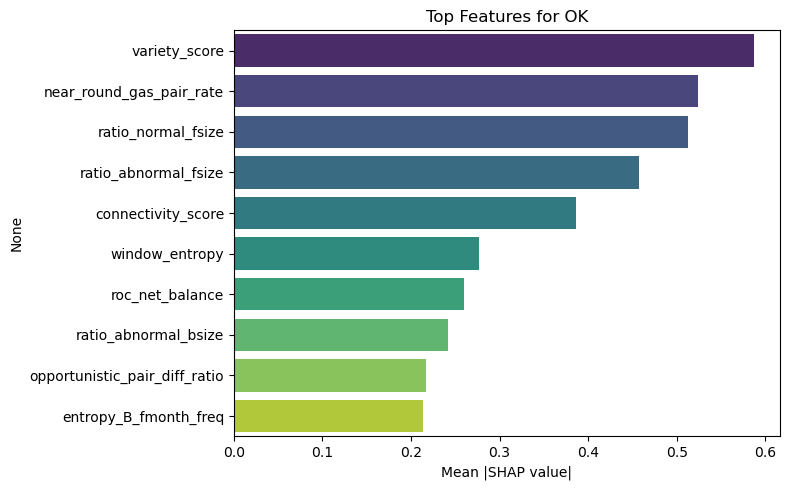

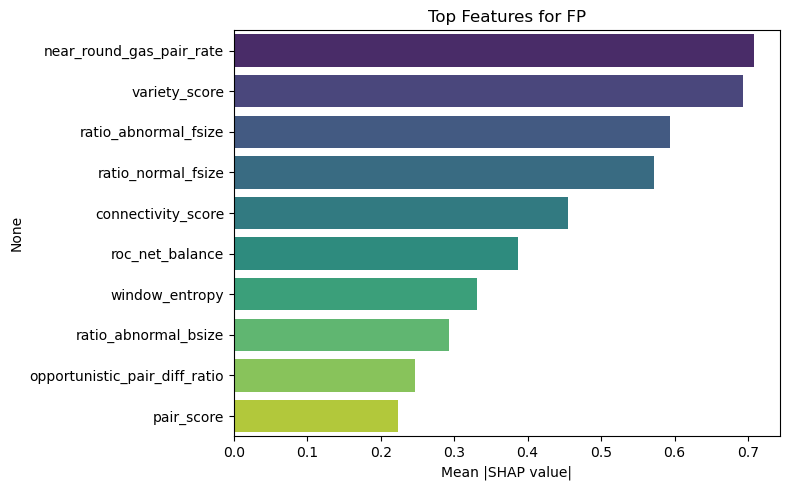

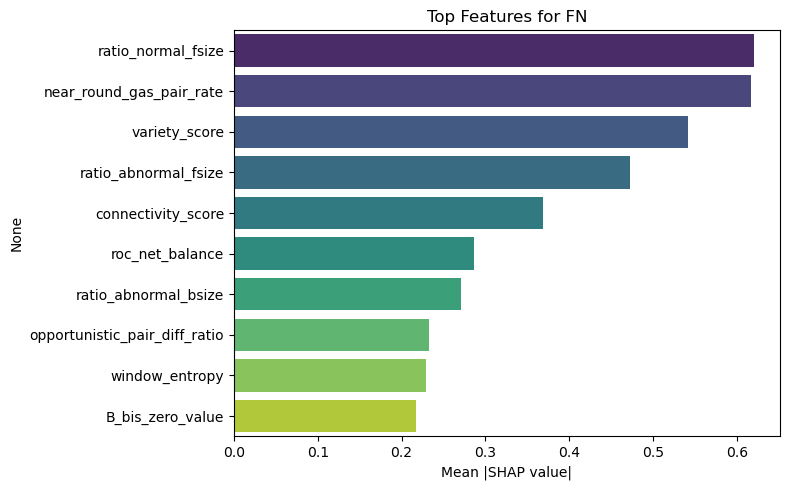

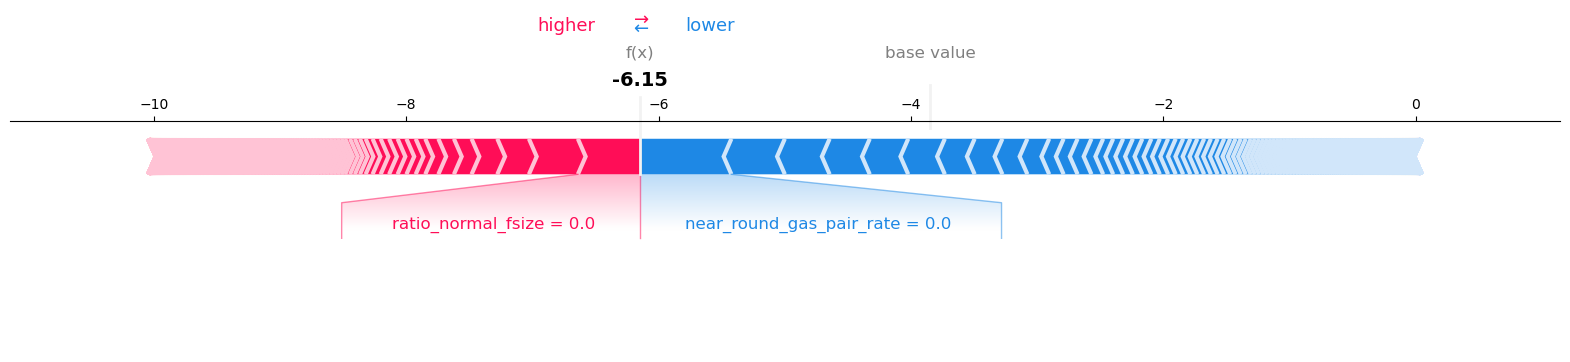

account  predicted_flag  true_flag  prob_bad error_type  \
0     a00002               0          0  0.214328         OK   
1     a00004               0          0  0.253778         OK   
2     a00005               0          0  0.000181         OK   
3     a00009               0          0  0.025458         OK   
4     a00013               0          0  0.000208         OK   
...      ...             ...        ...       ...        ...   
7552  a31487               1          1  0.905891         OK   
7553  a31488               0          0  0.004072         OK   
7554  a31490               0          0  0.014362         OK   
7555  a31494               0          0  0.003802         OK   
7556  a31498               0          0  0.000887         OK   

                        top_feature_1                    top_feature_2  \
0                variety_score:+0.806  near_round_gas_pair_rate:+0.518   
1         ratio_abnormal_bsize:+0.921  near_round_gas_pair_rate:+0.561   
2           ratio_normal_fsize:-1.277  near_round_gas_pair_rate:+0.922   
3     near_round_gas_pair_rate:-1.154        ratio_normal_fsize:+0.477   
4               window_entropy:-0.781             variety_score:-0.728   
...                               ...                              ...   
7552  near_round_gas_pair_rate:+0.910             variety_score:+0.865   
7553        ratio_normal_fsize:+0.479      ratio_abnormal_fsize:-0.430   
7554      ratio_abnormal_bsize:+1.460            window_entropy:-0.626   
7555        ratio_normal_fsize:+0.504      ratio_abnormal_fsize:-0.415   
7556             variety_score:-1.019        connectivity_score:-0.710   

                             top_feature_3  \
0                ratio_normal_fsize:+0.469   
1                ratio_normal_fsize:+0.456   
2                     variety_score:-0.674   
3                   roc_net_balance:+0.392   
4              ratio_abnormal_fsize:-0.479   
...                                    ...   
7552                roc_net_balance:+0.551   
7553  opportunistic_pair_diff_ratio:-0.349   
7554       near_round_gas_pair_rate:-0.536   
7555                  variety_score:-0.384   
7556  opportunistic_pair_diff_ratio:+0.580   

                             top_feature_4                    top_feature_5  
0                connectivity_score:+0.428      ratio_abnormal_fsize:-0.395  
1              ratio_abnormal_fsize:-0.422                pair_score:-0.404  
2                connectivity_score:-0.585      ratio_normal_fprofit:-0.575  
3     opportunistic_pair_diff_ratio:-0.370          B_fnet_value_min:+0.354  
4                connectivity_score:-0.460  near_round_gas_pair_rate:+0.445  
...                                    ...                              ...  
7552             ratio_normal_fsize:+0.522           B_fgas_cost_min:+0.503  
7553          entropy_B_fmonth_freq:-0.243               shock_score:-0.216  
7554             ratio_normal_fsize:+0.536      ratio_abnormal_fsize:-0.460  
7555             connectivity_score:-0.381  near_round_gas_pair_rate:-0.357  
7556       near_round_gas_pair_rate:-0.490        ratio_normal_fsize:+0.437  

[7557 rows x 10 columns]

In [30]:
audit_with_explainability(final_model, combined_df, feature_cols, tau_star)

## read audit

In [31]:
import pandas as pd

# Load the audit report
audit = pd.read_csv("audit_report_explain_v7.csv")

# False Positives: predicted bad (1), true good (0)
fp_accounts = audit[(audit["predicted_flag"] == 1) & (audit["true_flag"] == 0)]

# False Negatives: predicted good (0), true bad (1)
fn_accounts = audit[(audit["predicted_flag"] == 0) & (audit["true_flag"] == 1)]

# Inspect a few examples
print("=== False Positives (sample) ===")
print(fp_accounts.head(10)[["account","prob_bad","top_feature_1","top_feature_2","top_feature_3"]])

print("\n=== False Negatives (sample) ===")
print(fn_accounts.head(10)[["account","prob_bad","top_feature_1","top_feature_2","top_feature_3"]])

=== False Positives (sample) ===
    account  prob_bad                    top_feature_1  \
108  a00454  0.692237  near_round_gas_pair_rate:+0.945   
127  a00516  0.766462             variety_score:+0.826   
136  a00555  0.574330             variety_score:+0.875   
296  a01255  0.559341      ratio_abnormal_fsize:+1.711   
455  a01870  0.930834          B_bis_zero_value:+1.114   
555  a02389  0.684575      ratio_abnormal_fsize:+1.662   
748  a03213  0.962302  near_round_gas_pair_rate:+1.030   
810  a03441  0.688431  near_round_gas_pair_rate:+1.121   
869  a03676  0.602290             variety_score:+0.698   
965  a04062  0.574070  near_round_gas_pair_rate:+0.922   

                       top_feature_2                top_feature_3  
108             variety_score:+0.600       roc_net_balance:+0.498  
127  near_round_gas_pair_rate:+0.780    ratio_normal_fsize:+0.561  
136  near_round_gas_pair_rate:+0.775    ratio_normal_fsize:+0.520  
296  near_round_gas_pair_rate:+1.022         variety_sco

## Shuffle

In [36]:
def inspect_errors(audit_path, n=10):
    audit = pd.read_csv(audit_path)

    fp = audit[(audit["predicted_flag"]==1) & (audit["true_flag"]==0)]
    fn = audit[(audit["predicted_flag"]==0) & (audit["true_flag"]==1)]

    print("=== False Positives (sample) ===")
    print(fp.sample(n)[["account","prob_bad","top_feature_1","top_feature_2","top_feature_3"]])

    print("\n=== False Negatives (sample) ===")
    print(fn.sample(n)[["account","prob_bad","top_feature_1","top_feature_2","top_feature_3"]])

    return fp, fn

# Example usage
fp, fn = inspect_errors("audit_report_explain_v7.csv", n=5)

=== False Positives (sample) ===
     account  prob_bad                   top_feature_1  \
3774  a15983  0.920910       ratio_normal_fsize:+1.236   
7366  a30711  0.694576          t_bgas_cost_min:+0.721   
4533  a19185  0.606912            variety_score:+0.975   
5521  a23240  0.640828  conn_profit_interaction:+0.689   
3311  a13989  0.925856            variety_score:+1.026   

                        top_feature_2                     top_feature_3  
3774          B_bis_zero_value:+1.201   near_round_gas_pair_rate:-1.052  
7366        ratio_normal_fsize:+0.601              variety_score:+0.475  
4533        connectivity_score:+0.775   near_round_gas_pair_rate:+0.726  
5521        ratio_normal_fsize:+0.518       ratio_abnormal_fsize:-0.420  
3311  near_round_gas_pair_rate:+0.858  ratio_Q3_Q4_B_fmonth_freq:+0.792  

=== False Negatives (sample) ===
     account  prob_bad                    top_feature_1  \
4453  a18863  0.216198             variety_score:+0.879   
5242  a22051  0.217963

# Calibration

### Sigmoid

In [14]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap CatBoost with Platt scaling (logistic regression)
calibrated_model = CalibratedClassifierCV(estimator=final_model, method="sigmoid", cv=5)
calibrated_model.fit(X, y)

# Use calibrated_model.predict_proba(X)[:,1] for threshold tuning

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


CalibratedClassifierCV(cv=5,
                       estimator=<catboost.core.CatBoostClassifier object at 0x7ed3dd5b6aa0>)

In [15]:
import joblib

# Save
joblib.dump(calibrated_model, "calibrated_catboost_v7.pkl")

# Later, reload
#calibrated_model = joblib.load("calibrated_catboost.pkl")

['calibrated_catboost_v7.pkl']

In [28]:
import joblib
calibrated_model = joblib.load("calibrated_catboost_v7.pkl")

In [29]:
probas_cal = calibrated_model.predict_proba(X)[:, 1]

## optional

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0.1, 0.9, 81)  # e.g. 0.1 to 0.9 in 0.01 steps
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (probas_cal >= t).astype(int)
    f1s.append(f1_score(y, preds))
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

In [21]:
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold,
      "F1:", f1s[best_idx],
      "Precision:", precisions[best_idx],
      "Recall:", recalls[best_idx])

Best threshold: 0.47 F1: 0.9501871580765908 Precision: 0.9433962264150944 Recall: 0.95707656612529


In [25]:
preds_cal = (calibrated_model.predict_proba(X)[:, 1] >= best_threshold).astype(int)

## default flow

In [30]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

prec, rec, thr = precision_recall_curve(y, probas_cal)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = int(f1s.argmax())
tau_star = float(thr[best_idx]) if len(thr) > 0 else 0.5
# 👉 To lower threshold slightly for higher recall:
tau_star = max(0.0, tau_star - (0.1748))   # subtract ~0.05, tune as needed # 0.08 achieved 0.8 precision 0.64 recall 0.721 f1

print(f"Best calibrated threshold: {tau_star:.4f}")

Best calibrated threshold: 0.2802


In [31]:
y_hat = (probas_cal >= tau_star).astype(int)
print("Precision:", precision_score(y, y_hat))
print("Recall:", recall_score(y, y_hat))
print("F1:", f1_score(y, y_hat))

Precision: 0.9037520391517129
Recall: 0.9640371229698376
F1: 0.9329216952006736


In [32]:
# -----------------------------
# 6. Evaluation on Audit Set
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
        .rename({"ID": "account", "Predict": "flag"})
        .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()
probas_audit = calibrated_model.predict_proba(X_all)[:, 1]
preds_audit = (probas_audit >= tau_star).astype(int)

audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds_audit,
    "prob_bad": probas_audit
}).join(answer, on="account", how="inner")

y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

audit_df.write_csv("audit_report_with_calibration_sigmoid_v7_0.175.csv")
print("✅ Audit complete. See audit_report_with_calibration_sigmoid_v7_0.175.csv")


=== Audit Results ===
Accuracy: 0.956199550086013
F1 (bad): 0.7673928320449754
Precision (bad): 0.7844827586206896
Recall (bad): 0.7510316368638239
Confusion matrix:
 [[6680  150]
 [ 181  546]]
✅ Audit complete. See audit_report_with_calibration_sigmoid_v7_0.175.csv


✅ Best F1 on sigmoid calibration = 0.7775 at threshold 0.37


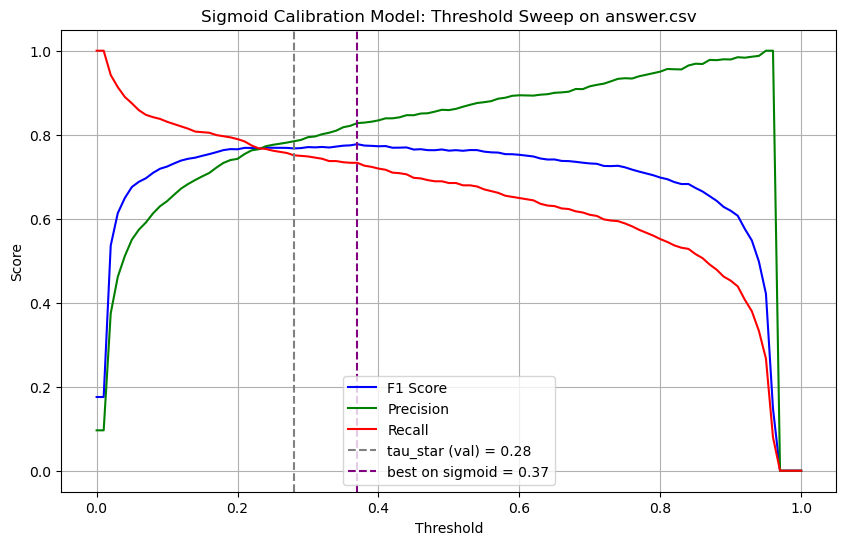

In [35]:
# -----------------------------
# 7. Threshold sweep for sigmoid calibration model
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# After building audit_df
y_true = audit_df["flag"].to_numpy()
probas_eval = audit_df["prob_bad"].to_numpy()   # aligned probs

# Sweep thresholds
thresholds = np.linspace(0.0, 1.0, 101)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (probas_eval >= t).astype(int)
    f1s.append(f1_score(y_true, preds, zero_division=0))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))

# Find best threshold by F1
best_idx = np.argmax(f1s)
best_tau_sigmoid = thresholds[best_idx]

print(f"✅ Best F1 on sigmoid calibration = {f1s[best_idx]:.4f} at threshold {best_tau_sigmoid:.2f}")

# Plot curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1 Score", color="blue")
plt.plot(thresholds, precisions, label="Precision", color="green")
plt.plot(thresholds, recalls, label="Recall", color="red")

# Mark current tau_star and best on sigmoid
plt.axvline(x=tau_star, color="gray", linestyle="--", label=f"tau_star (val) = {tau_star:.2f}")
plt.axvline(x=best_tau_sigmoid, color="purple", linestyle="--", label=f"best on sigmoid = {best_tau_sigmoid:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Sigmoid Calibration Model: Threshold Sweep on answer.csv")
plt.legend()
plt.grid(True)
plt.show()

# Calibration 2

### Universal tau_star Calculation for Calibrator

In [43]:
import numpy as np
from sklearn.metrics import f1_score

def find_tau_star(y_true, probas, step=0.01):
    """
    Find the threshold tau_star that maximizes F1 score.
    
    y_true : array-like of shape (n_samples,)
        Ground truth labels (0/1).
    probas : array-like of shape (n_samples,)
        Predicted probabilities for the positive class.
    step : float
        Granularity of the search (default 0.01).
    """
    thresholds = np.arange(0.0, 1.0+step, step)
    f1s = [f1_score(y_true, (probas >= t).astype(int)) for t in thresholds]
    best_idx = int(np.argmax(f1s))
    return thresholds[best_idx], f1s[best_idx]

### Isotonic

In [59]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap CatBoost with isotonic regression
calibrated_model_iso = CalibratedClassifierCV(estimator=final_model, method="isotonic", cv=5)
calibrated_model_iso.fit(X, y)

# Save
import joblib
joblib.dump(calibrated_model_iso, "calibrated_catboost_isotonic_v7.pkl")

# Predict calibrated probabilities
probas_iso = calibrated_model_iso.predict_proba(X)[:, 1]

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


In [67]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

prec, rec, thr = precision_recall_curve(y, probas_iso)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = int(f1s.argmax())
tau_star = float(thr[best_idx]) if len(thr) > 0 else 0.5
# 👉 To lower threshold slightly for higher recall:
tau_star = max(0.0, tau_star - (0.1748))   # subtract ~0.05, tune as needed # 0.08 achieved 0.8 precision 0.64 recall 0.721 f1

print(f"Best calibrated threshold: {tau_star:.4f}")

Best calibrated threshold: 0.2841


In [68]:
# -----------------------------
# 6. Evaluation on Audit Set
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
        .rename({"ID": "account", "Predict": "flag"})
        .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()
probas_audit = calibrated_model_iso.predict_proba(X_all)[:, 1]
preds_audit = (probas_audit >= tau_star).astype(int)

audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds_audit,
    "prob_bad": probas_audit
}).join(answer, on="account", how="inner")

y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

audit_df.write_csv("audit_report_with_calibration_iso_v7.csv")
print("✅ Audit complete. See audit_report_with_calibration_iso_v7.csv")


=== Audit Results ===
Accuracy: 0.9585814476644171
F1 (bad): 0.7815771109560363
Precision (bad): 0.7932011331444759
Recall (bad): 0.7702888583218707
Confusion matrix:
 [[6684  146]
 [ 167  560]]
✅ Audit complete. See audit_report_with_calibration_iso_v7.csv


### Beta Calibration

In [71]:
from betacal import BetaCalibration
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# -----------------------------
# 5. Fit Beta Calibration on training set
# -----------------------------
# Get raw probabilities from CatBoost
probas_train = final_model.predict_proba(X)[:, 1]

# Fit beta calibration
beta_cal = BetaCalibration(parameters="abm")  # "abm" = alpha, beta, mixture
beta_cal.fit(probas_train, y)

# Save the calibrator
joblib.dump(beta_cal, "calibrated_catboost_beta_v7.pkl")

# -----------------------------
# 6. Evaluation on Audit Set
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()

# Get raw probabilities from CatBoost on audit set
probas_raw_audit = final_model.predict_proba(X_all)[:, 1]

# Apply beta calibration
probas_audit = beta_cal.predict(probas_raw_audit)

# Thresholding
preds_audit = (probas_audit >= tau_star).astype(int)

# Build audit dataframe
audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds_audit,
    "prob_bad": probas_audit
}).join(answer, on="account", how="inner")

# Metrics
y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results (Beta Calibration) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save audit report
audit_df.write_csv("audit_report_with_calibration_beta_v7.csv")
print("✅ Audit complete. See audit_report_with_calibration_beta_v7.csv")


=== Audit Results (Beta Calibration) ===
Accuracy: 0.9555379118697896
F1 (bad): 0.7698630136986301
Precision (bad): 0.7667121418826739
Recall (bad): 0.7730398899587345
Confusion matrix:
 [[6659  171]
 [ 165  562]]
✅ Audit complete. See audit_report_with_calibration_beta_v7.csv


### Temperature Scaliing

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# -----------------------------
# 6. Evaluation on Audit Set (Temperature Scaling)
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()

# Get raw probabilities from CatBoost
probas_raw_audit = final_model.predict_proba(X_all)[:, 1]

# Convert to logits
logits_audit = np.log(probas_raw_audit / (1 - probas_raw_audit + 1e-9))

# Apply temperature scaling
probas_audit = temp_model.predict_proba(logits_audit.reshape(-1, 1))[:, 1]


import pandas as pd
from sklearn.model_selection import train_test_split

# Join ensemble probs with training labels
labels_df = pd.read_csv("data/train_acc.csv").set_index("account")
ensemble_df = pd.DataFrame({"proba_ensemble": probas_ensemble}, index=combined_df["account"].to_pandas())
ensemble_full = ensemble_df.join(labels_df, how="inner")

X = ensemble_full[["proba_ensemble"]].values
y = ensemble_full["flag"].values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Thresholding
# Suppose you have predictions from your meta2_clf on a validation set
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

tau_star, best_f1 = find_tau_star(y_val, X_val.ravel())
print(f"Ensemble tau_star: {tau_star:.3f}, F1: {best_f1:.4f}")

# Thresholding
preds_audit = (probas_audit >= (tau_star - 0.05)).astype(int)

# Build audit dataframe
audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds_audit,
    "prob_bad": probas_audit
}).join(answer, on="account", how="inner")

# Metrics
y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results (Temperature Scaling) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save audit report
audit_df.write_csv("audit_report_with_calibration_temp_v7.csv")
print("✅ Audit complete. See audit_report_with_calibration_temp_v7.csv")


=== Audit Results (Temperature Scaling) ===
Accuracy: 0.9469366150588858
F1 (bad): 0.7489041953663118
Precision (bad): 0.6873563218390805
Recall (bad): 0.8225584594222833
Confusion matrix:
 [[6558  272]
 [ 129  598]]
✅ Audit complete. See audit_report_with_calibration_temp_v7.csv


### Ensemble Calibration

In [44]:
import joblib
import numpy as np

# -----------------------------
# Load saved calibrators
# -----------------------------
calibrated_model      = joblib.load("calibrated_catboost_v7.pkl")          # sigmoid / Platt
calibrated_model_iso  = joblib.load("calibrated_catboost_isotonic_v7.pkl")    # isotonic
beta_cal              = joblib.load("calibrated_catboost_beta_v7.pkl")        # beta calibration
temp_model            = joblib.load("calibrated_catboost_temp_v7.pkl")        # temperature scaling

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()

# -----------------------------
# Predict on audit set
# -----------------------------
# Get raw probabilities from CatBoost
probas_raw_audit = final_model.predict_proba(X_all)[:, 1]

# Apply each calibration
probas_sigmoid = calibrated_model.predict_proba(X_all)[:, 1]
probas_iso     = calibrated_model_iso.predict_proba(X_all)[:, 1]
probas_beta    = beta_cal.predict(probas_raw_audit)  # BetaCalibration uses .predict()
logits_audit   = np.log(probas_raw_audit / (1 - probas_raw_audit + 1e-9))
probas_temp    = temp_model.predict_proba(logits_audit.reshape(-1, 1))[:, 1]

# -----------------------------
# Ensemble average
# -----------------------------
# Example: give more weight to isotonic and beta
weights = {
    "sigmoid": 1.0,
    "isotonic": 0.3,
    "beta": 0.2,
    "temp": 0.3
}

# Weighted average
probas_ensemble = (
    weights["sigmoid"] * probas_sigmoid +
    weights["isotonic"] * probas_iso +
    weights["beta"]    * probas_beta +
    weights["temp"]    * probas_temp
) / sum(weights.values())

import pandas as pd
from sklearn.model_selection import train_test_split

# Join ensemble probs with training labels
labels_df = pd.read_csv("data/train_acc.csv").set_index("account")
ensemble_df = pd.DataFrame({"proba_ensemble": probas_ensemble}, index=combined_df["account"].to_pandas())
ensemble_full = ensemble_df.join(labels_df, how="inner")

X = ensemble_full[["proba_ensemble"]].values
y = ensemble_full["flag"].values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Thresholding
# Suppose you have predictions from your meta2_clf on a validation set
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

tau_star, best_f1 = find_tau_star(y_val, X_val.ravel())
print(f"Ensemble tau_star: {tau_star:.3f}, F1: {best_f1:.4f}")
preds_audit = (probas_ensemble >= (tau_star - 0.05)).astype(int)

Ensemble tau_star: 0.580, F1: 0.9469


In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# -----------------------------
# 6. Evaluation on Audit Set (Ensemble Calibration)
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)

# Predict on combined_df
df_pred = combined_df.to_dummies(columns=["source_dataset"])
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()

# Get raw probabilities from CatBoost
probas_raw_audit = final_model.predict_proba(X_all)[:, 1]

# Apply each calibration (loaded from file)
probas_sigmoid = calibrated_model.predict_proba(X_all)[:, 1]
probas_iso     = calibrated_model_iso.predict_proba(X_all)[:, 1]
probas_beta    = beta_cal.predict(probas_raw_audit)
logits_audit   = np.log(probas_raw_audit / (1 - probas_raw_audit + 1e-9))
probas_temp    = temp_model.predict_proba(logits_audit.reshape(-1, 1))[:, 1]

# Ensemble average
probas_ensemble = (probas_sigmoid + probas_iso + probas_beta + probas_temp) / 4.0

# Thresholding
preds_audit = (probas_ensemble >= tau_star).astype(int)

# Build audit dataframe
audit_df = pl.DataFrame({
    "account": combined_df["account"],
    "predicted_flag": preds_audit,
    "prob_bad": probas_ensemble
}).join(answer, on="account", how="inner")

# Metrics
y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results (Ensemble Calibration) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save audit report
audit_df.write_csv("audit_report_with_calibration_ensemble_v7.csv")
print("✅ Audit complete. See audit_report_with_calibration_ensemble_v7.csv")


=== Audit Results (Ensemble Calibration) ===
Accuracy: 0.9597723964536191
F1 (bad): 0.7636080870917574
Precision (bad): 0.8783542039355993
Recall (bad): 0.6753782668500687
Confusion matrix:
 [[6762   68]
 [ 236  491]]
✅ Audit complete. See audit_report_with_calibration_ensemble_v7.csv


✅ Best F1 on ensemble calibration = 0.7692 at threshold 0.42


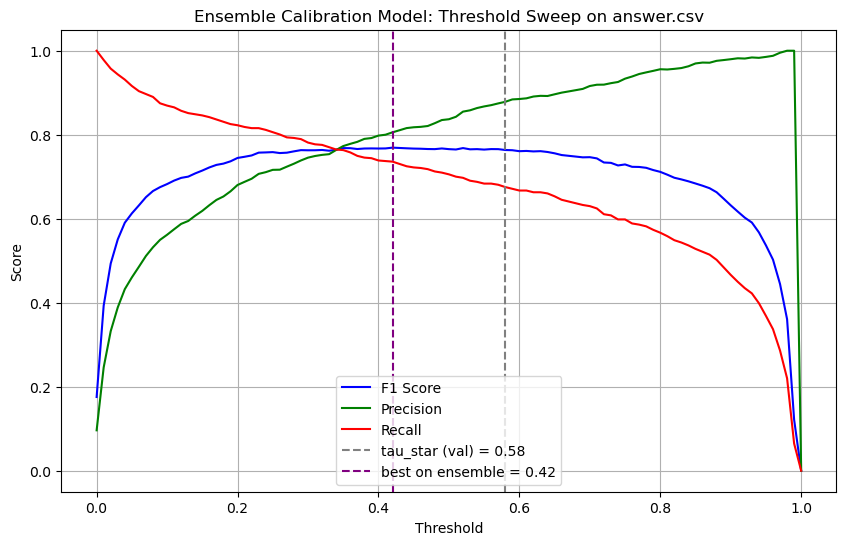

In [46]:
# -----------------------------
# 7. Threshold sweep for Ensemble Calibration model
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Use aligned arrays from audit_df
y_true = audit_df["flag"].to_numpy()
probas_eval = audit_df["prob_bad"].to_numpy()

thresholds = np.linspace(0.0, 1.0, 101)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (probas_eval >= t).astype(int)
    f1s.append(f1_score(y_true, preds, zero_division=0))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))

# Find best threshold by F1
best_idx = np.argmax(f1s)
best_tau_ensemble = thresholds[best_idx]

print(f"✅ Best F1 on ensemble calibration = {f1s[best_idx]:.4f} at threshold {best_tau_ensemble:.2f}")

# Plot curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1 Score", color="blue")
plt.plot(thresholds, precisions, label="Precision", color="green")
plt.plot(thresholds, recalls, label="Recall", color="red")

# Mark current tau_star and best on ensemble
plt.axvline(x=tau_star, color="gray", linestyle="--", label=f"tau_star (val) = {tau_star:.2f}")
plt.axvline(x=best_tau_ensemble, color="purple", linestyle="--", label=f"best on ensemble = {best_tau_ensemble:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Ensemble Calibration Model: Threshold Sweep on answer.csv")
plt.legend()
plt.grid(True)
plt.show()

### meta-meta model

source of meta2_X_v7.parquet

In [47]:
import numpy as np
from sklearn.metrics import f1_score

def find_tau_star_meta2(y_true, probas, step=0.01):
    """
    Find the threshold tau_star that maximizes F1 score.
    
    y_true : array-like of shape (n_samples,)
        Ground truth labels (0/1).
    probas : array-like of shape (n_samples,)
        Predicted probabilities for the positive class.
    step : float
        Granularity of the search (default 0.01).
    """
    thresholds = np.arange(0.0, 1.0+step, step)
    f1s = [f1_score(y_true, (probas >= t).astype(int)) for t in thresholds]
    best_idx = int(np.argmax(f1s))
    return thresholds[best_idx], f1s[best_idx]

In [48]:
import numpy as np
import pandas as pd
import polars as pl
import joblib

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# -----------------------------
# 1. Load answer file
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)

train_acc = (
    pl.read_csv("data/train_acc.csv")
        .select(["account", "flag"])
)

# -----------------------------
# 2. Prepare feature matrix
# -----------------------------
df_pred = combined_df.to_dummies(columns=["source_dataset"]).fill_null(0)
missing = [c for c in feature_cols if c not in df_pred.columns]
for c in missing:
    df_pred = df_pred.with_columns(pl.lit(0).cast(pl.Float64).alias(c))

X_all = df_pred.select(feature_cols).to_numpy()

# -----------------------------
# 3. Load trained models
# -----------------------------
final_model = CatBoostClassifier()
final_model.load_model("optuna_model_with_entropy_v7.cbm")                # base CatBoost
calibrated_model     = joblib.load("calibrated_catboost_v7.pkl")          # sigmoid
calibrated_model_iso = joblib.load("calibrated_catboost_isotonic_v7.pkl")    # isotonic
beta_cal             = joblib.load("calibrated_catboost_beta_v7.pkl")        # beta
temp_model           = joblib.load("calibrated_catboost_temp_v7.pkl")        # temperature
meta_clf             = joblib.load("meta_Logistic_v7.pkl")                     # first stacked meta-model
lr                   = joblib.load("logreg_selected_v7.pkl")                 # LR on selected features

# -----------------------------
# 4. Generate probabilities
# -----------------------------
# Plain CatBoost
proba_cat = final_model.predict_proba(X_all)[:, 1]

# Sigmoid calibration
proba_sigmoid = calibrated_model.predict_proba(X_all)[:, 1]

# Isotonic calibration
proba_isotonic = calibrated_model_iso.predict_proba(X_all)[:, 1]

# Beta calibration (takes raw CatBoost probs)
proba_beta = beta_cal.predict(proba_cat)

# Temperature scaling
logits_audit = np.log(proba_cat / (1 - proba_cat + 1e-9))
proba_temp = temp_model.predict_proba(logits_audit.reshape(-1, 1))[:, 1]

# Logistic regression on selected features
selected_cols = [
    # Existing structural features
    "ratio_abnormal_fsize", "ratio_normal_fsize",
    "ratio_abnormal_bsize", "ratio_normal_fprofit",
    "entropy_B_fmonth_freq",
    "B_fgas_cost_min", "B_fgas_cost_max",
    "B_fvalue_to_gas_ratio_mean", "B_fvalue_to_gas_ratio_min",
    "B_bgas_cost_std", "B_bgas_cost_mean",
    "B_bnet_value_min", "B_bnet_value_max", "B_bnet_value_mean",
    "B_bvalue_to_gas_ratio_min",
    "zero_val_ratio_A", "unique_from_A", "unique_from_B",

    # Window-based features
    "window_entropy", "window_peak_ratio", "window_tx_count",
    "window_hour_sin", "window_hour_cos",

    # 👉 New psychological indices
    "shock_score",
    "momentum_score_log",          # use the log-scaled version
    "pair_score",
    "has_10min_pair",              # binary flag
    "inefficiency_score_clipped",  # clipped version
    "habit_score",
    "roundness_score",
    "reinvestment_score"
] # same list you defined earlier
col_idx = [feature_cols.index(c) for c in selected_cols if c in feature_cols]
X_all_lr = np.nan_to_num(X_all[:, col_idx], nan=0.0, posinf=0.0, neginf=0.0)
proba_lr = lr.predict_proba(X_all_lr)[:, 1]

# Weighted ensemble
weights = {"sigmoid": 1.0, "isotonic": 0.3, "beta": 0.2, "temp": 0.3}
proba_ensemble = (
    weights["sigmoid"] * proba_sigmoid +
    weights["isotonic"] * proba_isotonic +
    weights["beta"]    * proba_beta +
    weights["temp"]    * proba_temp
) / sum(weights.values())

# Meta-model (first stacked layer)
meta_all = pd.DataFrame({
    "proba_catboost": proba_cat,
    "proba_calibrated": proba_sigmoid,
    "proba_logreg": proba_lr
})
proba_meta = meta_clf.predict_proba(meta_all)[:, 1]

# -----------------------------
# 5. Build meta2_X DataFrame
# -----------------------------
meta2_X = pd.DataFrame({
    "proba_cat": proba_cat,
    "proba_sigmoid": proba_sigmoid,
    "proba_isotonic": proba_isotonic,
    "proba_beta": proba_beta,
    "proba_temp": proba_temp,
    "proba_lr": proba_lr,
    "proba_ensemble": proba_ensemble,
    "proba_meta": proba_meta
}, index=combined_df["account"].to_pandas())

# Save to disk for reuse
meta2_X.to_parquet("meta2_X_v7.parquet")
print("✅ Saved meta2_X_v7.parquet with shape:", meta2_X.shape)

# meta2_y = y  # labels from training set

# Suppose you have a DataFrame with account + label
labels_df = train_acc.to_pandas().set_index("account")

# Join probabilities with labels
meta2_full = meta2_X.join(labels_df, how="inner")  # only keep accounts with labels

meta2_X_labeled = meta2_full.drop(columns=["flag"])
meta2_y_labeled = meta2_full["flag"].values

# -----------------------------
# Save meta2 features and labels
# -----------------------------

# Save the feature matrix (already a DataFrame)
meta2_X_labeled.index.name = "account"
meta2_X_labeled.to_parquet("meta2_X_labeled_v7.parquet")
print("✅ Saved meta2_X_labeled_v7.parquet with shape:", meta2_X_labeled.shape)

# Wrap labels (NumPy array) in a DataFrame before saving
pd.DataFrame({"account": meta2_X_labeled.index, "flag": meta2_y_labeled}) \
  .set_index("account") \
  .to_parquet("meta2_y_labeled_v7.parquet")
print("✅ Saved meta2_y_labeled_v7.parquet with length:", len(meta2_y_labeled))

# -----------------------------
# 6. Cross-validation (optional)
# -----------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(meta2_X_labeled):
    X_train, X_val = meta2_X_labeled.iloc[train_idx], meta2_X_labeled.iloc[val_idx]
    y_train, y_val = meta2_y_labeled[train_idx], meta2_y_labeled[val_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds)
    cv_scores.append(f1)

print("Meta‑meta CV F1 scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))

# -----------------------------
# 7. Train final meta‑meta model
# -----------------------------
meta2_clf = LogisticRegression(max_iter=1000)
meta2_clf.fit(meta2_X_labeled, meta2_y_labeled)

# Save the model
joblib.dump(meta2_clf, "meta2_clf_v7.pkl")
print("✅ Meta‑meta model saved as meta2_clf_v7.pkl")

## -----------------------------
# 8. Evaluation on Audit Set (aligned with answer.csv)
# -----------------------------
# Suppose you have predictions from your meta2_clf on a validation set
probas_val = meta2_clf.predict_proba(X_val)[:, 1]
tau_star, best_f1 = find_tau_star_meta2(y_val, probas_val)

print(f"Best tau_star: {tau_star:.2f}, F1: {best_f1:.4f}")

# Predict on the full meta2_X (all accounts)
probas_all = meta2_clf.predict_proba(meta2_X)[:, 1]
preds_all = (probas_all >= (tau_star - 0.05)).astype(int)

# Build DataFrame of predictions
preds_df = pd.DataFrame({
    "account": meta2_X.index,
    "predicted_flag": preds_all,
    "prob_bad": probas_all
}).set_index("account")

# Load answer.csv as pandas DataFrame
answer_df = answer.to_pandas().set_index("account")

# Join predictions with ground truth
audit_df = preds_df.join(answer_df, how="inner")

# Extract true vs predicted
y_true = audit_df["flag"].to_numpy()
y_pred = audit_df["predicted_flag"].to_numpy()

print("\n=== Audit Results (Meta‑Meta Model) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (bad):", f1_score(y_true, y_pred, pos_label=1))
print("Precision (bad):", precision_score(y_true, y_pred, pos_label=1))
print("Recall (bad):", recall_score(y_true, y_pred, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# Save audit report
audit_df.reset_index().to_csv("audit_report_meta2_v7.csv", index=False)
print("✅ Audit complete. See audit_report_meta2_v7.csv")

✅ Saved meta2_X_v7.parquet with shape: (25193, 8)
✅ Saved meta2_X_labeled_v7.parquet with shape: (17636, 8)
✅ Saved meta2_y_labeled_v7.parquet with length: 17636
Meta‑meta CV F1 scores: [0.9253731343283582, 0.956268221574344, 0.9393139841688655, 0.927536231884058, 0.9248554913294798, 0.9364161849710982, 0.94, 0.9458689458689459, 0.9486404833836858, 0.9391304347826087]
Mean F1: 0.9383403112291443
✅ Meta‑meta model saved as meta2_clf_v7.pkl
Best tau_star: 0.29, F1: 0.9492

=== Audit Results (Meta‑Meta Model) ===
Accuracy: 0.9580521370914384
F1 (bad): 0.7737330478229836
Precision (bad): 0.8041543026706232
Recall (bad): 0.7455295735900963
Confusion matrix:
 [[6698  132]
 [ 185  542]]
✅ Audit complete. See audit_report_meta2_v7.csv


In [49]:
best_f1 = -1
best_model = None

for train_idx, val_idx in kf.split(meta2_X_labeled):
    X_train, X_val = meta2_X_labeled.iloc[train_idx], meta2_X_labeled.iloc[val_idx]
    y_train, y_val = meta2_y_labeled[train_idx], meta2_y_labeled[val_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_model = clf

print("Best F1 from CV:", best_f1)

# Save the best fold’s model
joblib.dump(best_model, "meta2_clf_best_v7.pkl")
print("✅ Best meta‑meta model saved as meta2_clf_best_7.pkl")

Best F1 from CV: 0.956268221574344
✅ Best meta‑meta model saved as meta2_clf_best_7.pkl


In [50]:
import numpy as np
import pandas as pd
import polars as pl
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# -----------------------------
# 1. Load answer file (ground truth)
# -----------------------------
answer = (
    pl.read_csv("data/answer.csv")
      .rename({"ID": "account", "Predict": "flag"})
      .select(["account", "flag"])
)
answer_df = answer.to_pandas().set_index("account")

# -----------------------------
# 2. Load the best meta‑meta model
# -----------------------------
meta2_clf_best = joblib.load("meta2_clf_best_v7.pkl")

# -----------------------------
# 3. Load meta2 features (probability features)
# -----------------------------
# This should be the same file you saved earlier with all proba_* columns
meta2_X = pd.read_parquet("meta2_X_v7.parquet")

# -----------------------------
# 4. Align features with answer accounts
# -----------------------------
meta2_eval = meta2_X.join(answer_df, how="inner")  # keep only labeled accounts
X_eval = meta2_eval.drop(columns=["flag"])
y_true = meta2_eval["flag"].values

# -----------------------------
# 5. Predict with best model
# -----------------------------
probas_audit = meta2_clf_best.predict_proba(X_eval)[:, 1]

# Use your chosen threshold tau_star
preds_audit = (probas_audit >= tau_star).astype(int)

# -----------------------------
# 6. Build audit DataFrame
# -----------------------------
audit_df = pd.DataFrame({
    "account": meta2_eval.index,
    "predicted_flag": preds_audit,
    "prob_bad": probas_audit,
    "flag": y_true
}).reset_index(drop=True)

# -----------------------------
# 7. Metrics
# -----------------------------
print("\n=== Audit Results (Best Meta‑Meta Model) ===")
print("Accuracy:", accuracy_score(y_true, preds_audit))
print("F1 (bad):", f1_score(y_true, preds_audit, pos_label=1))
print("Precision (bad):", precision_score(y_true, preds_audit, pos_label=1))
print("Recall (bad):", recall_score(y_true, preds_audit, pos_label=1))
print("Confusion matrix:\n", confusion_matrix(y_true, preds_audit))

# -----------------------------
# 8. Save audit report
# -----------------------------
audit_df.to_csv("audit_report_meta2_best_v7.csv", index=False)
print("✅ Audit complete. See audit_report_meta2_best_v7.csv")


=== Audit Results (Best Meta‑Meta Model) ===
Accuracy: 0.9579198094481938
F1 (bad): 0.7688953488372093
Precision (bad): 0.8151001540832049
Recall (bad): 0.7276478679504814
Confusion matrix:
 [[6710  120]
 [ 198  529]]
✅ Audit complete. See audit_report_meta2_best_v7.csv


✅ Best F1 on meta‑meta model = 0.7716 at threshold 0.25


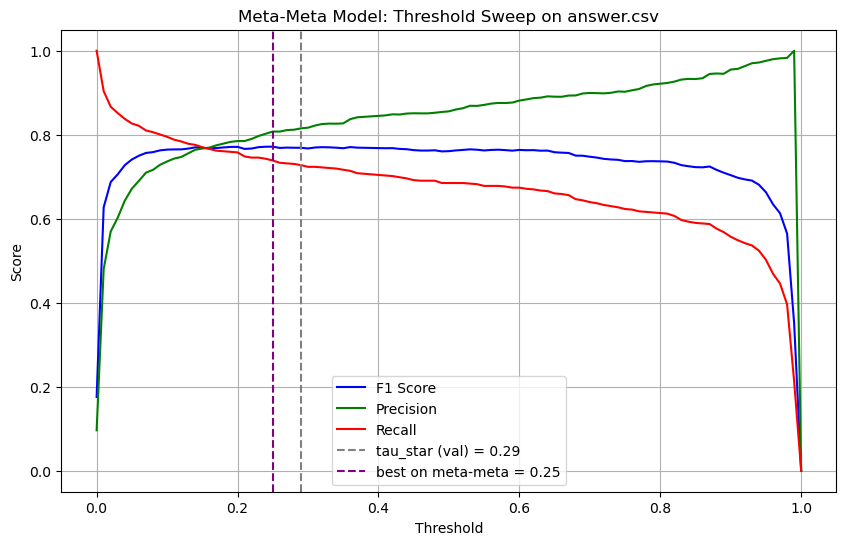

In [51]:
# -----------------------------
# 9. Threshold sweep for Meta‑Meta model
# -----------------------------
import matplotlib.pyplot as plt

# Use aligned arrays from audit_df
y_true = audit_df["flag"].to_numpy()
probas_eval = audit_df["prob_bad"].to_numpy()

thresholds = np.linspace(0.0, 1.0, 101)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (probas_eval >= t).astype(int)
    f1s.append(f1_score(y_true, preds, zero_division=0))
    precisions.append(precision_score(y_true, preds, zero_division=0))
    recalls.append(recall_score(y_true, preds, zero_division=0))

# Find best threshold by F1
best_idx = np.argmax(f1s)
best_tau_meta2 = thresholds[best_idx]

print(f"✅ Best F1 on meta‑meta model = {f1s[best_idx]:.4f} at threshold {best_tau_meta2:.2f}")

# Plot curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1 Score", color="blue")
plt.plot(thresholds, precisions, label="Precision", color="green")
plt.plot(thresholds, recalls, label="Recall", color="red")

# Mark current tau_star and best on meta‑meta
plt.axvline(x=tau_star, color="gray", linestyle="--", label=f"tau_star (val) = {tau_star:.2f}")
plt.axvline(x=best_tau_meta2, color="purple", linestyle="--", label=f"best on meta‑meta = {best_tau_meta2:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Meta‑Meta Model: Threshold Sweep on answer.csv")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------
# Unknown Account Audit (threshold = 0.40)
# -----------------------------
unknown_accounts = meta2_X.index.difference(answer_df.index)
meta2_unknown = meta2_X.loc[unknown_accounts]

# Predict probabilities
probas_unknown = meta2_cat.predict_proba(meta2_unknown)[:, 1]
preds_unknown = (probas_unknown >= 0.40).astype(int)

# Build DataFrame
unknown_audit_df = pd.DataFrame({
    "account": meta2_unknown.index,
    "predicted_flag": preds_unknown,
    "prob_bad": probas_unknown
}).reset_index(drop=True)

# Summary stats
n_total = len(unknown_audit_df)
n_bad = (unknown_audit_df["predicted_flag"] == 1).sum()
n_good = n_total - n_bad
avg_prob_bad = unknown_audit_df["prob_bad"].mean()

print("\n=== Audit Results (Meta‑Meta CatBoost Model, Unknown Accounts) ===")
print("Total accounts audited:", n_total)
print("Predicted bad:", n_bad)
print("Predicted good:", n_good)
print(f"Average prob_bad: {avg_prob_bad:.4f}")
print("⚠️ No accuracy/F1/precision/recall/confusion matrix available (no ground truth)")

# Save report
unknown_audit_df.to_csv("audit_report_meta2_catboost_unknown_v7.csv", index=False)
print("✅ Unknown account audit complete. See audit_report_meta2_catboost_unknown_v7.csv")


=== Audit Results (Meta‑Meta CatBoost Model, Unknown Accounts) ===
Total accounts audited: 17636
Predicted bad: 1790
Predicted good: 15846
Average prob_bad: 0.1048
⚠️ No accuracy/F1/precision/recall/confusion matrix available (no ground truth)
✅ Unknown account audit complete. See audit_report_meta2_catboost_unknown_v7.csv


# per-transactions preparation

In [75]:
import pandas as pd

tx = pd.read_csv("data/transactions.csv")

b2b = tx[
    tx["from_account"].str.startswith("b") & tx["to_account"].str.startswith("b")
]

print(f"Number of b→b transactions: {len(b2b)}")
if len(b2b) > 0:
    print(b2b.head())

Number of b→b transactions: 0


In [37]:
import pandas as pd

tx = pd.read_csv("data/transactions.csv")

a2a = tx[
    tx["from_account"].str.startswith("a") & tx["to_account"].str.startswith("a")
]

print(f"Number of a→a transactions: {len(a2a)}")
if len(a2a) > 0:
    print(a2a.head())

Number of a→a transactions: 35179
    from_account to_account transaction_time_utc value     gas    gas_price
307       a19009     a03045  2020-05-04 13:39:06     0  200000  10000000000
681       a11678     a11678  2020-05-04 16:00:07     0   21000  13310000000
774       a07238     a07238  2020-05-04 16:49:25     0   22000   8470000000
781       a04501     a04501  2020-05-04 16:50:29     0   21000  26666666666
794       a04501     a04501  2020-05-04 16:52:40     0   21000  28571428572


In [38]:
import pandas as pd

tx = pd.read_csv("data/transactions.csv")

a2b = tx[
    tx["from_account"].str.startswith("a") & tx["to_account"].str.startswith("b")
]

print(f"Number of a→b transactions: {len(a2b)}")
if len(a2b) > 0:
    print(a2b.head())

Number of a→b transactions: 2669900
  from_account to_account transaction_time_utc               value     gas  \
0       a00996     b31499  2020-05-04 14:54:03                   0   72585   
1       a07890     b31500  2020-05-04 14:55:06                   0   54426   
2       a22857     b31501  2020-05-04 14:55:23                   0  200000   
3       a07890     b31502  2020-05-04 14:55:23  108900000000000000   21000   
4       a21390     b31501  2020-05-04 14:56:05                   0  149999   

     gas_price  
0  11500000000  
1  11349723260  
2  14024584890  
3  11349723260  
4  32000000000  


In [39]:
import pandas as pd

tx = pd.read_csv("data/transactions.csv")

b2a = tx[
    tx["from_account"].str.startswith("b") & tx["to_account"].str.startswith("a")
]

print(f"Number of b→a transactions: {len(b2a)}")
if len(b2a) > 0:
    print(b2a.head())

Number of b→a transactions: 3121525
   from_account to_account transaction_time_utc               value     gas  \
9        b31507     a18090  2020-05-04 14:59:12   15591996246743622   21000   
10       b31508     a17537  2020-05-04 14:59:12   51222443468611104   50000   
11       b31509     a20539  2020-05-04 14:59:23  243771497588101049   50000   
16       b31510     a29595  2020-05-04 15:00:57                   0  500000   
17       b31510     a29595  2020-05-04 15:00:57                   0  500000   

      gas_price  
9   18499598238  
10  10000000000  
11   1000000000  
16  12480000000  
17  12480000000  


# Overselling experiment

In [91]:
import pandas as pd

neg = pd.read_csv("data/neg_a05944.csv", parse_dates=["transaction_time_utc"])
pos = pd.read_csv("data/pos_a09301.csv", parse_dates=["transaction_time_utc"])

# Ensure numeric types
for col in ["value", "gas", "gas_price"]:
    neg[col] = pd.to_numeric(neg[col], errors="coerce")
    pos[col] = pd.to_numeric(pos[col], errors="coerce")

# Sort by time
neg = neg.sort_values("transaction_time_utc")
pos = pos.sort_values("transaction_time_utc")

In [92]:
def compute_balance(df, account):
    # Profit when account is sender
    df["profit"] = 0.0
    mask_from = df["from_account"] == account
    mask_to   = df["to_account"] == account

    df.loc[mask_from, "profit"] = df.loc[mask_from, "value"] - df.loc[mask_from, "gas"]*df.loc[mask_from, "gas_price"]
    df.loc[mask_to,   "profit"] = -(df.loc[mask_to, "value"] - df.loc[mask_to, "gas"]*df.loc[mask_to, "gas_price"])

    # Net balance
    net_balance = df["profit"].sum()

    # Track overselling: cumulative gas balance
    df["gas_change"] = 0
    df.loc[mask_from, "gas_change"] = -df.loc[mask_from, "gas"]  # sending consumes gas
    df.loc[mask_to,   "gas_change"] = df.loc[mask_to, "gas"]     # receiving adds gas

    df["gas_balance"] = df["gas_change"].cumsum()
    oversell_events = (df["gas_balance"] < 0).sum()

    return net_balance, oversell_events, df

In [93]:
neg_balance, neg_oversell, neg_flow = compute_balance(neg, "a05944")
pos_balance, pos_oversell, pos_flow = compute_balance(pos, "a09301")

print("a05944 net balance:", neg_balance, "oversell events:", neg_oversell)
print("a09301 net balance:", pos_balance, "oversell events:", pos_oversell)

a05944 net balance: 4.627262439341479e+17 oversell events: 548
a09301 net balance: -2.6078808608762624e+17 oversell events: 1527


## sanity check

In [132]:
import polars as pl
import numpy as np

def build_account_stats(transactions_path: str, out_path: str):
    # Load transactions
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )
    tx = tx.with_columns([
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ])

    # Melt into account-centric view
    from_side = tx.select([
        pl.col("from_account").alias("account"),
        pl.col("ts"),
        (pl.col("value") - pl.col("gas") * pl.col("gas_price")).alias("profit"),
        (-pl.col("gas")).alias("gas_change")
    ])
    to_side = tx.select([
        pl.col("to_account").alias("account"),
        pl.col("ts"),
        (-(pl.col("value") - pl.col("gas") * pl.col("gas_price"))).alias("profit"),
        (pl.col("gas")).alias("gas_change")
    ])
    acc_tx = pl.concat([from_side, to_side])

    # Sort by account + time
    acc_tx = acc_tx.sort(["account", "ts"])

    # Compute cumulative gas balance and oversell events
    acc_tx = acc_tx.with_columns([
        pl.col("gas_change").cum_sum().over("account").alias("gas_balance"),
    ])
    acc_tx = acc_tx.with_columns([
        (pl.col("gas_balance") < 0).cast(pl.Int64).alias("oversell_flag")
    ])

    # Aggregate per account
    stats = acc_tx.group_by("account").agg([
        pl.col("profit").sum().alias("net_balance"),
        pl.col("oversell_flag").sum().alias("oversell_freq"),
        pl.len().alias("tx_count")
    ])

    # --- New: log-scale versions (add +1 to avoid log(0)) ---
    stats = stats.with_columns([
        (pl.col("net_balance").abs() + 1).log().alias("net_balance_log"),
        (pl.col("oversell_freq") + 1).log().alias("oversell_freq_log"),
    ])

    # Normalize (min-max scaling)
    stats = stats.with_columns([
        ((pl.col("net_balance") - pl.col("net_balance").min()) /
         (pl.col("net_balance").max() - pl.col("net_balance").min() + 1e-9)).alias("net_balance_norm"),
        ((pl.col("oversell_freq") - pl.col("oversell_freq").min()) /
         (pl.col("oversell_freq").max() - pl.col("oversell_freq").min() + 1e-9)).alias("oversell_freq_norm"),
    ])

    # Continuous profitability ratio
    stats = stats.with_columns([
        (pl.col("net_balance") / (pl.col("tx_count") + 1e-9)).alias("profitability_ratio")
    ])

    # Save with both normalized and log-scaled columns
    stats.select([
        "account",
        "net_balance", "net_balance_norm", "net_balance_log",
        "oversell_freq", "oversell_freq_norm", "oversell_freq_log",
        "profitability_ratio",
        "tx_count"
    ]).write_csv(out_path)

    return stats

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_analysis(stats_path: str, train_acc_path: str, use_log: bool = False, jitter: bool = True):
    """
    Plot scatterplots of account stats vs. labels.

    Parameters
    ----------
    stats_path : str
        Path to account_stats.csv (must include *_norm, *_log, profitability_ratio, tx_count).
    train_acc_path : str
        Path to train_acc.csv (with columns ["account","flag"]).
    use_log : bool
        If True, plot log-scaled features; else plot normalized features.
    jitter : bool
        If True, add small random noise to spread overlapping points.
    """
    stats = pd.read_csv(stats_path)
    train = pd.read_csv(train_acc_path)

    df = stats.merge(train, on="account", how="left")

    # Assign colors
    def color_map(flag):
        if flag == 0: return "blue"   # good
        elif flag == 1: return "red"  # bad
        else: return "gray"           # unknown
    df["color"] = df["flag"].apply(color_map)

    # Choose which columns to plot
    if use_log:
        x1, y1 = "net_balance_log", "oversell_freq_log"
        x2, y2 = "oversell_freq_log", "profitability_ratio"
        label_suffix = " (log scale)"
    else:
        x1, y1 = "net_balance_norm", "oversell_freq_norm"
        x2, y2 = "oversell_freq_norm", "profitability_ratio"
        label_suffix = " (normalized)"

    # Optionally add jitter
    if jitter:
        for col in [x1, y1, x2, y2]:
            if col in df.columns:
                df[col] = df[col] + np.random.normal(0, 0.01, len(df))

    # Compute new ratio feature
    df["ratio_num"] = df["net_balance_norm"] * df["oversell_freq"]
    df["ratio_den"] = df["tx_count"].replace(0, np.nan)  # avoid div/0
    df["ratio"] = df["ratio_num"] / df["ratio_den"]

    # Split by account type
    subsets = {
        "a_only": df[df["account"].str.startswith("a")],
        "b_only": df[df["account"].str.startswith("b")],
        "a+b": df
    }

    for name, sub in subsets.items():
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # --- Plot 1: Net balance vs Oversell freq ---
        axes[0].scatter(sub[x1], sub[y1], c=sub["color"], alpha=0.4, s=20)
        bad = sub[sub["flag"] == 1]
        axes[0].scatter(bad[x1], bad[y1], c="red", edgecolors="black", s=80, label="bad")
        for _, row in bad.iterrows():
            axes[0].text(row[x1], row[y1], row["account"], fontsize=8, color="black")
        axes[0].set_xlabel(x1)
        axes[0].set_ylabel(y1)
        axes[0].set_title(f"Net balance vs Oversell freq ({name}){label_suffix}")

        # --- Plot 2: Oversell freq vs Profitability ratio ---
        axes[1].scatter(sub[x2], sub[y2], c=sub["color"], alpha=0.4, s=20)
        axes[1].scatter(bad[x2], bad[y2], c="red", edgecolors="black", s=80, label="bad")
        for _, row in bad.iterrows():
            axes[1].text(row[x2], row[y2], row["account"], fontsize=8, color="black")
        axes[1].set_xlabel(x2)
        axes[1].set_ylabel(y2)
        axes[1].set_title(f"Oversell freq vs Profitability ratio ({name}){label_suffix}")

        # --- Plot 3: New ratio numerator vs denominator ---
        axes[2].scatter(sub["ratio_num"], sub["ratio_den"], c=sub["color"], alpha=0.4, s=20)
        axes[2].scatter(bad["ratio_num"], bad["ratio_den"], c="red", edgecolors="black", s=80, label="bad")
        for _, row in bad.iterrows():
            axes[2].text(row["ratio_num"], row["ratio_den"], row["account"], fontsize=8, color="black")
        axes[2].set_xlabel("net_balance_norm * oversell_freq")
        axes[2].set_ylabel("tx_count")
        axes[2].set_title(f"New Ratio: numerator vs denominator ({name})")

        plt.tight_layout()
        plt.show()

In [134]:
# ----------  Run dataset generation  ----------
stats = build_account_stats("data/transactions.csv", "data/account_stats_logscale_v4.csv")

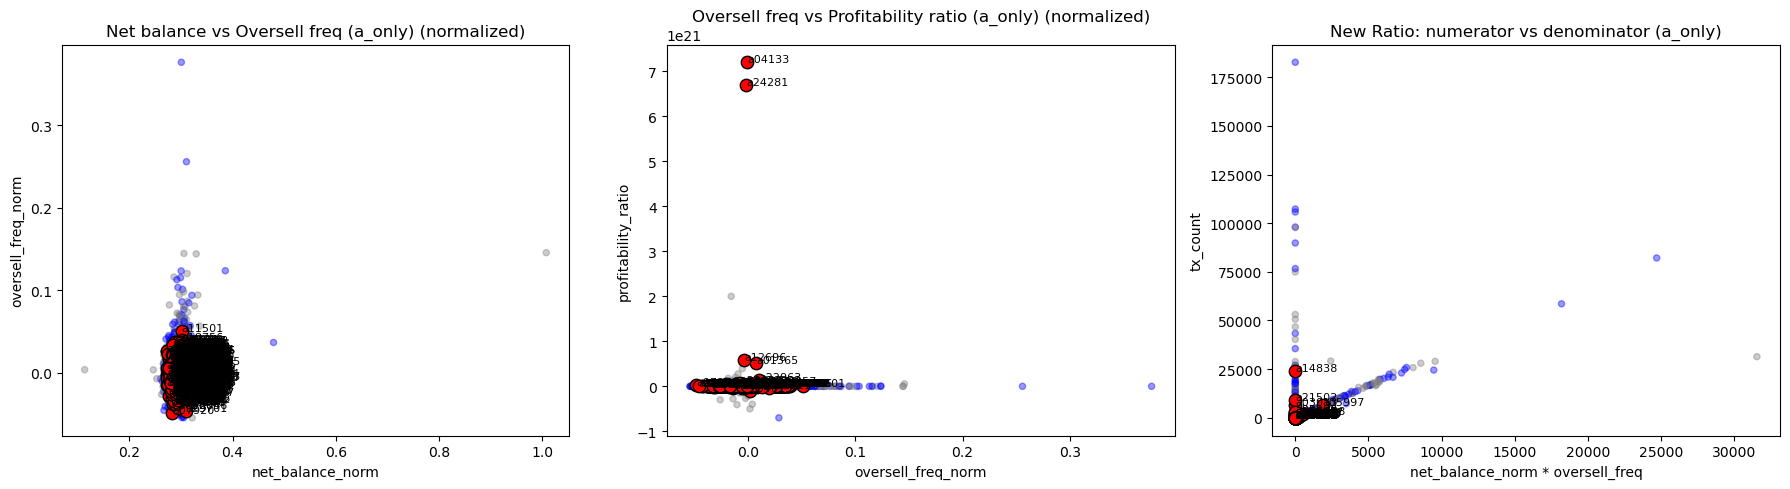

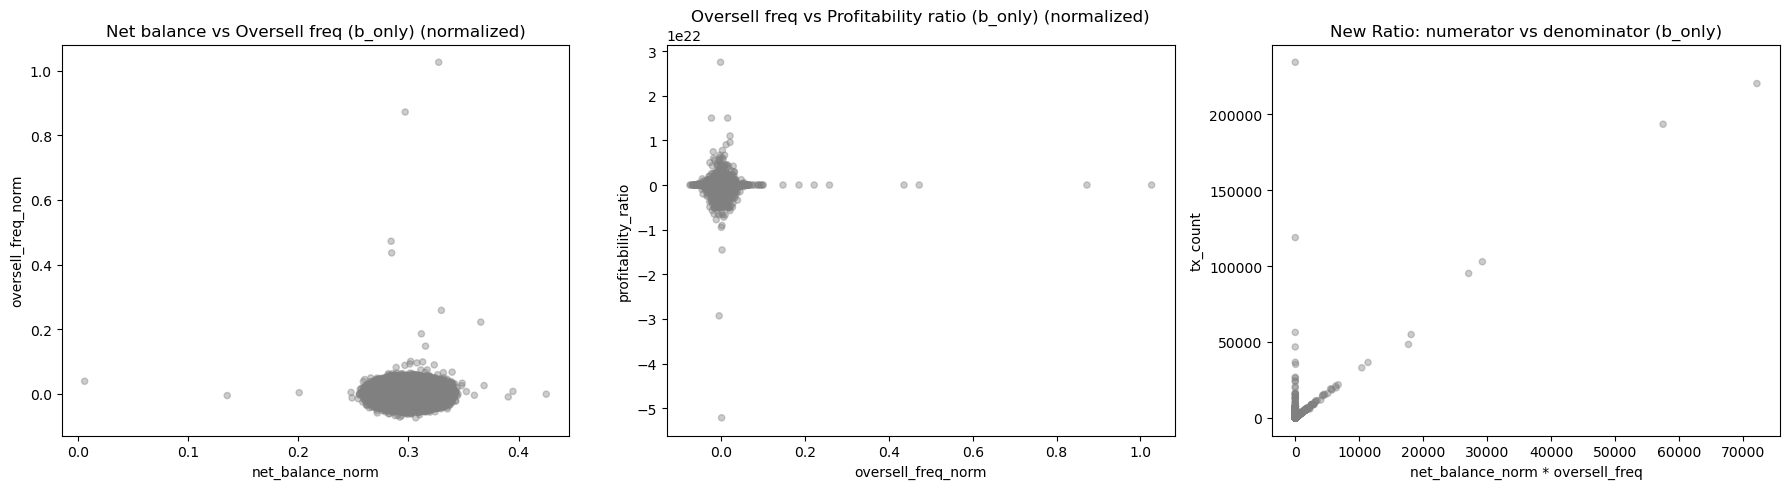

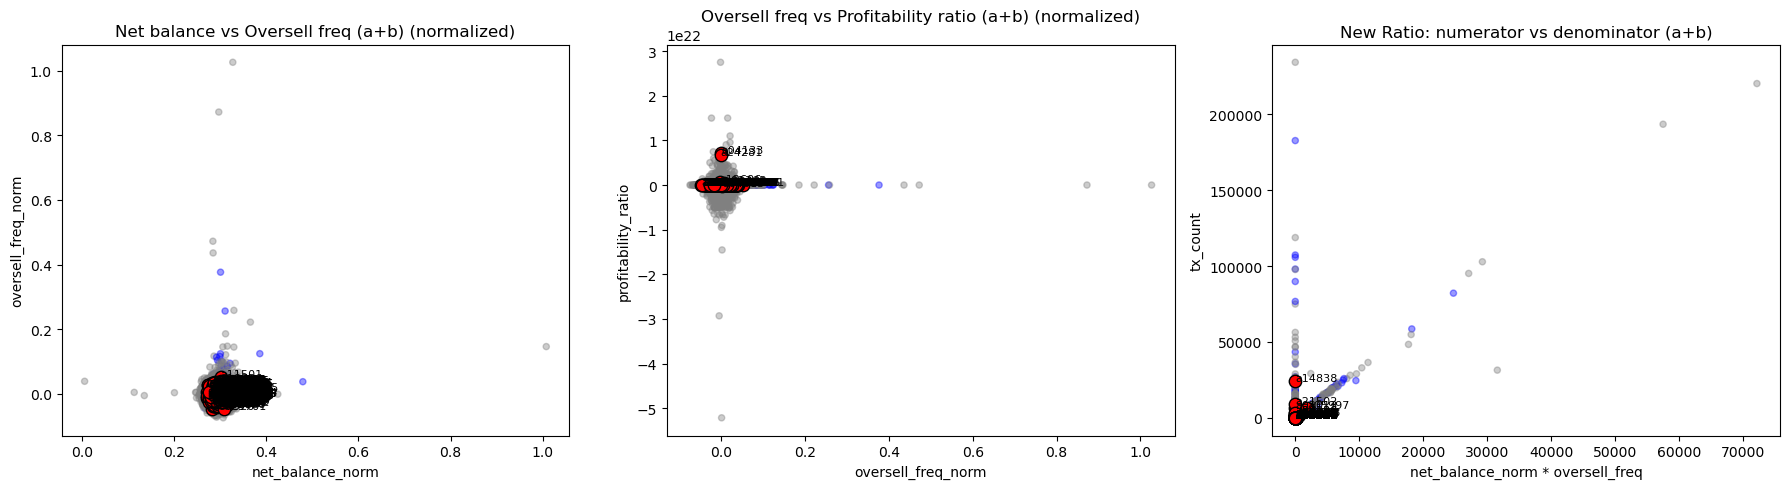

In [ ]:
# ---------- Run plot ----------
plot_analysis("data/account_stats_logscale_v4.csv", "data/train_acc.csv")

## check v2

In [ ]:
import polars as pl
import numpy as np

def build_account_stats(transactions_path: str, out_path: str, half_window: int = 12):
    """
    Build account-level static and dynamic features, including connectivity and
    rate-of-change dynamics.

    Parameters
    ----------
    transactions_path : str
        Path to raw transactions CSV.
    out_path : str
        Path to save the account stats CSV.
    half_window : int
        Length of the first half window in hours (default=12).
    """
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )
    tx = tx.with_columns([
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ])

    # --- Account-centric view ---
    from_side = tx.select([
        pl.col("from_account").alias("account"),
        pl.col("ts"),
        (pl.col("value") - pl.col("gas") * pl.col("gas_price")).alias("profit"),
        (-pl.col("gas")).alias("gas_change"),
        pl.col("to_account").alias("counterparty")
    ])
    to_side = tx.select([
        pl.col("to_account").alias("account"),
        pl.col("ts"),
        (-(pl.col("value") - pl.col("gas") * pl.col("gas_price"))).alias("profit"),
        (pl.col("gas")).alias("gas_change"),
        pl.col("from_account").alias("counterparty")
    ])
    acc_tx = pl.concat([from_side, to_side]).sort(["account", "ts"])

    # --- Gas balance & oversell ---
    acc_tx = acc_tx.with_columns([
        pl.col("gas_change").cum_sum().over("account").alias("gas_balance"),
        (pl.col("gas_balance") < 0).cast(pl.Int64).alias("oversell_flag")
    ])

    # --- Base static stats ---
    stats = acc_tx.group_by("account").agg([
        pl.col("profit").sum().alias("net_balance"),
        pl.col("oversell_flag").sum().alias("oversell_freq"),
        pl.len().alias("tx_count")
    ])

    # --- Counterparty variety ---
    variety = acc_tx.group_by("account").agg([
        pl.col("counterparty").n_unique().alias("unique_partners")
    ])

    # --- Burstiness (inter-arrival times) ---
    iat = acc_tx.with_columns(
        pl.col("ts").diff().dt.total_seconds().alias("iat")
    ).filter(pl.col("iat").is_not_null())

    def safe_cv(arr: np.ndarray) -> float:
        if arr is None or len(arr) < 2:
            return 0.0
        mu, sigma = arr.mean(), arr.std()
        return float(sigma / (mu + 1e-9))

    burst = iat.group_by("account").agg([
        pl.col("iat").map_elements(safe_cv, return_dtype=pl.Float64).alias("burst_cv")
    ])

    # --- Simple burst heuristic: max vs mean tx/hour ---
    tx_per_hour = acc_tx.group_by(["account", pl.col("ts").dt.truncate("1h")]).agg(
        pl.len().alias("tx_per_hour")
    )

    def safe_burst_ratio(arr: np.ndarray) -> float:
        if arr is None or len(arr) < 2:
            return 0.0
        return float(arr.max() / (arr.mean() + 1e-9))

    burst_simple = tx_per_hour.group_by("account").agg([
        pl.col("tx_per_hour").map_elements(safe_burst_ratio, return_dtype=pl.Float64).alias("burst_ratio")
    ])

    # --- Merge static features ---
    stats = stats.join(variety, on="account", how="left")
    stats = stats.join(burst, on="account", how="left")
    stats = stats.join(burst_simple, on="account", how="left")

    # --- Log & normalized versions ---
    stats = stats.with_columns([
        (pl.col("net_balance").abs() + 1).log().alias("net_balance_log"),
        (pl.col("oversell_freq") + 1).log().alias("oversell_freq_log"),
        ((pl.col("net_balance") - pl.col("net_balance").min()) /
         (pl.col("net_balance").max() - pl.col("net_balance").min() + 1e-9)).alias("net_balance_norm"),
        ((pl.col("oversell_freq") - pl.col("oversell_freq").min()) /
         (pl.col("oversell_freq").max() - pl.col("oversell_freq").min() + 1e-9)).alias("oversell_freq_norm"),
        (pl.col("net_balance") / (pl.col("tx_count") + 1e-9)).alias("profitability_ratio"),
        (pl.col("unique_partners") / (pl.col("tx_count") + 1e-9)).alias("variety_score"),
        (1 / (pl.col("tx_count") + 1)).alias("inactivity_penalty")
    ])

    # Normalize burst metrics
    stats = stats.with_columns([
        ((pl.col("burst_cv") - pl.col("burst_cv").min()) /
         (pl.col("burst_cv").max() - pl.col("burst_cv").min() + 1e-9)).alias("burst_cv_norm"),
        ((pl.col("burst_ratio") - pl.col("burst_ratio").min()) /
         (pl.col("burst_ratio").max() - pl.col("burst_ratio").min() + 1e-9)).alias("burst_ratio_norm"),
    ])

    # --- Connectivity score ---
    stats = stats.with_columns([
        (0.3*pl.col("net_balance_norm") +
         0.2*pl.col("variety_score") +
         0.25*pl.col("burst_cv_norm") +
         0.15*pl.col("burst_ratio_norm") -
         0.1*pl.col("inactivity_penalty")).alias("connectivity_score")
    ])

    # ------------------------------------------------------------
    # Dynamic features: split into halves
    # ------------------------------------------------------------
    acc_tx = acc_tx.with_columns([
        ((pl.col("ts") - pl.col("ts").min().over("account"))
         .dt.total_hours()).alias("elapsed_hours")
    ])
    acc_tx = acc_tx.with_columns([
        (pl.col("elapsed_hours") < half_window).alias("first_half")
    ])

    half_stats = acc_tx.group_by(["account", "first_half"]).agg([
        pl.col("profit").sum().alias("net_balance_half"),
        pl.col("oversell_flag").sum().alias("oversell_half"),
        pl.len().alias("tx_count_half")
    ])

    half_stats = half_stats.pivot(
        values=["net_balance_half", "oversell_half", "tx_count_half"],
        index="account",
        on="first_half"
    ).rename({
        "net_balance_half_true": "net_balance_first",
        "net_balance_half_false": "net_balance_second",
        "oversell_half_true": "oversell_first",
        "oversell_half_false": "oversell_second",
        "tx_count_half_true": "tx_first",
        "tx_count_half_false": "tx_second",
    }).fill_null(0)

    dynamics = half_stats.with_columns([
        ((pl.col("oversell_second") - pl.col("oversell_first")) /
         (pl.col("oversell_first") + 1e-9)).alias("roc_oversell"),
        ((pl.col("net_balance_second") - pl.col("net_balance_first")) /
         (pl.col("net_balance_first").abs() + 1e-9)).alias("roc_net_balance"),
        ((pl.col("tx_second") - pl.col("tx_first")) /
         (pl.col("tx_first") + 1e-9)).alias("roc_tx_count"),
    ])

    for col in ["roc_oversell", "roc_net_balance", "roc_tx_count"]:
        dynamics = dynamics.with_columns([
            (pl.col(col).abs() + 1).log().alias(f"{col}_log"),
            ((pl.col(col) - pl.col(col).min()) /
             (pl.col(col).max() - pl.col(col).min() + 1e-9)).alias(f"{col}_norm")
        ])

    # --- Merge static + dynamic ---
    stats = stats.join(dynamics, on="account", how="left")

    # --- Save ---
    stats.write_csv(out_path)
    return stats

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_analysis(
    stats_path: str,
    train_acc_path: str,
    use_log: bool = False,
    jitter: bool = True,
    show_corr: bool = True
):
    """
    Plot static and dynamic account features vs. labels, with optional correlation heatmap.

    Parameters
    ----------
    stats_path : str
        Path to account_stats.csv (must include static + dynamic features).
    train_acc_path : str
        Path to train_acc.csv (with columns ["account","flag"]).
    use_log : bool
        If True, plot log-scaled features; else plot normalized features.
    jitter : bool
        If True, add small random noise to spread overlapping points.
    show_corr : bool
        If True, show correlation heatmap (default=True).
    """
    stats = pd.read_csv(stats_path)
    train = pd.read_csv(train_acc_path)
    df = stats.merge(train, on="account", how="left")

    # Assign colors
    def color_map(flag):
        if flag == 0: return "blue"   # good
        elif flag == 1: return "red"  # bad
        else: return "gray"           # unknown
    df["color"] = df["flag"].apply(color_map)

    # Choose static axes
    if use_log:
        x1, y1 = "net_balance_log", "oversell_freq_log"
        label_suffix = " (log scale)"
    else:
        x1, y1 = "net_balance_norm", "oversell_freq_norm"
        label_suffix = " (normalized)"

    # Optionally add jitter
    if jitter:
        for col in [x1, y1, "profitability_ratio", "connectivity_score",
                    "roc_oversell", "roc_net_balance", "roc_tx_count"]:
            if col in df.columns:
                df[col] = df[col] + np.random.normal(0, 0.01, len(df))

    # Split by account type
    subsets = {
        "a_only": df[df["account"].str.startswith("a")],
        "b_only": df[df["account"].str.startswith("b")],
        "a+b": df
    }

    for name, sub in subsets.items():
        fig, axes = plt.subplots(2, 5, figsize=(25, 10))
        axes = axes.flatten()

        bad = sub[sub["flag"] == 1]

        plots = [
            (x1, y1, f"Net balance vs Oversell freq {label_suffix}"),
            ("connectivity_score", y1, "Connectivity vs Oversell freq"),
            ("connectivity_score", "profitability_ratio", "Connectivity vs Profitability ratio"),
            ("connectivity_score", x1, f"Connectivity vs Net balance {label_suffix}"),
            ("connectivity_score", "tx_count", "Connectivity vs Tx count"),
            ("roc_oversell", "roc_net_balance", "ROC Oversell vs ROC Net balance"),
            ("roc_oversell", "roc_tx_count", "ROC Oversell vs ROC Tx count"),
            ("roc_net_balance", "roc_tx_count", "ROC Net balance vs ROC Tx count"),
            ("connectivity_score", "roc_oversell", "Connectivity vs ROC Oversell"),
            ("connectivity_score", "roc_net_balance", "Connectivity vs ROC Net balance"),
        ]

        for ax, (xcol, ycol, title) in zip(axes, plots):
            if xcol not in sub.columns or ycol not in sub.columns:
                continue
            ax.scatter(sub[xcol], sub[ycol], c=sub["color"], alpha=0.4, s=20)
            ax.scatter(bad[xcol], bad[ycol], c="red", edgecolors="black",
                       s=35, linewidths=0.5, label="bad")  # smaller red points
            ax.set_xlabel(xcol)
            ax.set_ylabel(ycol)
            ax.set_title(f"{title} ({name})")

        plt.tight_layout()
        plt.show()

        # --- Optional correlation heatmap ---
        if show_corr:
            feature_cols = [
                "net_balance_norm", "oversell_freq_norm", "profitability_ratio",
                "connectivity_score", "tx_count",
                "roc_oversell", "roc_net_balance", "roc_tx_count"
            ]
            available = [c for c in feature_cols if c in sub.columns]
            corr = sub[available].corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                        cbar_kws={"shrink": 0.8})
            plt.title(f"Correlation Heatmap ({name})")
            plt.tight_layout()
            plt.show()

In [13]:
# ---------- Step 3: Run ----------
stats = build_account_stats("data/transactions.csv", "data/account_stats_burst_v1.csv")

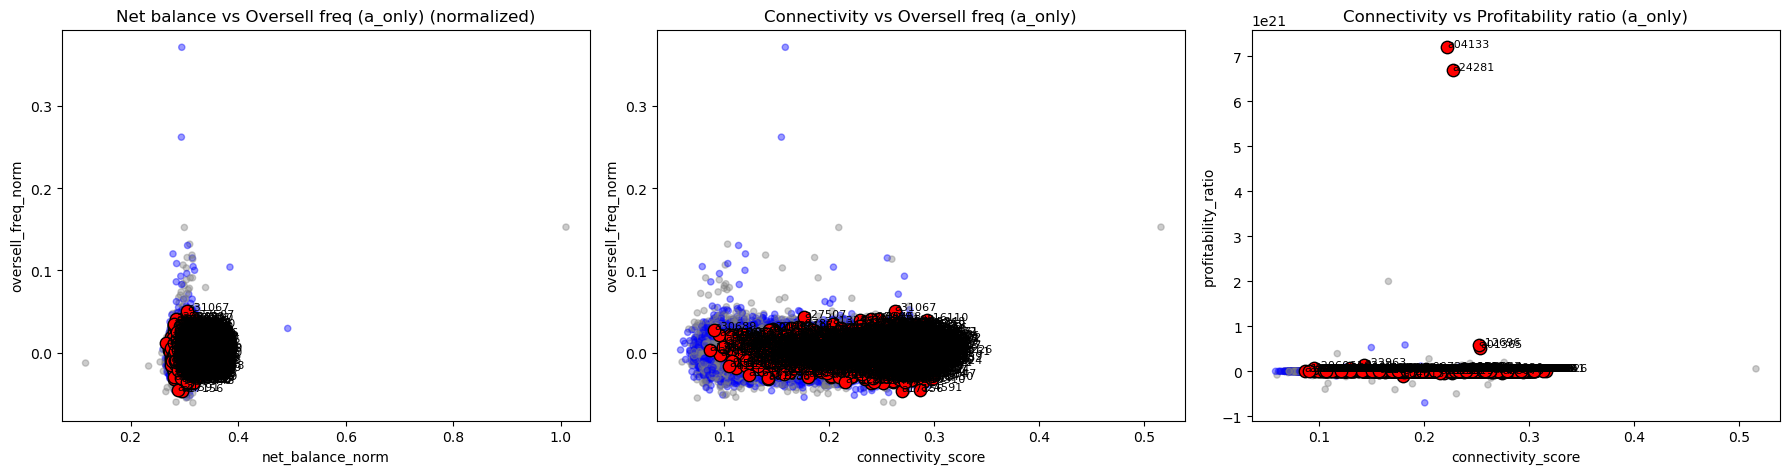

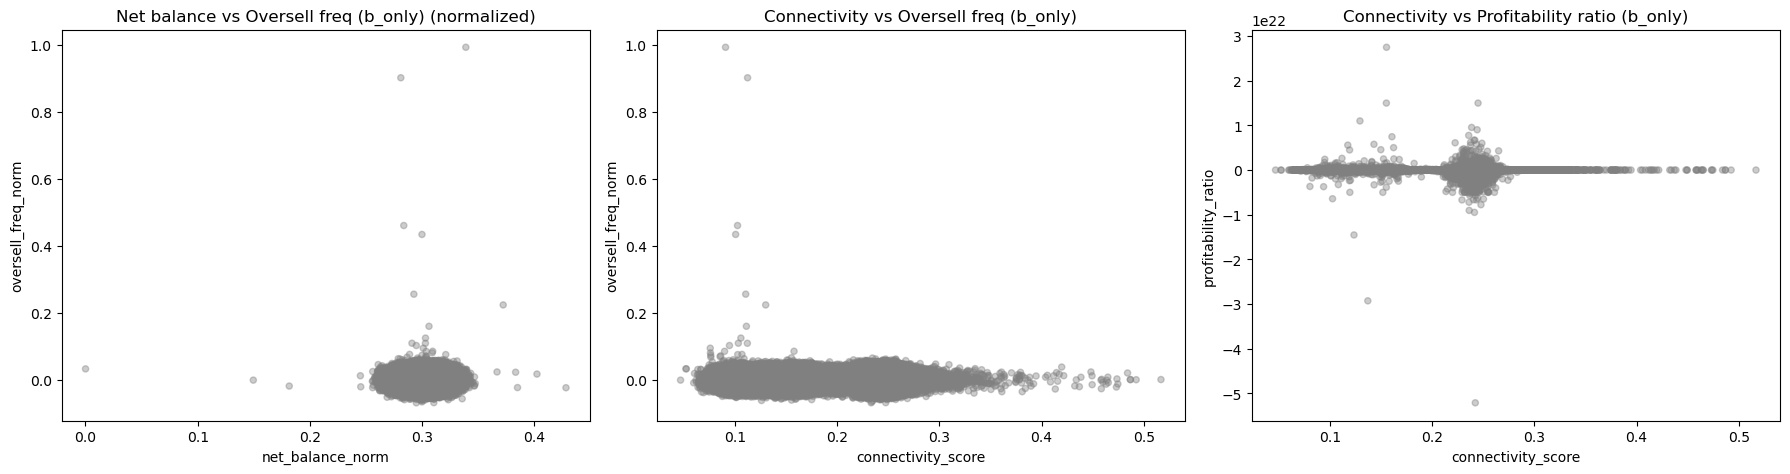

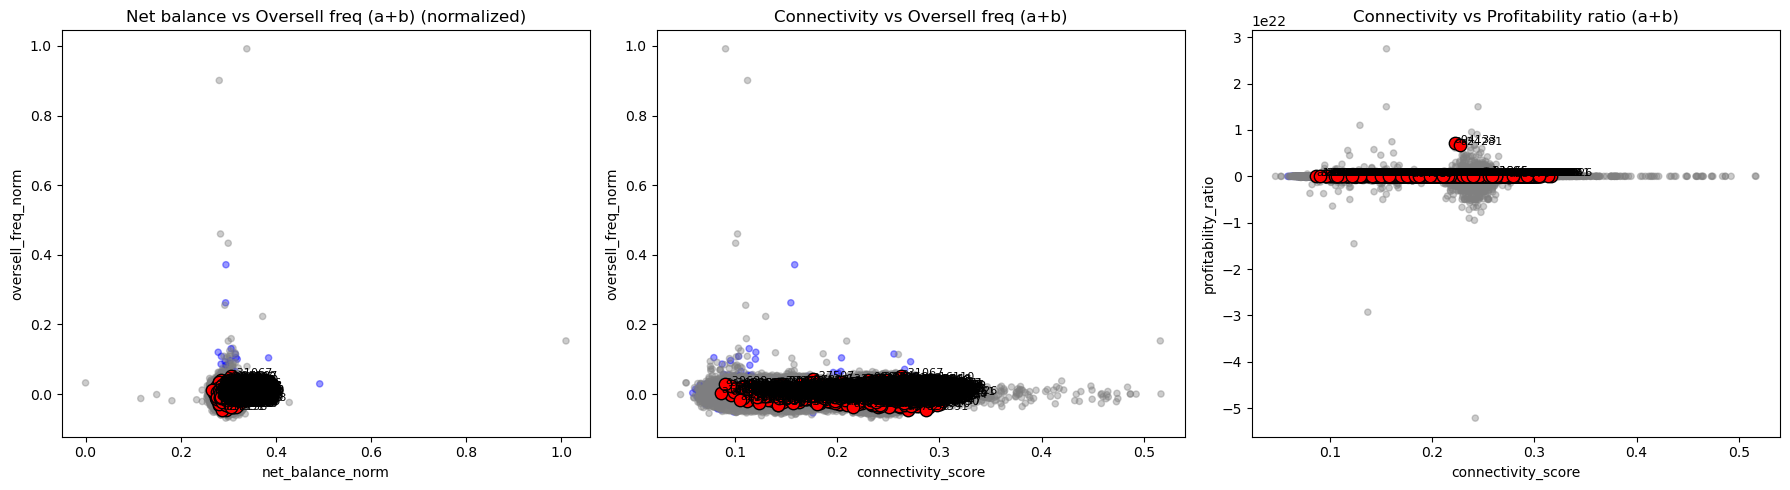

In [14]:
# ---------- Step 3: Run ----------
plot_analysis("data/account_stats_burst_v1.csv", "data/train_acc.csv")

# New overselling experiment

In [26]:
import polars as pl
import numpy as np

def build_account_stats(transactions_path: str, out_path: str, half_window: int = 12):
    """
    Build account-level static and dynamic features, including connectivity and
    rate-of-change dynamics.
    """
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )
    tx = tx.with_columns([
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ])

    # --- Account-centric view ---
    from_side = tx.select([
        pl.col("from_account").alias("account"),
        pl.col("ts"),
        (pl.col("value") - pl.col("gas") * pl.col("gas_price")).alias("profit"),
        (-pl.col("gas")).alias("gas_change"),
        pl.col("to_account").alias("counterparty")
    ])
    to_side = tx.select([
        pl.col("to_account").alias("account"),
        pl.col("ts"),
        (-(pl.col("value") - pl.col("gas") * pl.col("gas_price"))).alias("profit"),
        (pl.col("gas")).alias("gas_change"),
        pl.col("from_account").alias("counterparty")
    ])
    acc_tx = pl.concat([from_side, to_side]).sort(["account", "ts"])

    # --- Gas balance & oversell ---
    acc_tx = acc_tx.with_columns([
        pl.col("gas_change").cum_sum().over("account").alias("gas_balance")
    ])
    acc_tx = acc_tx.with_columns([
        (pl.col("gas_balance") < 0).cast(pl.Int64).alias("oversell_flag")
    ])

    # --- Base static stats ---
    stats = acc_tx.group_by("account").agg([
        pl.col("profit").sum().alias("net_balance"),
        pl.col("oversell_flag").sum().alias("oversell_freq"),
        pl.len().alias("tx_count")
    ])

    # --- Counterparty variety ---
    variety = acc_tx.group_by("account").agg([
        pl.col("counterparty").n_unique().alias("unique_partners")
    ])

    # --- Merge variety ---
    stats = stats.join(variety, on="account", how="left")

    # --- Log & normalized versions ---
    stats = stats.with_columns([
        (pl.col("net_balance").abs() + 1).log().alias("net_balance_log"),
        (pl.col("oversell_freq") + 1).log().alias("oversell_freq_log"),
        ((pl.col("net_balance") - pl.col("net_balance").min()) /
         (pl.col("net_balance").max() - pl.col("net_balance").min() + 1e-9)).alias("net_balance_norm"),
        ((pl.col("oversell_freq") - pl.col("oversell_freq").min()) /
         (pl.col("oversell_freq").max() - pl.col("oversell_freq").min() + 1e-9)).alias("oversell_freq_norm"),
        (pl.col("net_balance") / (pl.col("tx_count") + 1e-9)).alias("profitability_ratio"),
        (pl.col("unique_partners") / (pl.col("tx_count") + 1e-9)).alias("variety_score"),
        (1 / (pl.col("tx_count") + 1)).alias("inactivity_penalty")
    ])

    # --- Connectivity score ---
    stats = stats.with_columns([
        (0.3*pl.col("net_balance_norm") +
         0.2*pl.col("variety_score") -
         0.1*pl.col("inactivity_penalty")).alias("connectivity_score")
    ])

    # ------------------------------------------------------------
    # Dynamic features: split into halves
    # ------------------------------------------------------------
    acc_tx = acc_tx.with_columns([
        ((pl.col("ts") - pl.col("ts").min().over("account"))
         .dt.total_hours()).alias("elapsed_hours")
    ])
    acc_tx = acc_tx.with_columns([
        (pl.col("elapsed_hours") < half_window).alias("first_half")
    ])

    half_stats = acc_tx.group_by(["account", "first_half"]).agg([
        pl.col("profit").sum().alias("net_balance_half"),
        pl.col("oversell_flag").sum().alias("oversell_half"),
        pl.len().alias("tx_count_half")
    ])

    half_stats = half_stats.pivot(
        values=["net_balance_half", "oversell_half", "tx_count_half"],
        index="account",
        on="first_half"
    ).rename({
        "net_balance_half_true": "net_balance_first",
        "net_balance_half_false": "net_balance_second",
        "oversell_half_true": "oversell_first",
        "oversell_half_false": "oversell_second",
        "tx_count_half_true": "tx_first",
        "tx_count_half_false": "tx_second",
    }).fill_null(0)

    dynamics = half_stats.with_columns([
        ((pl.col("oversell_second") - pl.col("oversell_first")) /
         (pl.col("oversell_first") + 1e-9)).alias("roc_oversell"),
        ((pl.col("net_balance_second") - pl.col("net_balance_first")) /
         (pl.col("net_balance_first").abs() + 1e-9)).alias("roc_net_balance"),
        ((pl.col("tx_second") - pl.col("tx_first")) /
         (pl.col("tx_first") + 1e-9)).alias("roc_tx_count"),
    ])

    for col in ["roc_oversell", "roc_net_balance", "roc_tx_count"]:
        dynamics = dynamics.with_columns([
            (pl.col(col).abs() + 1).log().alias(f"{col}_log"),
            ((pl.col(col) - pl.col(col).min()) /
             (pl.col(col).max() - pl.col(col).min() + 1e-9)).alias(f"{col}_norm")
        ])

    # --- Merge static + dynamic ---
    stats = stats.join(dynamics, on="account", how="left")

    # --- Save ---
    stats.write_csv(out_path)
    return stats

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_analysis(
    stats_path: str,
    train_acc_path: str,
    use_log: bool = False,
    jitter: bool = True,
    show_corr: bool = True
):
    """
    Plot static and dynamic account features vs. labels, with optional correlation heatmap.

    Parameters
    ----------
    stats_path : str
        Path to account_stats.csv (must include static + dynamic features).
    train_acc_path : str
        Path to train_acc.csv (with columns ["account","flag"]).
    use_log : bool
        If True, plot log-scaled features; else plot normalized features.
    jitter : bool
        If True, add small random noise to spread overlapping points.
    show_corr : bool
        If True, show correlation heatmap (default=True).
    """
    stats = pd.read_csv(stats_path)
    train = pd.read_csv(train_acc_path)
    df = stats.merge(train, on="account", how="left")

    # Assign colors
    def color_map(flag):
        if flag == 0: return "blue"   # good
        elif flag == 1: return "red"  # bad
        else: return "gray"           # unknown
    df["color"] = df["flag"].apply(color_map)

    # Choose static axes
    if use_log:
        x1, y1 = "net_balance_log", "oversell_freq_log"
        label_suffix = " (log scale)"
    else:
        x1, y1 = "net_balance_norm", "oversell_freq_norm"
        label_suffix = " (normalized)"

    # Optionally add jitter
    if jitter:
        for col in [x1, y1, "profitability_ratio", "connectivity_score",
                    "roc_oversell", "roc_net_balance", "roc_tx_count"]:
            if col in df.columns:
                df[col] = df[col] + np.random.normal(0, 0.01, len(df))

    # Split by account type
    subsets = {
        "a_only": df[df["account"].str.startswith("a")],
        "b_only": df[df["account"].str.startswith("b")],
        "a+b": df
    }

    for name, sub in subsets.items():
        fig, axes = plt.subplots(2, 5, figsize=(25, 10))
        axes = axes.flatten()

        bad = sub[sub["flag"] == 1]

        plots = [
            (x1, y1, f"Net balance vs Oversell freq {label_suffix}"),
            ("connectivity_score", y1, "Connectivity vs Oversell freq"),
            ("connectivity_score", "profitability_ratio", "Connectivity vs Profitability ratio"),
            ("connectivity_score", x1, f"Connectivity vs Net balance {label_suffix}"),
            ("connectivity_score", "tx_count", "Connectivity vs Tx count"),
            ("roc_oversell", "roc_net_balance", "ROC Oversell vs ROC Net balance"),
            ("roc_oversell", "roc_tx_count", "ROC Oversell vs ROC Tx count"),
            ("roc_net_balance", "roc_tx_count", "ROC Net balance vs ROC Tx count"),
            ("connectivity_score", "roc_oversell", "Connectivity vs ROC Oversell"),
            ("connectivity_score", "roc_net_balance", "Connectivity vs ROC Net balance"),
        ]

        for ax, (xcol, ycol, title) in zip(axes, plots):
            if xcol not in sub.columns or ycol not in sub.columns:
                continue
            ax.scatter(sub[xcol], sub[ycol], c=sub["color"], alpha=0.4, s=20)
            ax.scatter(bad[xcol], bad[ycol], c="red", edgecolors="black",
                       s=35, linewidths=0.5, label="bad")  # smaller red points
            ax.set_xlabel(xcol)
            ax.set_ylabel(ycol)
            ax.set_title(f"{title} ({name})")

        plt.tight_layout()
        plt.show()

        # --- Optional correlation heatmap ---
        if show_corr:
            feature_cols = [
                "net_balance_norm", "oversell_freq_norm", "profitability_ratio",
                "connectivity_score", "tx_count",
                "roc_oversell", "roc_net_balance", "roc_tx_count"
            ]
            available = [c for c in feature_cols if c in sub.columns]
            corr = sub[available].corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                        cbar_kws={"shrink": 0.8})
            plt.title(f"Correlation Heatmap ({name})")
            plt.tight_layout()
            plt.show()

In [27]:
# ---------- Step 3: Run ----------
stats = build_account_stats("data/transactions.csv", "data/account_dynamics_burst_v1.csv")

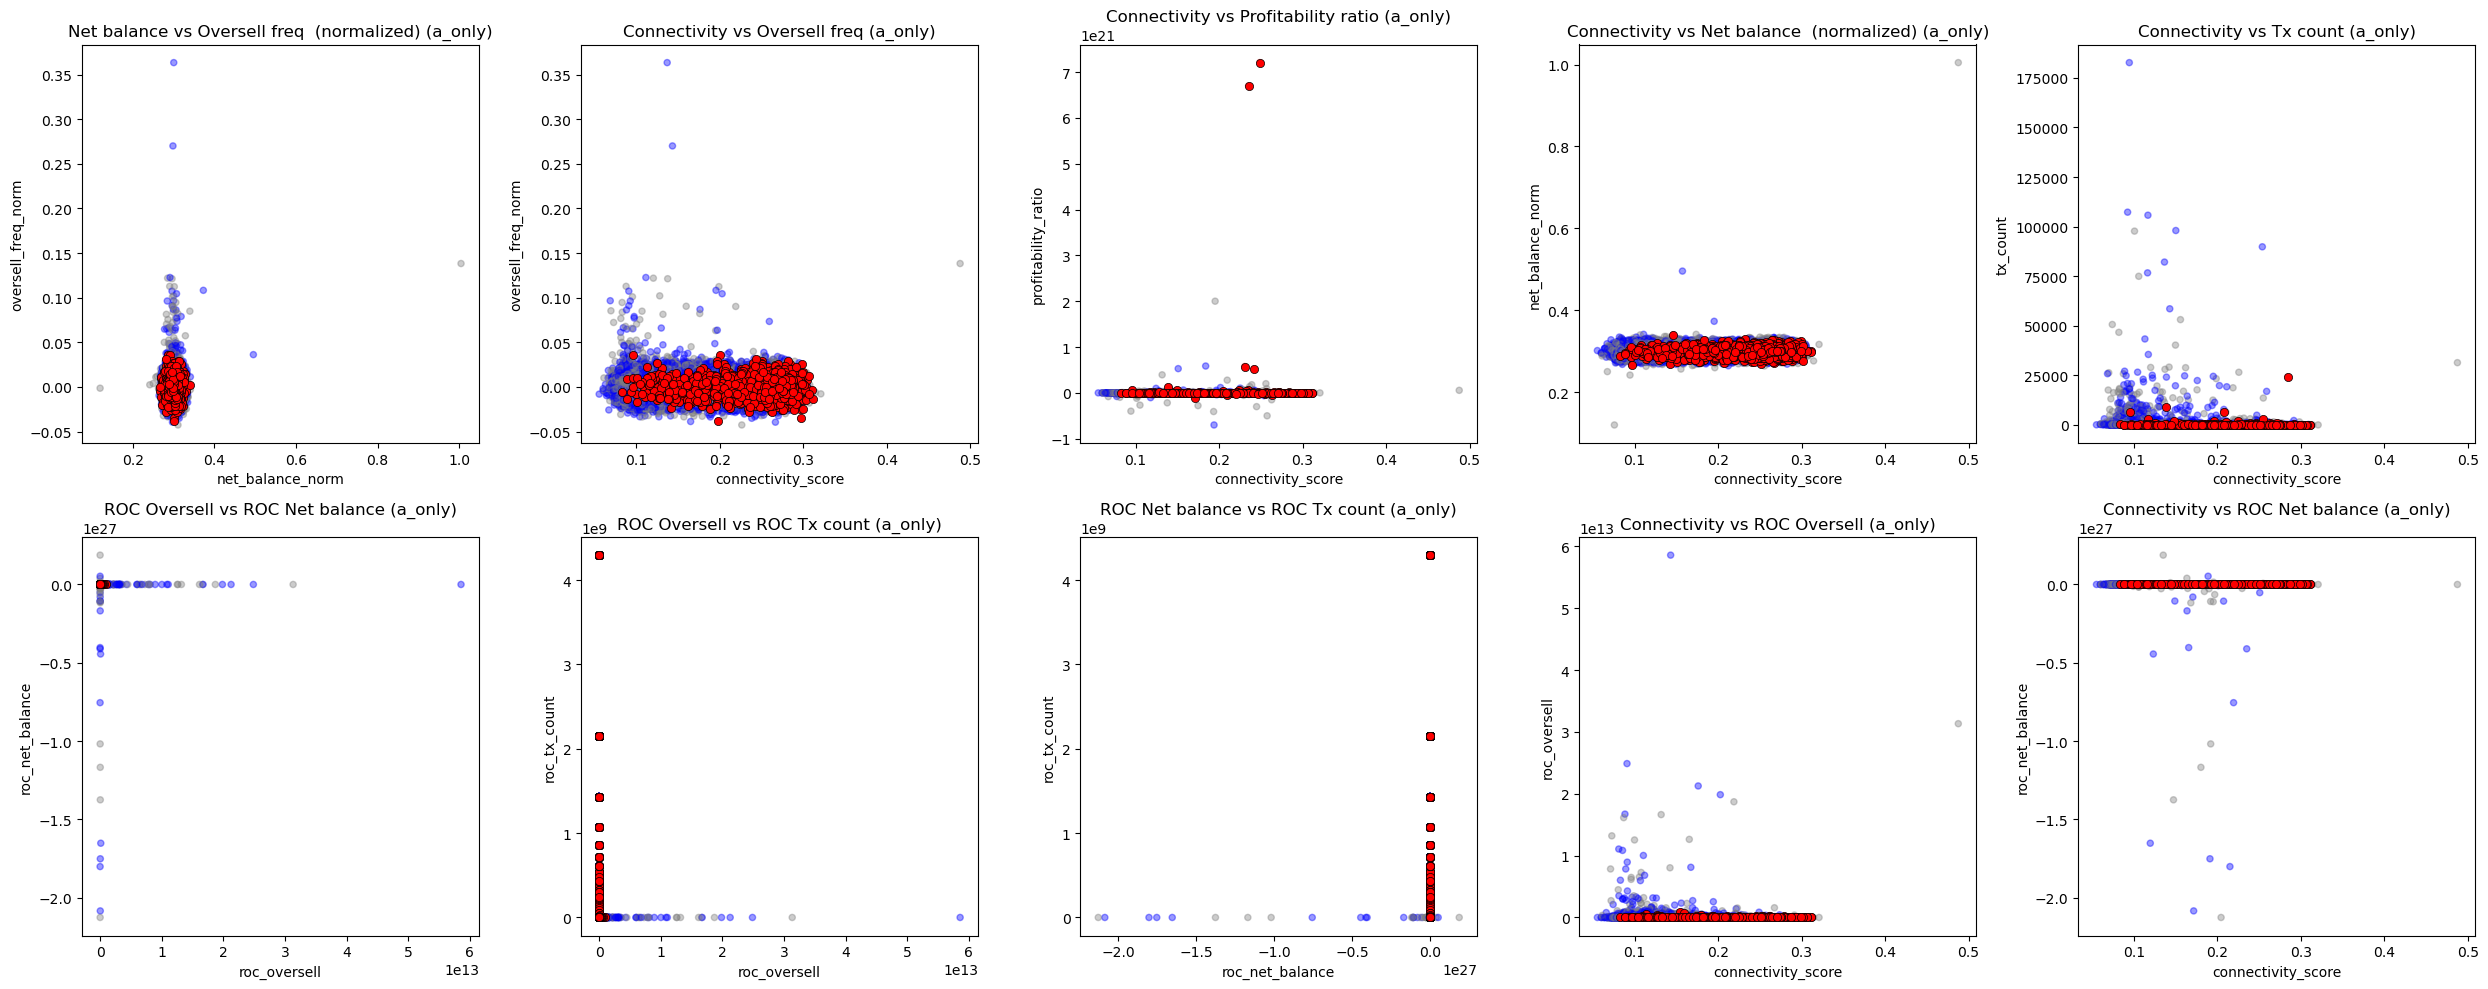

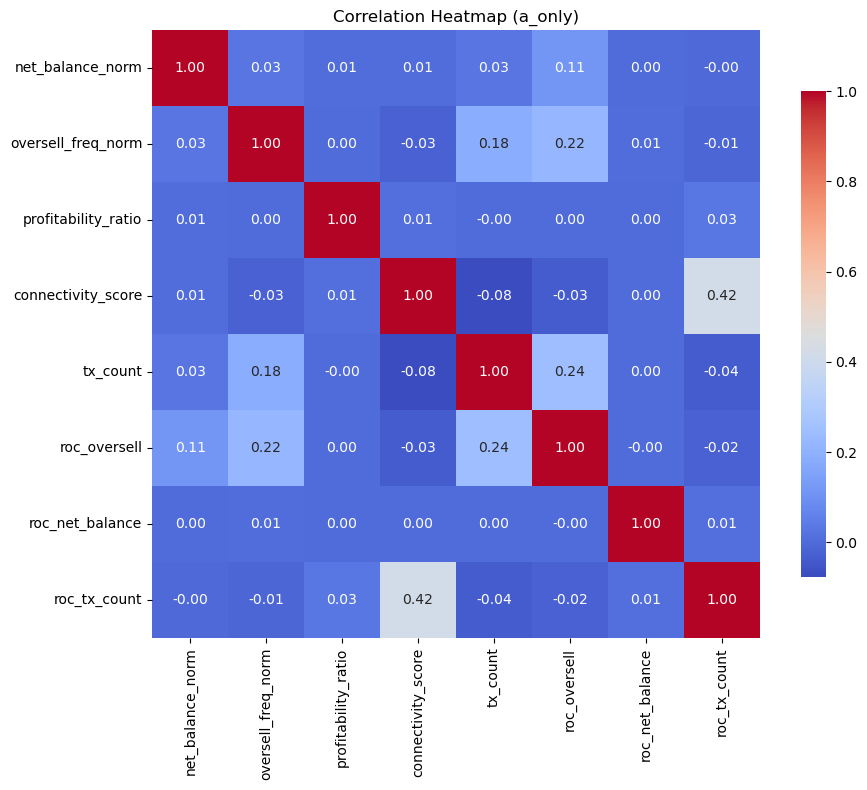

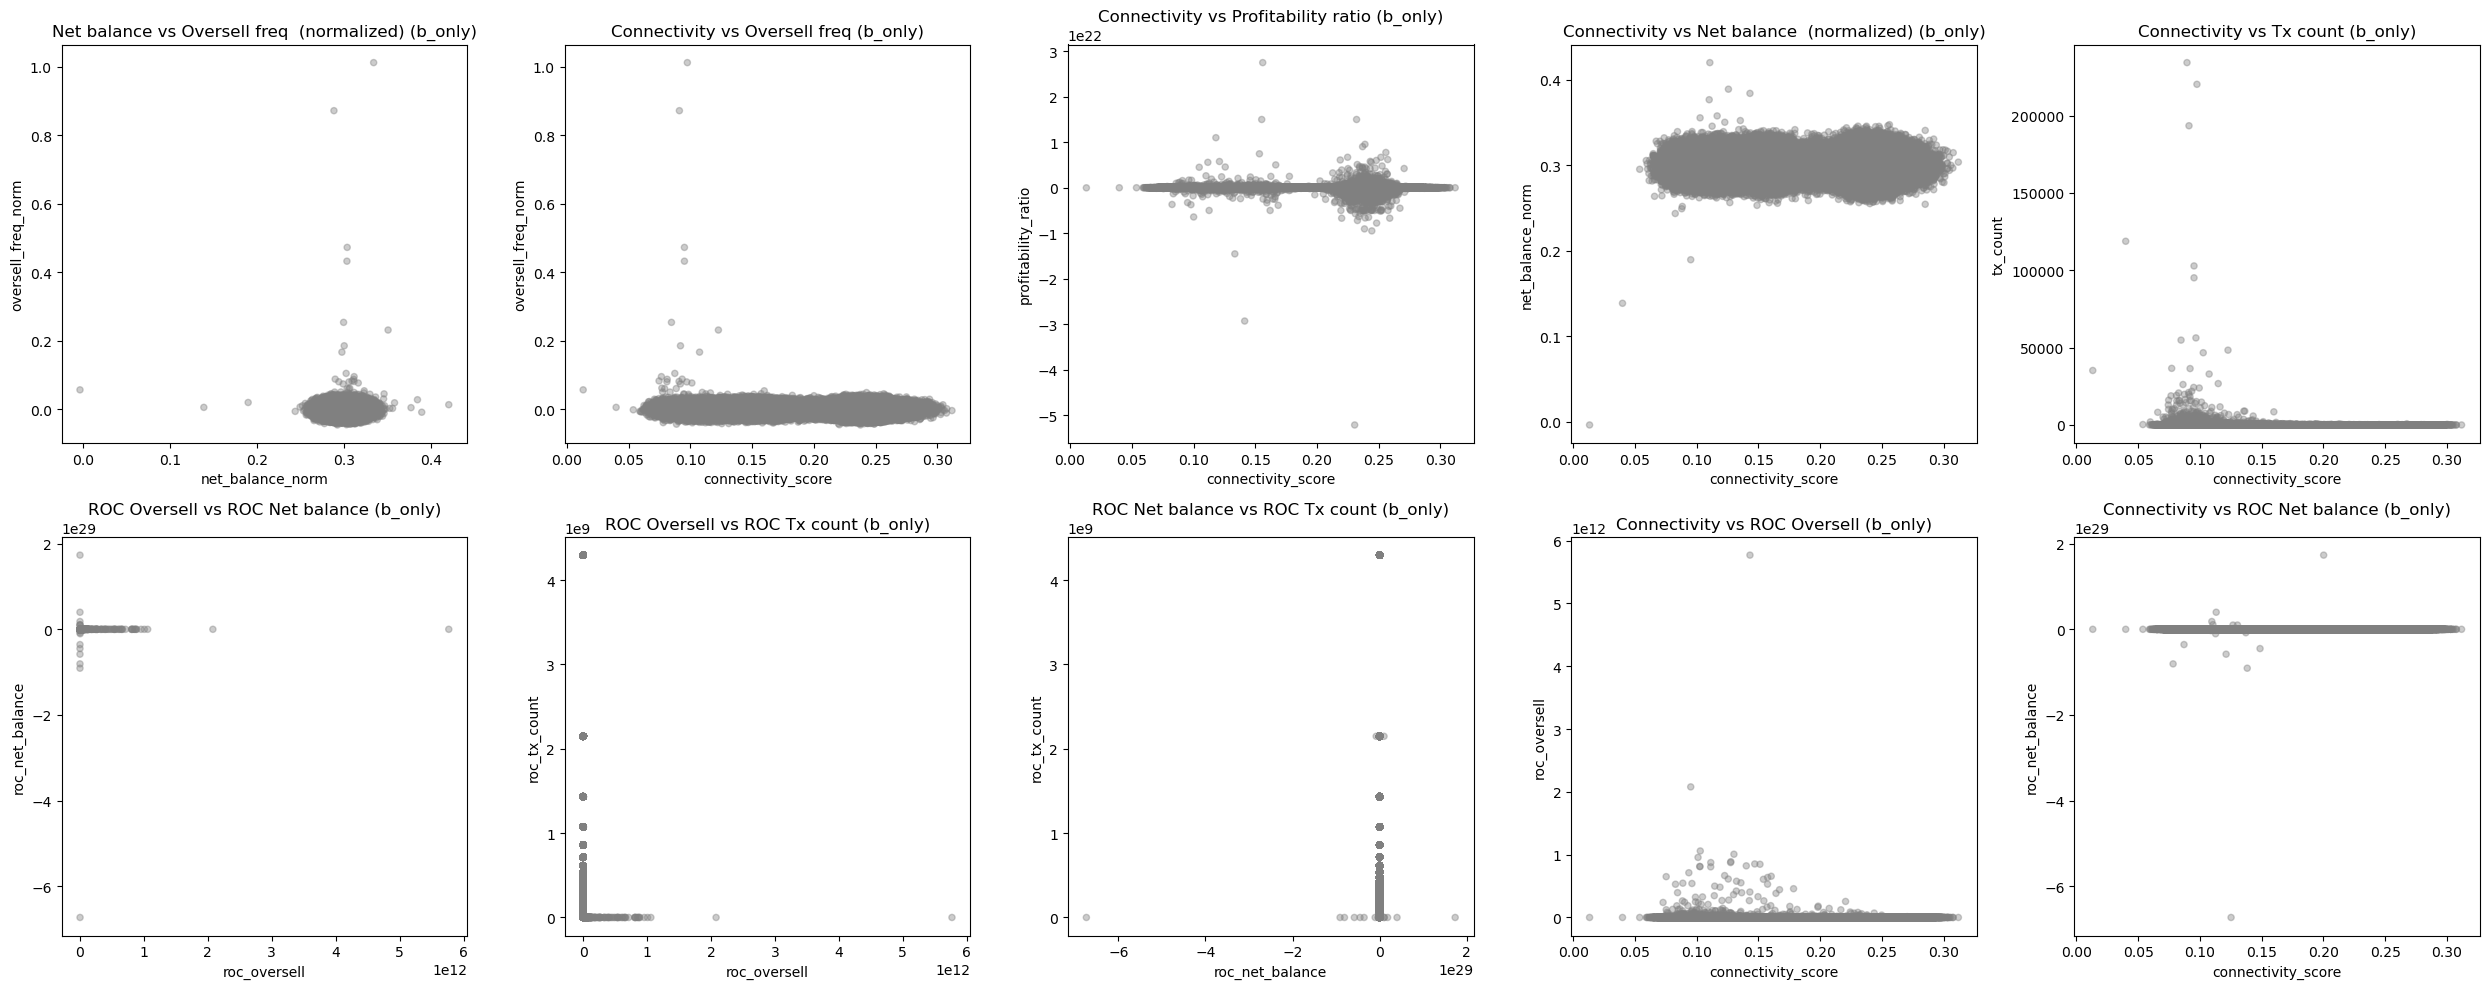

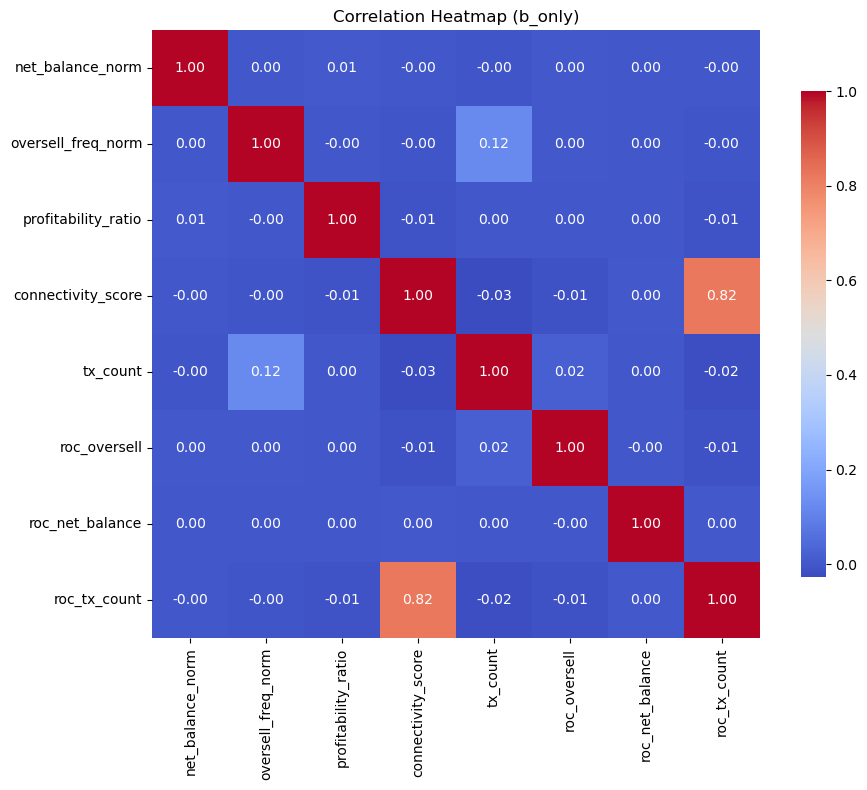

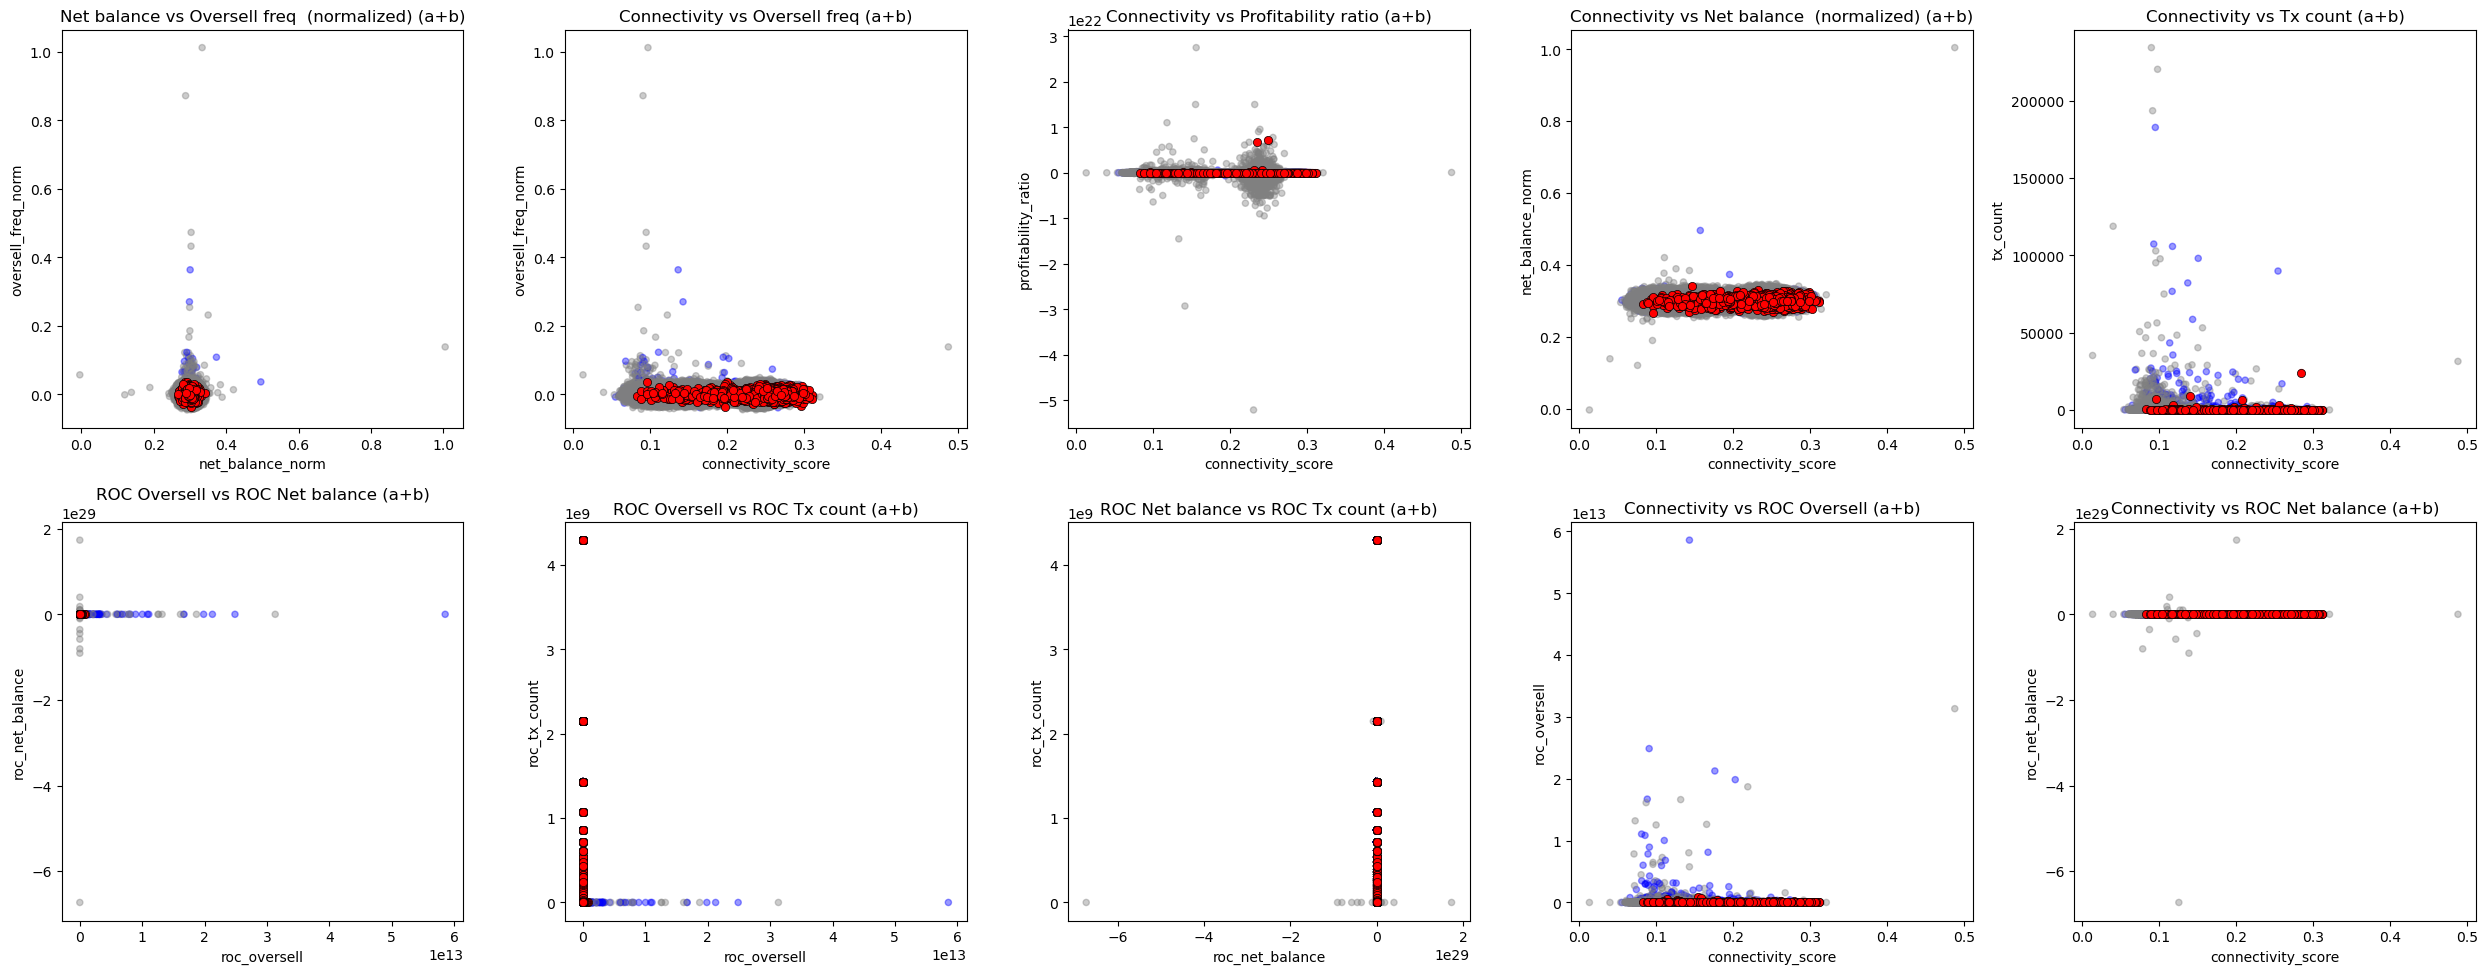

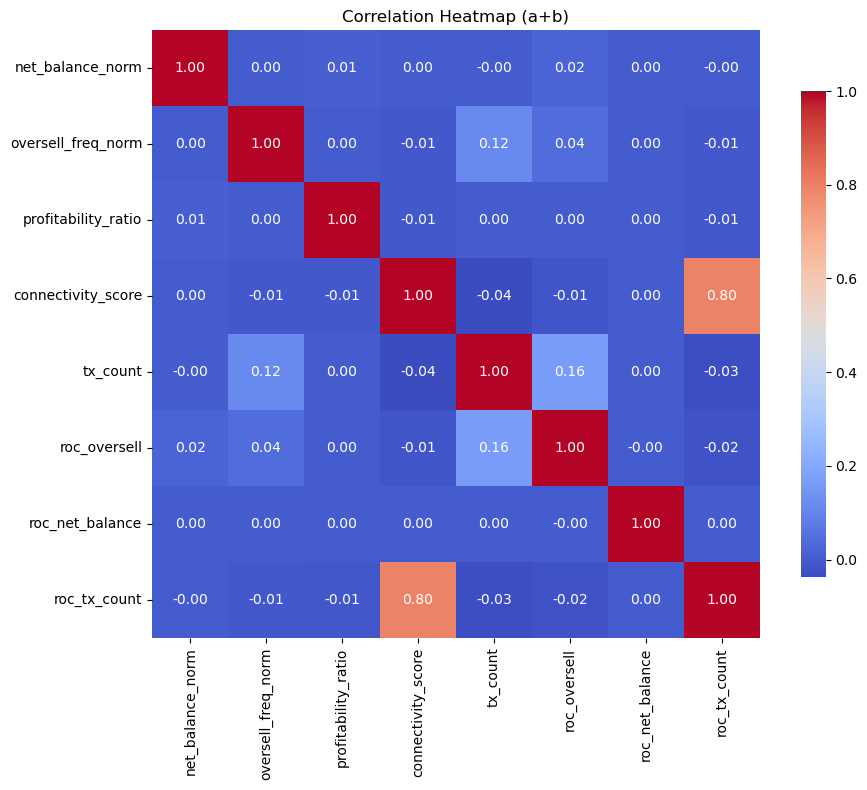

In [28]:
# ---------- Step 3: Run ----------
plot_analysis("data/account_dynamics_burst_v1.csv", "data/train_acc.csv")

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def evaluate_feature_importance(stats_path: str, train_acc_path: str, use_log: bool = False):
    # Load data
    stats = pd.read_csv(stats_path)
    train = pd.read_csv(train_acc_path)
    df = stats.merge(train, on="account", how="left")

    # Exclude accounts without a known flag
    df = df[df["flag"].isin([0, 1])].copy()

    # Choose which ROC features to use
    if use_log:
        features = ["roc_oversell_log", "roc_net_balance_log", "roc_tx_count_log"]
    else:
        features = ["roc_oversell_norm", "roc_net_balance_norm", "roc_tx_count_norm"]

    X = df[features].fillna(0)
    y = df["flag"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Random forest
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    # Report
    print("Classification report:")
    print(classification_report(y_test, clf.predict(X_test)))

    # Feature importance
    importance = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    print("\nFeature importances:")
    print(importance)
    return importance

In [155]:
# Step 3: Evaluate importance
evaluate_feature_importance("data/account_dynamics_logscale_v1.csv", "data/train_acc.csv", use_log=False)

Classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      3978
         1.0       0.49      0.16      0.24       432

    accuracy                           0.90      4410
   macro avg       0.70      0.57      0.59      4410
weighted avg       0.87      0.90      0.88      4410


Feature importances:
roc_tx_count_norm       0.662434
roc_oversell_norm       0.327765
roc_net_balance_norm    0.009801
dtype: float64


roc_tx_count_norm       0.662434
roc_oversell_norm       0.327765
roc_net_balance_norm    0.009801
dtype: float64

## alive experiment

In [9]:
import polars as pl

def create_alive_feature(transactions_path: str, train_acc_path: str, out_path: str = None):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )
    tx = tx.with_columns([
        pl.col("transaction_time_utc")
          .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False)
          .alias("ts")
    ])

    # --- Account-centric view with profit/gas_change ---
    from_side = tx.select([
        pl.col("from_account").alias("account"),
        pl.col("ts"),
        (pl.col("value") - pl.col("gas") * pl.col("gas_price")).alias("profit"),
        (-pl.col("gas")).alias("gas_change"),
        pl.col("to_account").alias("counterparty")
    ])
    to_side = tx.select([
        pl.col("to_account").alias("account"),
        pl.col("ts"),
        (-(pl.col("value") - pl.col("gas") * pl.col("gas_price"))).alias("profit"),
        (pl.col("gas")).alias("gas_change"),
        pl.col("from_account").alias("counterparty")
    ])
    acc_tx = pl.concat([from_side, to_side]).sort(["account", "ts"])

    # --- Alive stats ---
    overall = acc_tx.group_by("account").agg([
        pl.col("ts").min().alias("first_tx"),
        pl.col("ts").max().alias("last_tx"),
        pl.len().alias("tx_count")
    ]).with_columns([
        ((pl.col("last_tx") - pl.col("first_tx")).dt.total_days() + 1).alias("alive_days")
    ]).with_columns([
        (pl.when(pl.col("alive_days") > 1)
           .then(pl.col("tx_count") / pl.col("alive_days"))
           .otherwise(0.0)).alias("tx_per_day")
    ])

    # --- Oversell calculation ---
    acc_tx = acc_tx.with_columns([
        pl.col("gas_change").cum_sum().over("account").alias("gas_balance")
    ])
    acc_tx = acc_tx.with_columns([
        (pl.col("gas_balance") < 0).cast(pl.Int64).alias("oversell_flag")
    ])

    oversell_stats = acc_tx.group_by("account").agg([
        pl.col("profit").sum().alias("net_balance"),
        pl.col("oversell_flag").sum().alias("oversell_freq"),
        pl.col("counterparty").n_unique().alias("unique_partners"),
        pl.len().alias("tx_count") 
    ])

    oversell_stats = oversell_stats.with_columns([
        (pl.col("net_balance") / (pl.col("tx_count") + 1e-9)).alias("profitability_ratio"),
        (pl.col("unique_partners") / (pl.col("tx_count") + 1e-9)).alias("variety_score"),
        (pl.col("oversell_freq") / (pl.col("tx_count") + 1e-9)).alias("oversell_propensity")
    ])

    # --- Connectivity score (simple composite) ---
    oversell_stats = oversell_stats.with_columns([
        (0.3 * (pl.col("net_balance") - pl.col("net_balance").min()) /
              (pl.col("net_balance").max() - pl.col("net_balance").min() + 1e-9)
         + 0.2 * pl.col("variety_score")
         - 0.1 * (1 / (pl.col("tx_count") + 1))
        ).alias("connectivity_score")
    ])

    # --- Merge alive stats with oversell/variety/connectivity ---
    overall = overall.join(oversell_stats, on="account", how="left")

    # --- Normalized alive score ---
    overall = overall.with_columns([
        ((pl.col("alive_days") - pl.col("alive_days").min()) /
         (pl.col("alive_days").max() - pl.col("alive_days").min() + 1e-9)).alias("alive_score_norm")
    ])

    # --- Annual alive features ---
    acc_tx = acc_tx.with_columns([
        pl.col("ts").dt.year().alias("year"),
        pl.col("ts").dt.quarter().alias("quarter")
    ])
    annual = acc_tx.group_by(["account", "year"]).agg([
        pl.col("ts").min().alias("first_tx_year"),
        pl.col("ts").max().alias("last_tx_year"),
        pl.len().alias("tx_count_year")
    ]).with_columns([
        ((pl.col("last_tx_year") - pl.col("first_tx_year")).dt.total_days() + 1).alias("alive_days_year")
    ]).with_columns([
        (pl.when(pl.col("alive_days_year") > 1)
           .then(pl.col("tx_count_year") / pl.col("alive_days_year"))
           .otherwise(0.0)).alias("tx_per_day_year")
    ])

    # --- Seasonal alive features ---
    seasonal = acc_tx.group_by(["account", "year", "quarter"]).agg([
        pl.col("ts").min().alias("first_tx_season"),
        pl.col("ts").max().alias("last_tx_season"),
        pl.len().alias("tx_count_season")
    ]).with_columns([
        ((pl.col("last_tx_season") - pl.col("first_tx_season")).dt.total_days() + 1).alias("alive_days_season")
    ]).with_columns([
        (pl.when(pl.col("alive_days_season") > 1)
           .then(pl.col("tx_count_season") / pl.col("alive_days_season"))
           .otherwise(0.0)).alias("tx_per_day_season")
    ])

    # --- Merge with labels ---
    train = pl.read_csv(train_acc_path)
    overall = overall.join(train, on="account", how="left").fill_null(-1)
    annual = annual.join(train, on="account", how="left").fill_null(-1)
    seasonal = seasonal.join(train, on="account", how="left").fill_null(-1)

    if out_path:
        overall.write_csv(out_path)

    return overall, annual, seasonal

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_alive_feature(overall, annual, seasonal):
    pdf = overall.to_pandas()
    apdf = annual.to_pandas()
    spdf = seasonal.to_pandas()

    # Map flags to labels
    label_map = {0: "Good", 1: "Bad", -1: "Unknown"}
    pdf["label"] = pdf["flag"].map(label_map)
    apdf["label"] = apdf["flag"].map(label_map)
    spdf["label"] = spdf["flag"].map(label_map)

    # Filter out Unknown
    pdf = pdf[pdf["label"].isin(["Good", "Bad"])]
    apdf = apdf[apdf["label"].isin(["Good", "Bad"])]
    spdf = spdf[spdf["label"].isin(["Good", "Bad"])]

    # Histogram of alive days
    plt.figure(figsize=(8,5))
    sns.histplot(data=pdf, x="alive_days", hue="label", bins=50, kde=True, alpha=0.5)
    plt.title("Distribution of Alive Days (Good vs Bad)")
    plt.xlabel("Alive Days")
    plt.ylabel("Count")
    plt.show()

    # Scatter: alive_days vs tx_count
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="alive_days", y="tx_count", hue="label", data=pdf, alpha=0.6)
    plt.title("Alive Days vs Transaction Count")
    plt.show()

    # Scatter: alive_score_norm vs tx_per_day
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="alive_score_norm", y="tx_per_day", hue="label", data=pdf, alpha=0.6)
    plt.title("Normalized Alive Score vs Tx per Day")
    plt.show()

    # Annual alive distribution
    plt.figure(figsize=(10,6))
    sns.boxplot(x="year", y="alive_days_year", hue="label", data=apdf)
    plt.title("Annual Alive Days Distribution (Good vs Bad)")
    plt.show()

    # Seasonal alive distribution (all years pooled)
    plt.figure(figsize=(12,6))
    sns.boxplot(x="quarter", y="alive_days_season", hue="label", data=spdf)
    plt.title("Seasonal Alive Days Distribution (Good vs Bad)")
    plt.show()

    # 🔥 Seasonal alive distribution by year+quarter
    spdf["year_quarter"] = spdf["year"].astype(str) + " Q" + spdf["quarter"].astype(str)
    plt.figure(figsize=(14,6))
    sns.boxplot(x="year_quarter", y="alive_days_season", hue="label", data=spdf)
    plt.xticks(rotation=45)
    plt.title("Seasonal Alive Days Distribution by Year+Quarter (Good vs Bad)")
    plt.show()

In [51]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def survival_analysis(overall):
    pdf = overall.to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(8,6))

    for label, group in pdf.groupby("label"):
        if label not in ["Good", "Bad"]:
            continue  # skip unknown for now
        durations = group["alive_days"]
        events = [1]*len(group)  # all observed
        kmf.fit(durations, events, label=label)
        kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan–Meier Survival Curves (Good vs Bad)")
    plt.xlabel("Days Alive")
    plt.ylabel("Survival Probability")
    plt.show()

In [ ]:
from lifelines import CoxPHFitter

def hazard_ratio(overall):
    pdf = overall.to_pandas()
    pdf["event"] = 1  # all observed
    pdf["is_bad"] = (pdf["flag"] == 1).astype(int)

    cph = CoxPHFitter()
    cph.fit(pdf[["alive_days","event","is_bad"]], duration_col="alive_days", event_col="event")
    cph.print_summary()

In [62]:
# Keep only accounts that do NOT start with 'a'
pdf_filtered = pdf[~pdf["account"].str.startswith("b")]

# Quick check
print(pdf_filtered.shape)
print(pdf_filtered.head())

(31498, 8)
  account            first_tx             last_tx  tx_count  alive_days  \
0  a00001 2020-11-17 05:05:06 2020-11-20 21:23:11        11           4   
1  a00002 2020-07-21 15:54:40 2020-07-27 18:25:53         3           7   
2  a00003 2018-02-03 13:29:00 2018-02-03 13:34:47         5           1   
3  a00004 2020-08-23 21:08:14 2020-10-02 20:55:46        19          40   
4  a00005 2018-08-01 18:06:45 2020-03-17 22:12:09        43         595   

   tx_per_day  alive_score_norm  flag  
0    2.750000          0.001819     0  
1    0.428571          0.003639    -1  
2    0.000000          0.000000    -1  
3    0.475000          0.023651    -1  
4    0.072269          0.360218    -1  


In [11]:
overall, annual, seasonal = create_alive_feature("data/transactions.csv", "data/train_acc.csv", "data/account_static_alive_v1.csv")

In [86]:
overall

shape: (966_524, 16)
┌─────────┬─────────────┬─────────────┬──────────┬───┬────────────┬────────────┬────────────┬──────┐
│ account ┆ first_tx    ┆ last_tx     ┆ tx_count ┆ … ┆ oversell_p ┆ connectivi ┆ alive_scor ┆ flag │
│ ---     ┆ ---         ┆ ---         ┆ ---      ┆   ┆ ropensity  ┆ ty_score   ┆ e_norm     ┆ ---  │
│ str     ┆ datetime[μs ┆ datetime[μs ┆ i64      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i64  │
│         ┆ ]           ┆ ]           ┆          ┆   ┆ f64        ┆ f64        ┆ f64        ┆      │
╞═════════╪═════════════╪═════════════╪══════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ a00001  ┆ 2020-11-17  ┆ 2020-11-20  ┆ 11       ┆ … ┆ 0.909091   ┆ 0.263565   ┆ 0.001819   ┆ 0    │
│         ┆ 05:05:06    ┆ 21:23:11    ┆          ┆   ┆            ┆            ┆            ┆      │
│ a00002  ┆ 2020-07-21  ┆ 2020-07-27  ┆ 3        ┆ … ┆ 0.666667   ┆ 0.26508    ┆ 0.003639   ┆ -1   │
│         ┆ 15:54:40    ┆ 18:25:53    ┆          ┆   ┆            ┆            ┆            ┆      │
│ a00003  ┆ 2018-02-03  ┆ 2018-02-03  ┆ 5        ┆ … ┆ 0.6        ┆ 0.273413   ┆ 0.0        ┆ -1   │
│         ┆ 13:29:00    ┆ 13:34:47    ┆          ┆   ┆            ┆            ┆            ┆      │
│ a00004  ┆ 2020-08-23  ┆ 2020-10-02  ┆ 19       ┆ … ┆ 0.0        ┆ 0.211396   ┆ 0.023651   ┆ -1   │
│         ┆ 21:08:14    ┆ 20:55:46    ┆          ┆   ┆            ┆            ┆            ┆      │
│ a00005  ┆ 2018-08-01  ┆ 2020-03-17  ┆ 43       ┆ … ┆ 0.976744   ┆ 0.101761   ┆ 0.360218   ┆ -1   │
│         ┆ 18:06:45    ┆ 22:12:09    ┆          ┆   ┆            ┆            ┆            ┆      │
│ …       ┆ …           ┆ …           ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …    │
│ b99995  ┆ 2020-07-16  ┆ 2020-07-16  ┆ 1        ┆ … ┆ 0.0        ┆ 0.240079   ┆ 0.0        ┆ -1   │
│         ┆ 14:37:05    ┆ 14:37:05    ┆          ┆   ┆            ┆            ┆            ┆      │
│ b99996  ┆ 2020-07-16  ┆ 2020-07-16  ┆ 1        ┆ … ┆ 1.0        ┆ 0.24008    ┆ 0.0        ┆ -1   │
│         ┆ 14:38:26    ┆ 14:38:26    ┆          ┆   ┆            ┆            ┆            ┆      │
│ b99997  ┆ 2020-07-16  ┆ 2020-07-17  ┆ 2        ┆ … ┆ 0.0        ┆ 0.156747   ┆ 0.0        ┆ -1   │
│         ┆ 14:38:43    ┆ 12:47:38    ┆          ┆   ┆            ┆            ┆            ┆      │
│ b99998  ┆ 2020-07-16  ┆ 2020-07-17  ┆ 2        ┆ … ┆ 0.0        ┆ 0.156747   ┆ 0.0        ┆ -1   │
│         ┆ 14:39:15    ┆ 12:48:05    ┆          ┆   ┆            ┆            ┆            ┆      │
│ b99999  ┆ 2020-07-16  ┆ 2020-07-17  ┆ 2        ┆ … ┆ 0.0        ┆ 0.156747   ┆ 0.0        ┆ -1   │
│         ┆ 14:39:49    ┆ 12:47:38    ┆          ┆   ┆            ┆            ┆            ┆      │
└─────────┴─────────────┴─────────────┴──────────┴───┴────────────┴────────────┴────────────┴──────┘

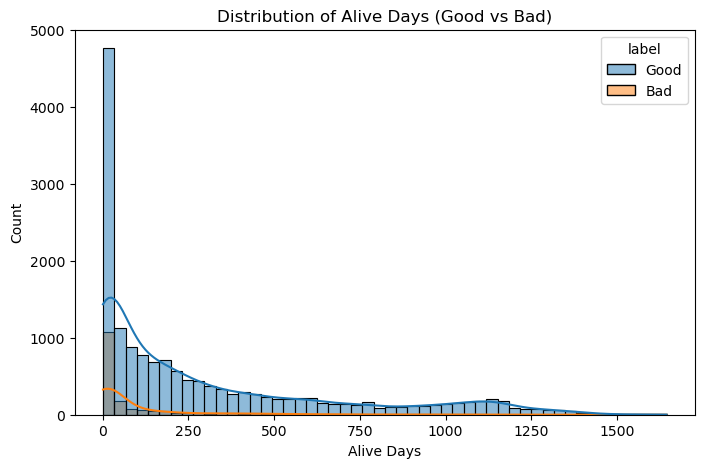

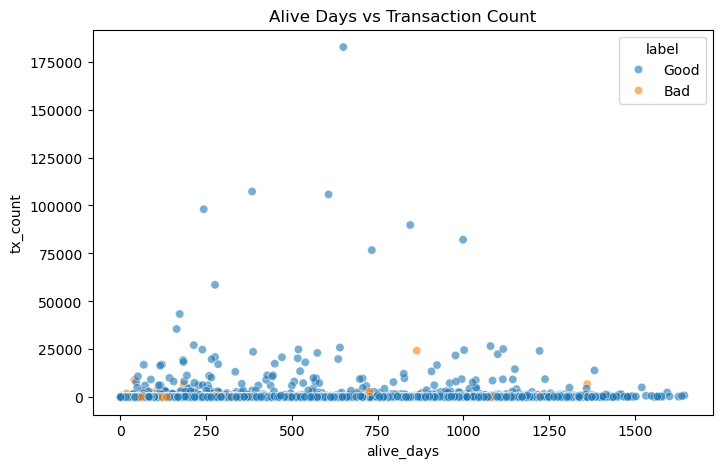

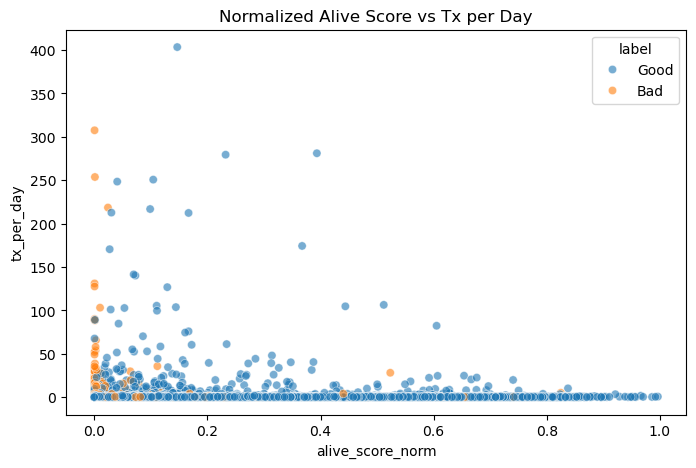

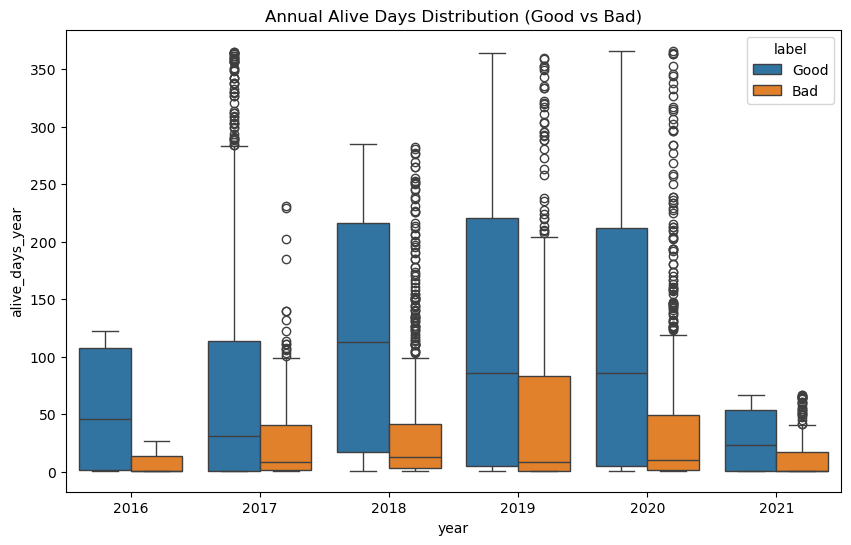

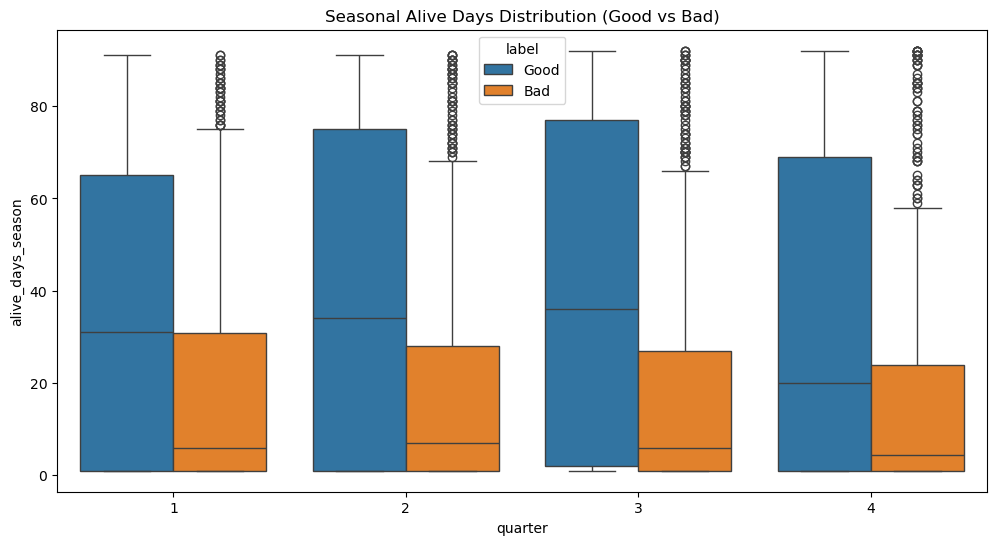

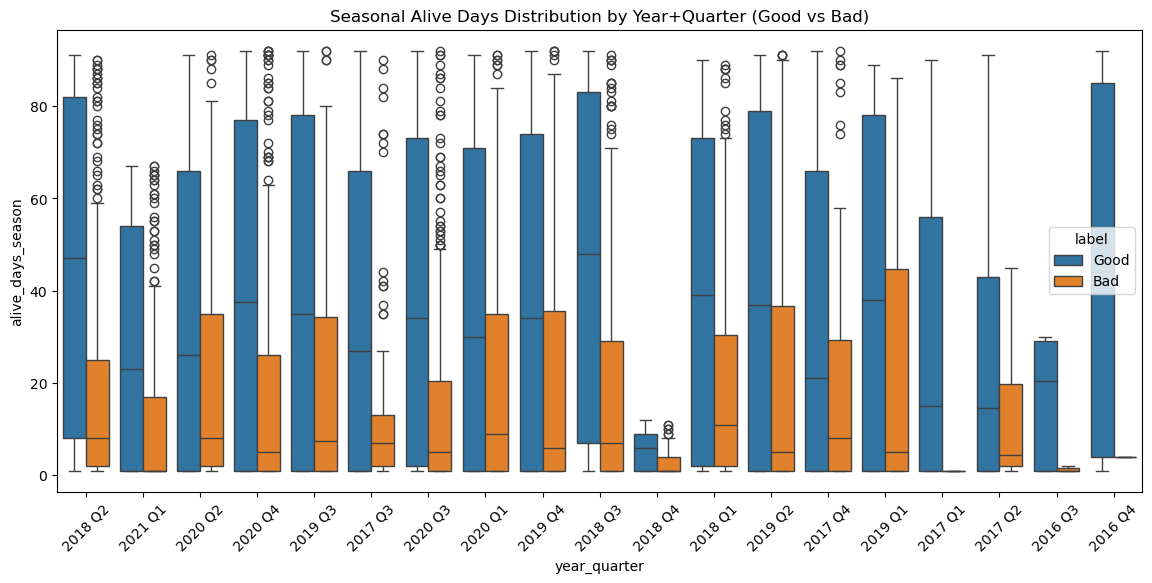

In [ ]:
plot_alive_feature(overall, annual, seasonal)

## survival analysis

In [70]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def survival_analysis_with_a_unknown(overall):
    pdf_filtered = overall.to_pandas()
    pdf = pdf_filtered[~pdf_filtered["account"].str.startswith("b")]
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(8,6))

    for label, group in pdf.groupby("label"):
        durations = group["alive_days"]
        events = [1] * len(group)  # all observed
        kmf.fit(durations, events, label=label)
        kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan–Meier Survival Curves (Good vs Bad vs Unknown)")
    plt.xlabel("Days Alive")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

def survival_analysis_with_b_unknown(overall):
    pdf_filtered = overall.to_pandas()
    pdf = pdf_filtered[~pdf_filtered["account"].str.startswith("a")]
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(8,6))

    for label, group in pdf.groupby("label"):
        durations = group["alive_days"]
        events = [1] * len(group)  # all observed
        kmf.fit(durations, events, label=label)
        kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan–Meier Survival Curves (Good vs Bad vs Unknown)")
    plt.xlabel("Days Alive")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

def survival_analysis_with_a_b_unknown(overall):
    pdf = overall.to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(8,6))

    for label, group in pdf.groupby("label"):
        durations = group["alive_days"]
        events = [1] * len(group)  # all observed
        kmf.fit(durations, events, label=label)
        kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan–Meier Survival Curves (Good vs Bad vs Unknown)")
    plt.xlabel("Days Alive")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

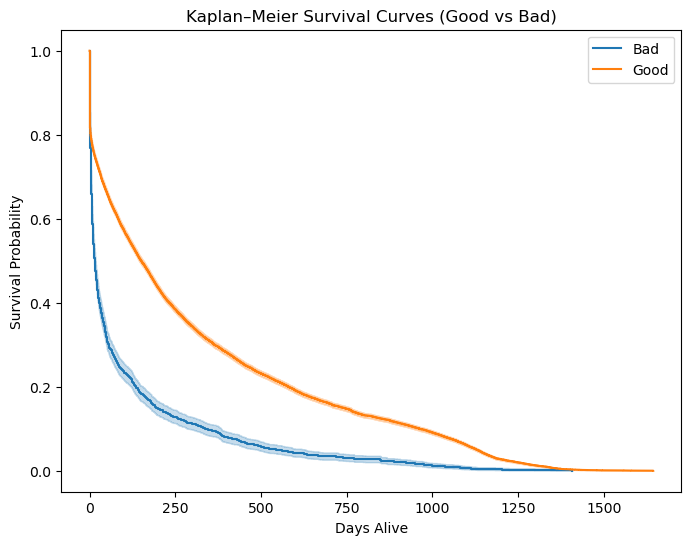

In [87]:
survival_analysis(overall)

In [54]:
hazard_ratio(overall)

<lifelines.CoxPHFitter: fitted with 966524 total observations, 0 right-censored observations>
             duration col = 'alive_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 966524
number of events observed = 966524
   partial log-likelihood = -12353068.02
         time fit was run = 2025-10-12 07:28:40 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
is_bad    -0.69      0.50      0.02           -0.74           -0.65                0.48                0.52

           cmp to      z      p  -log2(p)
covariate                                
is_bad       0.00 -28.80 <0.005    603.35
---
Concordance = 0.50
Partial AIC = 24706138.05
log-likelihood ratio test = 1057.99 on 1 df
-log2(p) of ll-ratio test = 768.53

In [58]:
overall.to_pandas()["flag"].value_counts()

flag
-1    948884
 0     15912
 1      1728
Name: count, dtype: int64

In [59]:
from lifelines import KaplanMeierFitter

pdf = overall.to_pandas()
for label, group in pdf.groupby("flag"):
    kmf = KaplanMeierFitter().fit(group["alive_days"], event_observed=[1]*len(group))
    print(label, "median survival:", kmf.median_survival_time_)

-1 median survival: 1.0
0 median survival: 150.0
1 median survival: 15.0


In [73]:
b_accounts = pdf[pdf["account"].str.startswith("b")]
print("Median alive_days (b accounts):", b_accounts["alive_days"].median())

Median alive_days (b accounts): 1.0


In [74]:
b_accounts["alive_days"].quantile(0.95)

150.0

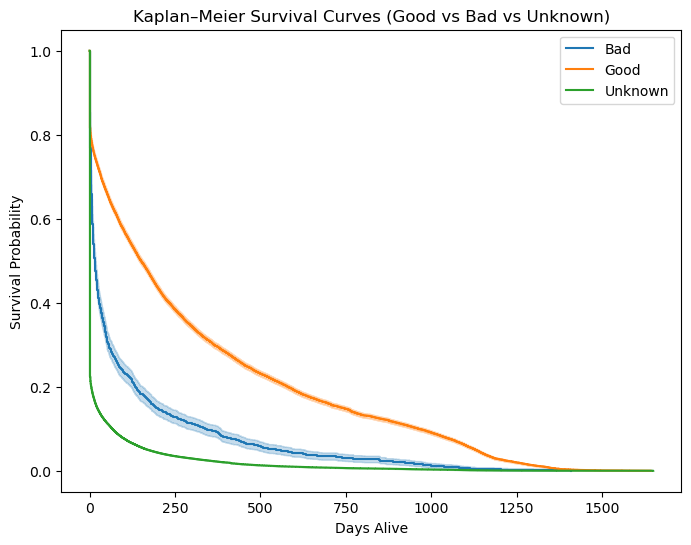

In [71]:
survival_analysis_with_a_b_unknown(overall)

/tmp/ipykernel_23335/3485237275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})


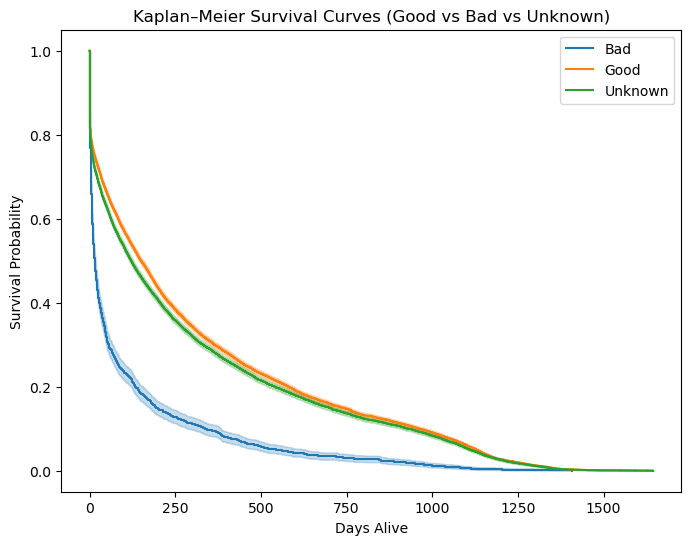

In [ ]:
survival_analysis_with_a_unknown(overall)

/tmp/ipykernel_23335/64520239.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})


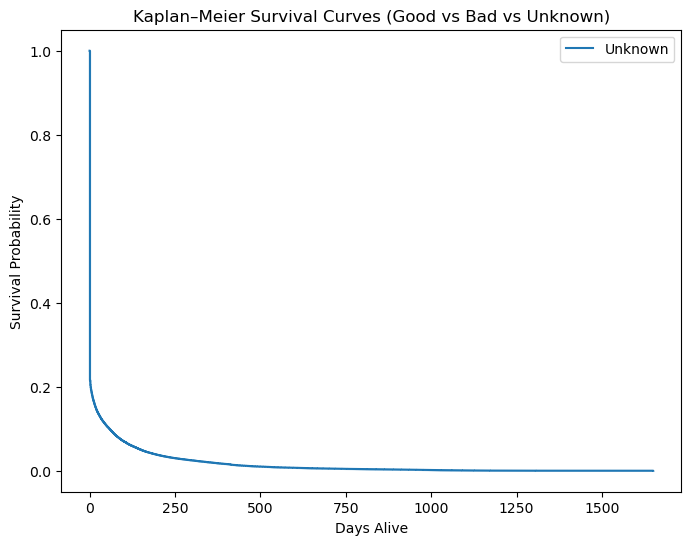

In [72]:
survival_analysis_with_b_unknown(overall)

In [76]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def survival_b_vs_bad(overall):
    pdf = overall.to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    # Filter b accounts
    b_accounts = pdf[pdf["account"].str.startswith("b")].copy()

    # Split into short-lived and long-lived
    b_accounts["b_group"] = "b_short"
    b_accounts.loc[b_accounts["alive_days"] > 1, "b_group"] = "b_long"

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8,6))

    # Plot known Bad
    bad = pdf[pdf["label"] == "Bad"]
    kmf.fit(bad["alive_days"], event_observed=[1]*len(bad), label="Known Bad")
    kmf.plot_survival_function(ci_show=True)

    # Plot b_short
    b_short = b_accounts[b_accounts["b_group"] == "b_short"]
    kmf.fit(b_short["alive_days"], event_observed=[1]*len(b_short), label="b_short (alive_days=1)")
    kmf.plot_survival_function(ci_show=True)

    # Plot b_long
    b_long = b_accounts[b_accounts["b_group"] == "b_long"]
    kmf.fit(b_long["alive_days"], event_observed=[1]*len(b_long), label="b_long (>1 day)")
    kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan–Meier Survival Curves: b Accounts vs Known Bad")
    plt.xlabel("Days Alive")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

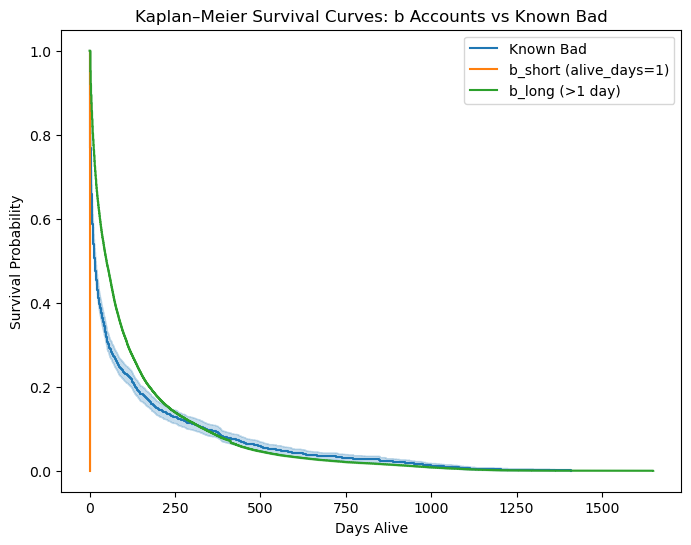

In [77]:
survival_b_vs_bad(overall)

In [78]:
import pandas as pd

def feature_summary(overall):
    pdf = overall.to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    # Isolate b accounts
    b_accounts = pdf[pdf["account"].str.startswith("b")].copy()
    b_long = b_accounts[b_accounts["alive_days"] > 1]  # long-lived b

    # Groups to compare
    groups = {
        "Good": pdf[pdf["label"] == "Good"],
        "Bad": pdf[pdf["label"] == "Bad"],
        "b_long": b_long
    }

    # Features of interest
    features = ["alive_days", "tx_per_day", "oversell_propensity", "connectivity_score", "variety_score"]

    # Build summary
    summary = {}
    for name, df in groups.items():
        summary[name] = {f: df[f].median() for f in features}

    return pd.DataFrame(summary)

In [81]:
overall.get_column

<bound method DataFrame.get_column of shape: (966_524, 8)
┌─────────┬──────────────┬──────────────┬──────────┬────────────┬────────────┬──────────────┬──────┐
│ account ┆ first_tx     ┆ last_tx      ┆ tx_count ┆ alive_days ┆ tx_per_day ┆ alive_score_ ┆ flag │
│ ---     ┆ ---          ┆ ---          ┆ ---      ┆ ---        ┆ ---        ┆ norm         ┆ ---  │
│ str     ┆ datetime[μs] ┆ datetime[μs] ┆ i64      ┆ i64        ┆ f64        ┆ ---          ┆ i64  │
│         ┆              ┆              ┆          ┆            ┆            ┆ f64          ┆      │
╞═════════╪══════════════╪══════════════╪══════════╪════════════╪════════════╪══════════════╪══════╡
│ a00001  ┆ 2020-11-17   ┆ 2020-11-20   ┆ 11       ┆ 4          ┆ 2.75       ┆ 0.001819     ┆ 0    │
│         ┆ 05:05:06     ┆ 21:23:11     ┆          ┆            ┆            ┆              ┆      │
│ a00002  ┆ 2020-07-21   ┆ 2020-07-27   ┆ 3        ┆ 7          ┆ 0.428571   ┆ 0.003639     ┆ -1   │
│         ┆ 15:54:40     ┆ 18:25:

In [88]:
feature_summary(overall)

Good        Bad     b_long
alive_days           150.500000  15.000000  49.000000
tx_per_day             0.118258   0.400000   0.090909
oversell_propensity    0.600000   0.000000   1.000000
connectivity_score     0.178969   0.256747   0.156746
variety_score          0.500000   0.888889   0.500000

## oversell distribution

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_oversell_distribution(overall):
    pdf = overall.to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})

    # Isolate b_long accounts
    b_accounts = pdf[pdf["account"].str.startswith("b")].copy()
    b_long = b_accounts[b_accounts["alive_days"] > 1].copy()
    b_long["label"] = "b_long"

    # Subset groups
    good = pdf[pdf["label"] == "Good"]
    bad = pdf[pdf["label"] == "Bad"]

    # Combine
    combined = pd.concat([good, bad, b_long], axis=0)

    # Plot
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=combined, x="oversell_propensity", hue="label", common_norm=False, fill=True, alpha=0.4)
    plt.title("Oversell Propensity Distribution: Good vs Bad vs b_long")
    plt.xlabel("Oversell Propensity")
    plt.ylabel("Density")
    plt.show()

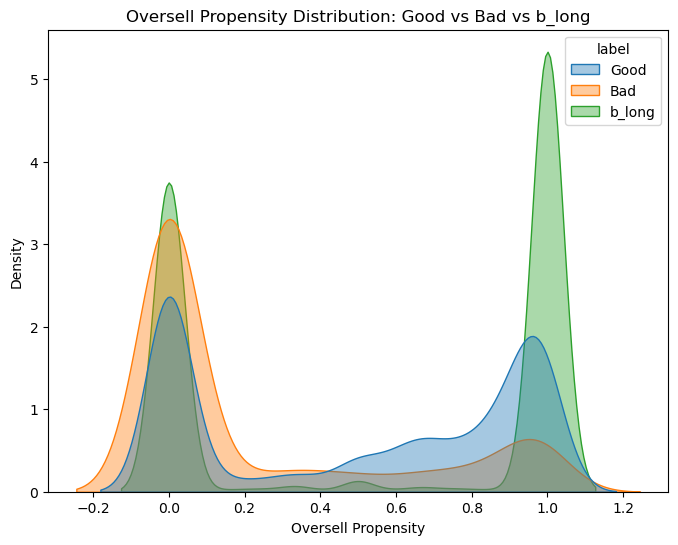

In [90]:
plot_oversell_distribution(overall)

## counterparty analysis

## Stable Version

In [14]:
import polars as pl

def build_counterparty_table(transactions_path, overall):
    # Load transactions
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # Tag accounts with group
    pdf = overall.select(["account", "flag", "alive_days"]).to_pandas()
    pdf["label"] = pdf["flag"].map({0: "Good", 1: "Bad", -1: "Unknown"})
    pdf.loc[pdf["account"].str.startswith("b") & (pdf["alive_days"] > 1), "label"] = "b_long"
    labels = pl.DataFrame(pdf[["account", "label"]])

    # Join group labels onto transactions
    tx = tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                 on="from_account", how="left")
    tx = tx.join(labels.rename({"account": "to_account", "label": "to_label"}),
                 on="to_account", how="left")

    # Count flows between groups
    flows = tx.group_by(["from_label", "to_label"]).len().rename({"len": "tx_count"})

    return tx, flows

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(tx):
    # Build directed graph with weights
    G = nx.from_pandas_edgelist(
        tx.to_pandas(),
        source="from_account",
        target="to_account",
        edge_attr=None,
        create_using=nx.DiGraph()
    )

    # Add group labels
    for row in tx.iter_rows(named=True):
        if row["from_label"] is not None:
            G.nodes[row["from_account"]]["group"] = row["from_label"]
        if row["to_label"] is not None:
            G.nodes[row["to_account"]]["group"] = row["to_label"]

    return G

In [16]:
def summarize_linkages(G):
    bad_nodes = [n for n, d in G.nodes(data=True) if d.get("group") == "Bad"]
    blong_nodes = [n for n, d in G.nodes(data=True) if d.get("group") == "b_long"]

    # Direct edges
    bad_to_b = [(u, v) for u, v in G.edges() if u in bad_nodes and v in blong_nodes]
    b_to_bad = [(u, v) for u, v in G.edges() if u in blong_nodes and v in bad_nodes]

    # Shared counterparties
    bad_partners = {nbr for n in bad_nodes for nbr in G.neighbors(n)}
    blong_partners = {nbr for n in blong_nodes for nbr in G.neighbors(n)}
    shared = bad_partners & blong_partners

    report = {
        "Direct Bad→b_long edges": len(bad_to_b),
        "Direct b_long→Bad edges": len(b_to_bad),
        "Shared counterparties": len(shared),
        "Num Bad nodes": len(bad_nodes),
        "Num b_long nodes": len(blong_nodes),
    }
    return report

In [17]:
def visualize_bad_blong(G, max_nodes=200):
    # Extract only Bad, b_long, and edges between them
    nodes = [n for n, d in G.nodes(data=True) if d.get("group") in ["Bad", "b_long"]]
    H = G.subgraph(nodes)

    # Optionally sample for readability
    if len(H.nodes) > max_nodes:
        import random
        sampled = random.sample(list(H.nodes), max_nodes)
        H = H.subgraph(sampled)

    # Color map
    color_map = []
    for node in H.nodes():
        group = G.nodes[node].get("group", "Unknown")
        if group == "Bad":
            color_map.append("red")
        elif group == "b_long":
            color_map.append("blue")
        else:
            color_map.append("gray")

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=42)
    nx.draw_networkx_nodes(H, pos, node_color=color_map, node_size=50, alpha=0.7)
    nx.draw_networkx_edges(H, pos, alpha=0.3, arrows=False)
    plt.title("Bad ↔ b_long Counterparty Subgraph")
    plt.axis("off")
    plt.show()

In [28]:
import polars as pl

def summarize_linkages_pl(transactions_path, overall):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels from overall ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0)
              .then(pl.lit("Good"))
              .when(pl.col("flag") == 1)
              .then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )

    # Mark b_long
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Direct edges counts ---
    flows = (
        tx.group_by(["from_label", "to_label"])
          .len()
          .rename({"len": "tx_count"})
    )

    bad_to_b = flows.filter((pl.col("from_label") == "Bad") & (pl.col("to_label") == "b_long"))["tx_count"].sum()
    b_to_bad = flows.filter((pl.col("from_label") == "b_long") & (pl.col("to_label") == "Bad"))["tx_count"].sum()

    # --- Shared counterparties ---
    bad_partners = (
        tx.filter(pl.col("from_label") == "Bad")
          .select("to_account")
          .unique()
    )
    blong_partners = (
        tx.filter(pl.col("from_label") == "b_long")
          .select("to_account")
          .unique()
    )
    shared = bad_partners.join(blong_partners, on="to_account", how="inner")

    # --- Report ---
    report = {
        "Direct Bad→b_long edges": int(bad_to_b) if bad_to_b is not None else 0,
        "Direct b_long→Bad edges": int(b_to_bad) if b_to_bad is not None else 0,
        "Shared counterparties": shared.height,
        "Num Bad nodes": labels.filter(pl.col("label") == "Bad").height,
        "Num b_long nodes": labels.filter(pl.col("label") == "b_long").height,
    }
    return report

In [18]:
# Step 1: Build counterparty table
tx, flows = build_counterparty_table("data/transactions.csv", overall)
print(flows)

shape: (15, 3)
┌────────────┬──────────┬──────────┐
│ from_label ┆ to_label ┆ tx_count │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ str      ┆ u32      │
╞════════════╪══════════╪══════════╡
│ Good       ┆ Good     ┆ 18361    │
│ Good       ┆ Bad      ┆ 113      │
│ b_long     ┆ Unknown  ┆ 984171   │
│ Unknown    ┆ Bad      ┆ 59850    │
│ Bad        ┆ Good     ┆ 37       │
│ …          ┆ …        ┆ …        │
│ Unknown    ┆ Unknown  ┆ 334906   │
│ Good       ┆ Unknown  ┆ 184379   │
│ b_long     ┆ Bad      ┆ 35374    │
│ b_long     ┆ Good     ┆ 1587194  │
│ Good       ┆ b_long   ┆ 1233404  │
└────────────┴──────────┴──────────┘


In [19]:
# Step 2: Build graph
G = build_graph(tx)

In [29]:
# Step 3: Summarize linkages
#report = summarize_linkages(G)
#print(report)

report = summarize_linkages_pl("data/transactions.csv", overall)
print(report)

{'Direct Bad→b_long edges': 30853, 'Direct b_long→Bad edges': 35374, 'Shared counterparties': 226, 'Num Bad nodes': 1728, 'Num b_long nodes': 201272}


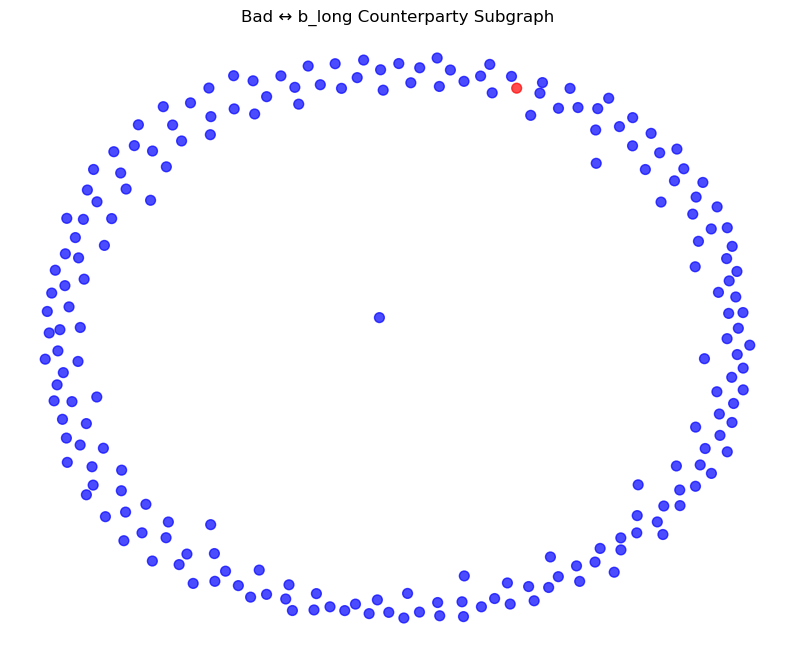

In [30]:
# Step 4: Visualize
visualize_bad_blong(G)

## Clustermap

In [ ]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def blong_bad_clustermap(transactions_path, overall, sample_blong=500):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Filter only Bad ↔ b_long edges ---
    df = tx.filter(
        ((pl.col("from_label") == "b_long") & (pl.col("to_label") == "Bad")) |
        ((pl.col("from_label") == "Bad") & (pl.col("to_label") == "b_long"))
    ).to_pandas()

    # --- Build incidence matrix (rows=b_long, cols=Bad) ---
    # Normalize direction: always row=b_long, col=Bad
    df["b_long"] = df.apply(lambda r: r["from_account"] if r["from_label"]=="b_long" else r["to_account"], axis=1)
    df["bad"]    = df.apply(lambda r: r["from_account"] if r["from_label"]=="Bad" else r["to_account"], axis=1)

    mat = pd.crosstab(df["b_long"], df["bad"])

    # --- Optional: sample b_long accounts for readability ---
    if sample_blong and mat.shape[0] > sample_blong:
        mat = mat.sample(n=sample_blong, random_state=42)

    # tuning
    mat = (mat > 0).astype(int)

    # --- Plot clustermap ---
    sns.clustermap(mat, cmap="Reds", figsize=(12, 8), 
                   row_cluster=True, col_cluster=True,
                   xticklabels=False, yticklabels=False)
    plt.suptitle("b_long vs Bad Connectivity Clustermap", y=1.02)
    plt.show()

    return mat

In [41]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def shared_counterparty_clustermap(transactions_path, overall, sample_blong=500):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Identify shared counterparties (226 accounts) ---
    bad_partners = (
        tx.filter(pl.col("from_label") == "Bad")
          .select("to_account").unique()
    )
    blong_partners = (
        tx.filter(pl.col("from_label") == "b_long")
          .select("to_account").unique()
    )
    shared = bad_partners.join(blong_partners, on="to_account", how="inner")
    shared_counterparties = shared["to_account"].to_list()

    # --- Filter transactions to only those involving shared counterparties ---
    df = tx.filter(
        (pl.col("to_account").is_in(shared_counterparties)) |
        (pl.col("from_account").is_in(shared_counterparties))
    ).to_pandas()

    # --- Build incidence matrix: rows=b_long, cols=Bad ---
    df["b_long"] = df.apply(lambda r: r["from_account"] if r["from_label"]=="b_long" else r["to_account"], axis=1)
    df["bad"]    = df.apply(lambda r: r["from_account"] if r["from_label"]=="Bad" else r["to_account"], axis=1)

    mat = pd.crosstab(df["b_long"], df["bad"])

    # --- Optional: sample b_long accounts for readability ---
    if sample_blong and mat.shape[0] > sample_blong:
        mat = mat.sample(n=sample_blong, random_state=42)

    # --- Log scale to make small values visible ---
    mat = np.log1p(mat)

    # --- Plot clustermap ---
    sns.clustermap(mat, cmap="Reds", figsize=(12, 8),
                   row_cluster=True, col_cluster=True,
                   xticklabels=False, yticklabels=False)
    plt.suptitle("b_long vs Bad Connectivity via Shared Counterparties", y=1.02)
    plt.show()

    return mat, shared_counterparties

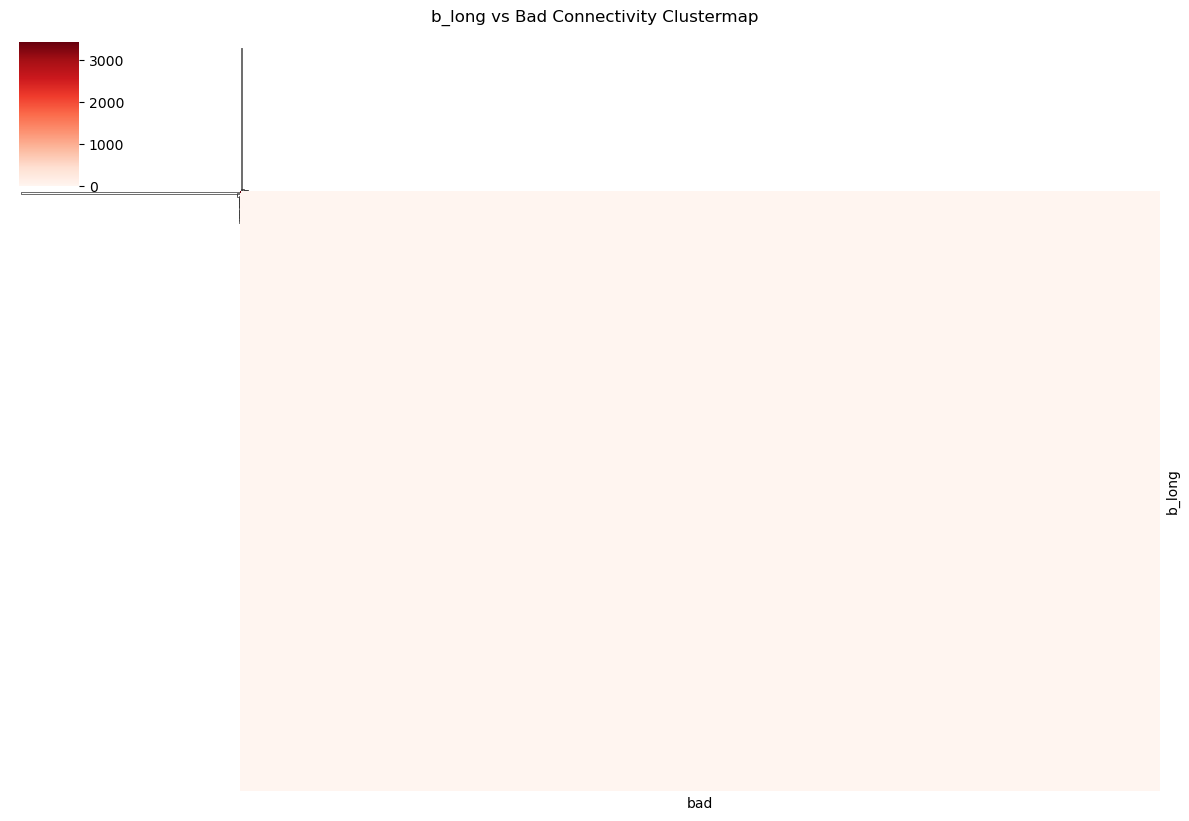

In [35]:
mat = blong_bad_clustermap("data/transactions.csv", overall, sample_blong=500)

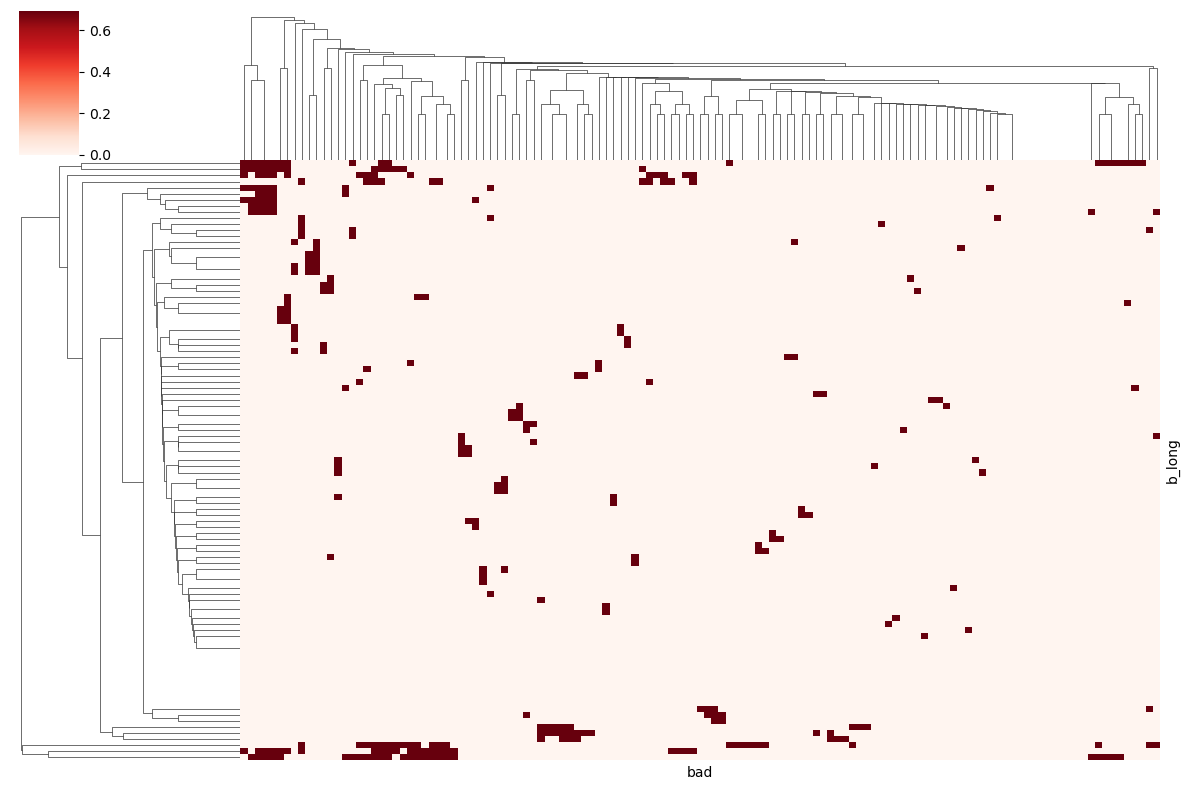

In [ ]:
# Filter to only b_long with at least 2 Bad connections
mat_filtered = mat.loc[mat.sum(axis=1) > 1, mat.sum(axis=0) > 1]

# Log scale to make small values visible
import numpy as np
mat_filtered = np.log1p(mat_filtered)

sns.clustermap(mat_filtered, cmap="Reds", figsize=(12,8),
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False)

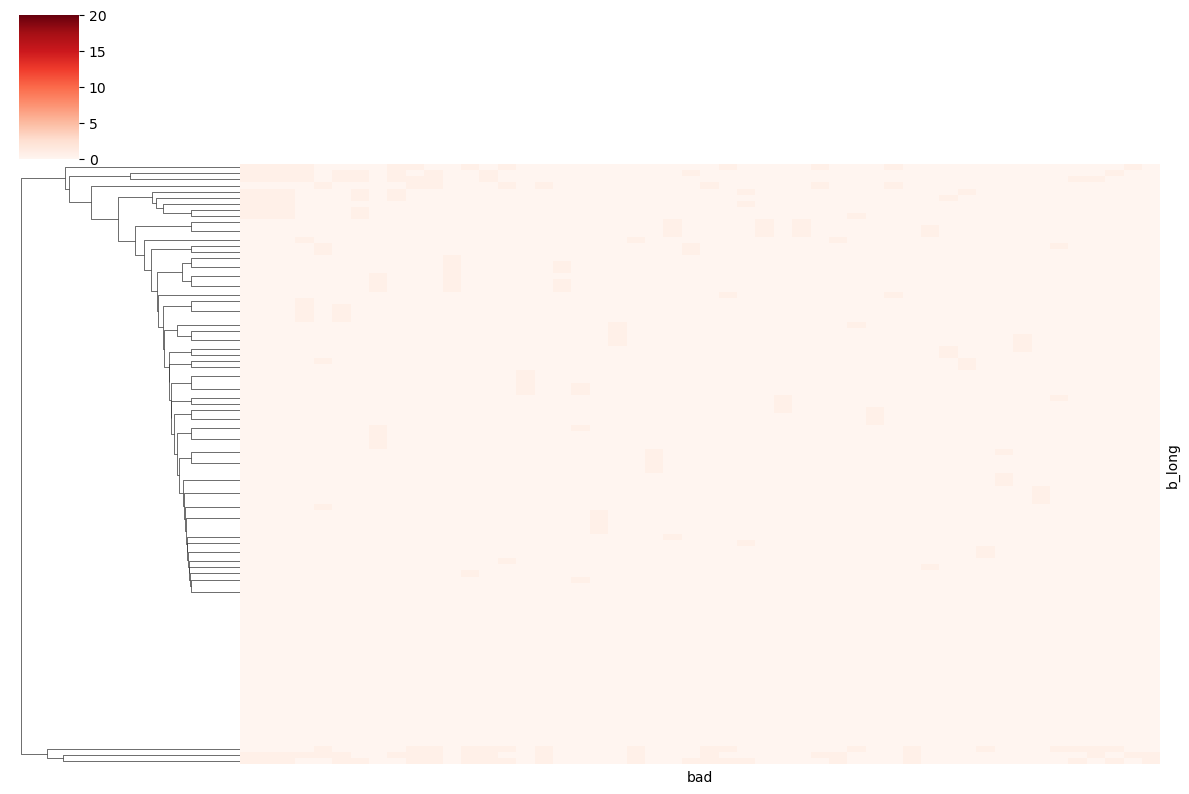

In [43]:
# Filter to active rows/cols
mat_filtered = mat.loc[mat.sum(axis=1) > 1, mat.sum(axis=0) > 1]

# Focus on top 50 Bad hubs
top_bad = mat_filtered.sum(axis=0).sort_values(ascending=False).head(50).index
mat_filtered = mat_filtered[top_bad]

# Log scale
import numpy as np
mat_filtered = np.log1p(mat_filtered)

# Plot clustermap (cluster rows only)
sns.clustermap(mat_filtered, cmap="Reds", vmax=20, figsize=(12,8),
               row_cluster=True, col_cluster=False,
               xticklabels=False, yticklabels=False)
plt.show()

In [44]:
import polars as pl
import pandas as pd

def top_bad_hubs(transactions_path, overall, top_n=10):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Filter only Bad ↔ b_long edges ---
    df = tx.filter(
        ((pl.col("from_label") == "b_long") & (pl.col("to_label") == "Bad")) |
        ((pl.col("from_label") == "Bad") & (pl.col("to_label") == "b_long"))
    ).to_pandas()

    # Normalize direction: always row=b_long, col=Bad
    df["b_long"] = df.apply(lambda r: r["from_account"] if r["from_label"]=="b_long" else r["to_account"], axis=1)
    df["bad"]    = df.apply(lambda r: r["from_account"] if r["from_label"]=="Bad" else r["to_account"], axis=1)

    # Count unique b_long per Bad
    hub_counts = df.groupby("bad")["b_long"].nunique().reset_index()
    hub_counts = hub_counts.rename(columns={"b_long": "unique_blong"})
    hub_counts = hub_counts.sort_values("unique_blong", ascending=False).head(top_n)

    return hub_counts

In [45]:
top_hubs = top_bad_hubs("data/transactions.csv", overall, top_n=10)
print(top_hubs)

         bad  unique_blong
120   a03013          2027
1439  a31226          1033
981   a21502           394
615   a14058           318
488   a10902           315
1401  a30489           302
718   a16075           301
609   a13858           255
1058  a23267           254
671   a15045           253


In [46]:
import polars as pl
import pandas as pd

def top_shared_counterparties(transactions_path, overall, top_n=10):
    # --- Load transactions ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Identify shared counterparties ---
    bad_partners = tx.filter(pl.col("from_label") == "Bad").select("to_account").unique()
    blong_partners = tx.filter(pl.col("from_label") == "b_long").select("to_account").unique()
    shared = bad_partners.join(blong_partners, on="to_account", how="inner")
    shared_accounts = shared["to_account"].to_list()

    # --- Count how many Bad and b_long each shared account connects to ---
    df = tx.filter(
        (pl.col("to_account").is_in(shared_accounts)) |
        (pl.col("from_account").is_in(shared_accounts))
    ).to_pandas()

    # Normalize direction
    df["shared"] = df.apply(
        lambda r: r["from_account"] if r["from_account"] in shared_accounts else r["to_account"], axis=1
    )
    df["other"] = df.apply(
        lambda r: r["to_account"] if r["from_account"] in shared_accounts else r["from_account"], axis=1
    )
    df["other_label"] = df.apply(
        lambda r: r["to_label"] if r["from_account"] in shared_accounts else r["from_label"], axis=1
    )

    # Count unique Bad and b_long per shared account
    bad_counts = df[df["other_label"]=="Bad"].groupby("shared")["other"].nunique()
    blong_counts = df[df["other_label"]=="b_long"].groupby("shared")["other"].nunique()

    summary = pd.DataFrame({
        "unique_bad": bad_counts,
        "unique_blong": blong_counts
    }).fillna(0).astype(int)

    # Rank by total connections
    summary["total_links"] = summary["unique_bad"] + summary["unique_blong"]
    summary = summary.sort_values("total_links", ascending=False).head(top_n)

    return summary.reset_index()

In [47]:
top_shared = top_shared_counterparties("data/transactions.csv", overall, top_n=10)
print(top_shared)

   shared  unique_bad  unique_blong  total_links
0  a05023           2         17542        17544
1  a25941           1          5162         5163
2  a26711           0          3934         3934
3  a29649           4          3144         3148
4  a26730           5          2791         2796
5  a24560           2          2330         2332
6  a08512           2          1529         1531
7  a19844           1          1355         1356
8  a15593           2          1183         1185
9  a28243           1          1079         1080


## bad account and 'b' long experiment

In [ ]:
import polars as pl
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def visualize_top_shared_weighted(transactions_path, overall, top_n=10):
    # --- Get top shared counterparties ---
    top_shared = top_shared_counterparties(transactions_path, overall, top_n=top_n)

    # --- Reload transactions with labels ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )

    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    ).to_pandas()

    # --- Build weighted graph ---
    G = nx.Graph()
    shared_accounts = top_shared["shared"].tolist()

    for s in shared_accounts:
        G.add_node(s, group="shared")

    # Count edges with weights
    edge_weights = {}

    for _, row in tx.iterrows():
        if row["from_account"] in shared_accounts or row["to_account"] in shared_accounts:
            shared = row["from_account"] if row["from_account"] in shared_accounts else row["to_account"]
            other  = row["to_account"] if row["from_account"] in shared_accounts else row["from_account"]
            other_label = row["to_label"] if row["from_account"] in shared_accounts else row["from_label"]

            if other_label in ["Bad", "b_long"]:
                G.add_node(other, group=other_label)
                edge = tuple(sorted([shared, other]))
                edge_weights[edge] = edge_weights.get(edge, 0) + 1

    # Add weighted edges
    for (u, v), w in edge_weights.items():
        G.add_edge(u, v, weight=w)

    # --- Draw ---
    color_map = []
    for node, data in G.nodes(data=True):
        if data["group"] == "Bad":
            color_map.append("red")
        elif data["group"] == "b_long":
            color_map.append("blue")
        else:
            color_map.append("orange")

    # Edge thickness proportional to log(weight)
    weights = [max(1, min(10, int(np.log1p(d["weight"])))) for _, _, d in G.edges(data=True)]

    pos = nx.spring_layout(G, seed=42, k=0.5)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=80, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4)
    plt.title(f"Top {top_n} Shared Counterparties Linking Bad ↔ b_long (Weighted)", fontsize=14)
    plt.axis("off")
    plt.show()

    return top_shared

In [52]:
import polars as pl
import pandas as pd

def aggregate_shared_edges(transactions_path, overall, top_n=10):
    # --- Reload transactions with schema ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Identify shared counterparties ---
    bad_partners = tx.filter(pl.col("from_label") == "Bad").select("to_account").unique()
    blong_partners = tx.filter(pl.col("from_label") == "b_long").select("to_account").unique()
    shared = bad_partners.join(blong_partners, on="to_account", how="inner")
    shared_accounts = shared["to_account"].to_list()

    # --- Normalize edges: always (shared, other) ---
    df = tx.filter(
        (pl.col("to_account").is_in(shared_accounts)) |
        (pl.col("from_account").is_in(shared_accounts))
    ).with_columns([
        pl.when(pl.col("from_account").is_in(shared_accounts))
          .then(pl.col("from_account"))
          .otherwise(pl.col("to_account"))
          .alias("shared"),
        pl.when(pl.col("from_account").is_in(shared_accounts))
          .then(pl.col("to_account"))
          .otherwise(pl.col("from_account"))
          .alias("other"),
        pl.when(pl.col("from_account").is_in(shared_accounts))
          .then(pl.col("to_label"))
          .otherwise(pl.col("from_label"))
          .alias("other_label")
    ])

    # --- Aggregate edge weights in Polars ---
    edges = (
        df.group_by(["shared", "other", "other_label"])
          .len()
          .rename({"len": "weight"})
          .sort("weight", descending=True)
    )

    # Convert to pandas for downstream NetworkX/plotting
    edges_pd = edges.to_pandas()

    # --- Top shared counterparties by total links ---
    top_shared = (
        edges.group_by("shared")
             .agg(pl.sum("weight").alias("total_weight"))
             .sort("total_weight", descending=True)
             .head(top_n)
             .to_pandas()
    )

    return edges_pd, top_shared

In [53]:
edges_pd, top_shared = aggregate_shared_edges("data/transactions.csv", overall, top_n=10)

print("Weighted edge list (sample):")
print(edges_pd.head())

print("\nTop shared counterparties:")
print(top_shared)

Weighted edge list (sample):
   shared    other other_label  weight
0  a08512  b555546      b_long   11337
1  a28243   b41663      b_long   11248
2  a29649   b31698      b_long    9408
3  a26730   b31717      b_long    7260
4  a29649  b392291      b_long    6139

Top shared counterparties:
   shared  total_weight
0  a05023         98027
1  a29649         53104
2  a28243         40264
3  a26730         28889
4  a08512         24128
5  a19844         23630
6  a26711         19780
7  a25941         19267
8  a24560         18755
9  a02224          9356


### output

In [56]:
import polars as pl

def prepare_bad_blong_edges(transactions_path: str,
                            overall,
                            out_path: str = "data/bad_blong_edges.csv"):
    """
    Extract all edges between Bad and b_long accounts from raw transactions.
    Produces a normalized edge list with columns:
    [from_account, to_account, from_label, to_label].
    """

    # --- Load transactions with schema ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build account labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )

    # Mark b_long accounts
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Filter only Bad ↔ b_long edges ---
    edges = tx.filter(
        ((pl.col("from_label") == "Bad") & (pl.col("to_label") == "b_long")) |
        ((pl.col("from_label") == "b_long") & (pl.col("to_label") == "Bad"))
    ).select(["from_account", "to_account", "from_label", "to_label"])

    # --- Save to CSV ---
    edges.write_csv(out_path)

    print(f"✅ Saved {edges.height} Bad ↔ b_long edges to {out_path}")
    return edges

In [57]:
edges = prepare_bad_blong_edges(
    transactions_path="data/transactions.csv",
    overall=overall,
    out_path="data/bad_blong_edges.csv"
)

✅ Saved 66227 Bad ↔ b_long edges to data/bad_blong_edges.csv


In [19]:
import polars as pl

def prepare_account_blong_edges(transactions_path: str,
                                overall,
                                out_path: str = "data/account_blong_edges.csv"):
    """
    Build a normalized edge list between ANY account (Bad, Good, Unknown) and b_long accounts.
    Output columns: [from_account, to_account, from_label, to_label].
    """

    # --- Load transactions with schema ---
    tx = pl.read_csv(
        transactions_path,
        schema_overrides={
            "from_account": pl.Utf8,
            "to_account": pl.Utf8,
            "transaction_time_utc": pl.Utf8,
            "value": pl.Float64,
            "gas": pl.Float64,
            "gas_price": pl.Float64,
        }
    )

    # --- Build account labels ---
    labels = (
        overall
        .select(["account", "flag", "alive_days"])
        .with_columns(
            pl.when(pl.col("flag") == 0).then(pl.lit("Good"))
              .when(pl.col("flag") == 1).then(pl.lit("Bad"))
              .otherwise(pl.lit("Unknown"))
              .alias("label")
        )
    )

    # Mark b_long accounts
    labels = labels.with_columns(
        pl.when((pl.col("account").str.starts_with("b")) & (pl.col("alive_days") > 1))
          .then(pl.lit("b_long"))
          .otherwise(pl.col("label"))
          .alias("label")
    ).select(["account", "label"])

    # --- Join labels onto transactions ---
    tx = (
        tx.join(labels.rename({"account": "from_account", "label": "from_label"}),
                on="from_account", how="left")
          .join(labels.rename({"account": "to_account", "label": "to_label"}),
                on="to_account", how="left")
    )

    # --- Filter only edges involving b_long ---
    edges = tx.filter(
        (pl.col("from_label") == "b_long") | (pl.col("to_label") == "b_long")
    ).select(["from_account", "to_account", "from_label", "to_label"])

    # --- Save to CSV ---
    edges.write_csv(out_path)
    print(f"✅ Saved {edges.height} edges to {out_path}")
    return edges

In [20]:
edges = prepare_account_blong_edges(
    transactions_path="data/transactions.csv",
    overall=overall,
    out_path="data/account_blong_edges.csv"
)

✅ Saved 4948385 edges to data/account_blong_edges.csv
